In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
areas1 = np.genfromtxt("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/testing0304/nRUN1_areas.csv", delimiter=",")
areas2 = np.genfromtxt("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/testing0304/nRUN2_areas.csv", delimiter=",")
areas3 = np.genfromtxt("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/testing0304/nRUN3_areas.csv", delimiter=",")
areas4 = np.genfromtxt("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/testing0304/nRUN4_areas.csv", delimiter=",")
areas5 = np.genfromtxt("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/testing0304/nRUN5_areas.csv", delimiter=",")

In [4]:
nRUN1_pressure = np.genfromtxt("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/testing0304/nRUN1_pressure.csv", delimiter=",", skip_header=1)
nRUN2_pressure = np.genfromtxt("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/testing0304/nRUN2_pressure.csv", delimiter=",", skip_header=1)
nRUN3_pressure = np.genfromtxt("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/testing0304/nRUN3_pressure.csv", delimiter=",", skip_header=1)
nRUN4_pressure = np.genfromtxt("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/testing0304/nRUN4_pressure.csv", delimiter=",", skip_header=1)
nRUN5_pressure = np.genfromtxt("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/testing0304/nRUN5_pressure.csv", delimiter=",", skip_header=1)
nRUN_pressure = [nRUN1_pressure, nRUN2_pressure, nRUN3_pressure, nRUN4_pressure, nRUN5_pressure]

In [5]:
p_windows = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3]


In [6]:
from scipy.optimize import curve_fit, root_scalar
from scipy.special import erfc, erfcx
import numpy as np
import matplotlib.pyplot as plt

def emg_pdf(x, mu, sigma, lambd, A):
    """
    Exponentially Modified Gaussian distribution.
    """
    arg = (mu + lambd * sigma**2 - x) / (np.sqrt(2) * sigma)
    return A * (lambd / 2) * np.exp(lambd / 2 * (2 * mu + lambd * sigma**2 - 2 * x)) * erfc(arg)

# Define inverse of erfcx numerically
def erfcxinv(y):
    """
    Numerically computes the inverse of the scaled complementary error function (erfcx).
    Returns np.nan if no valid root is found.
    """
    if y < 1e-6 or y > 1e6:
        return np.nan  # outside stable inversion range
    def func(x):
        return erfcx(x) - y
    try:
        sol = root_scalar(func, bracket=[-10, 10], method='brentq')
        return sol.root if sol.converged else np.nan
    except ValueError:
        return np.nan

def emg_mode(mu, sigma, lambd):
    """
    Computes the mode (peak) of the EMG using the analytical expression with domain-safe inversion.
    Returns np.nan if invalid.
    """
    tau = 1 / lambd
    factor = (abs(tau) / sigma) * np.sqrt(2 / np.pi)
    inv = erfcxinv(factor)
    if np.isnan(inv):
        return np.nan  # fallback or skip this fit
    return mu - np.sign(tau) * np.sqrt(2) * sigma * inv + (sigma**2 / tau)


def emg_fit(data, run):
    data = data[data<4e-5]
    # Histogram
    hist_values, bin_edges = np.histogram(data, bins=100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Initial guess
    mu_guess = np.mean(data)
    sigma_guess = np.std(data)
    lambd_guess = 1 / sigma_guess
    A_guess = max(hist_values)
    initial_guess = [mu_guess, sigma_guess, lambd_guess, A_guess]

    try:
        # Fit
        popt, pcov = curve_fit(emg_pdf, bin_centers, hist_values, p0=initial_guess, maxfev=50000)
        mu_fit, sigma_fit, lambd_fit, A_fit = popt
        mu_err, sigma_err, lambd_err, A_err = np.sqrt(np.diag(pcov))

        # Fit curve
        x_fit = np.linspace(min(data), max(data), 500)
        y_fit = emg_pdf(x_fit, *popt)

        # Compute mode
        x_peak = emg_mode(mu_fit, sigma_fit, lambd_fit)

        # Numerical error propagation for mode
        delta = 1e-6
        mode_plus_mu = emg_mode(mu_fit + delta, sigma_fit, lambd_fit)
        mode_plus_sigma = emg_mode(mu_fit, sigma_fit + delta, lambd_fit)
        mode_plus_lambda = emg_mode(mu_fit, sigma_fit, lambd_fit + delta)

        dmode_dmu = (mode_plus_mu - x_peak) / delta
        dmode_dsigma = (mode_plus_sigma - x_peak) / delta
        dmode_dlambda = (mode_plus_lambda - x_peak) / delta

        x_peak_err = np.sqrt(
            (dmode_dmu * mu_err) ** 2 +
            (dmode_dsigma * sigma_err) ** 2 +
            (dmode_dlambda * lambd_err) ** 2
        )

        if np.isnan(x_peak) == True:
            x_peak = np.mean(data)
            x_peak_err = x_peak / len(data)
        elif x_peak < 0:
            x_peak = np.mean(data)
            x_peak_err = x_peak / len(data)
        elif x_peak_err > 4 * x_peak:
            x_peak = np.mean(data)
            x_peak_err = x_peak / len(data)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=100, alpha=0.5, density=False) #label="Data Histogram", density=False)
        plt.plot(x_fit, y_fit, 'r-') #label=f'EMG Fit:\nμ={mu_fit:.2e} ± {mu_err:.2e}\nσ={sigma_fit:.2e} ± {sigma_err:.2e}\nλ={lambd_fit:.2e} ± {lambd_err:.2e}')
        plt.axvline(x_peak, color='green', linestyle='--', label=f'MPV ≈ {x_peak:.2e} ± {x_peak_err:.2e}')
        plt.xlabel("Charge released (mVs)")
        plt.ylabel("Events")
        plt.title(f"Charge Histogram - RUN {run}", weight="bold")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    except RuntimeError as e:
        print(f"Fit failed: {e}")
        return None

    return mu_fit, sigma_fit, lambd_fit, mu_err, sigma_err, lambd_err, x_peak, x_peak_err


def fit_routine(areas, nRUN_pressure, run, plot=True):
    start = 0
    fitparams = np.zeros((len(nRUN_pressure[:,1]), 8))
    for k in range(len(nRUN_pressure[:,1])):
        window = int(nRUN_pressure[:,1][k])
        data = areas[start:window]
        fitparams[k] = emg_fit(data, run + " " + str(p_windows[k]) + "-" + str(p_windows[k+1]) + "mBar")
        start = int(window)
    return fitparams

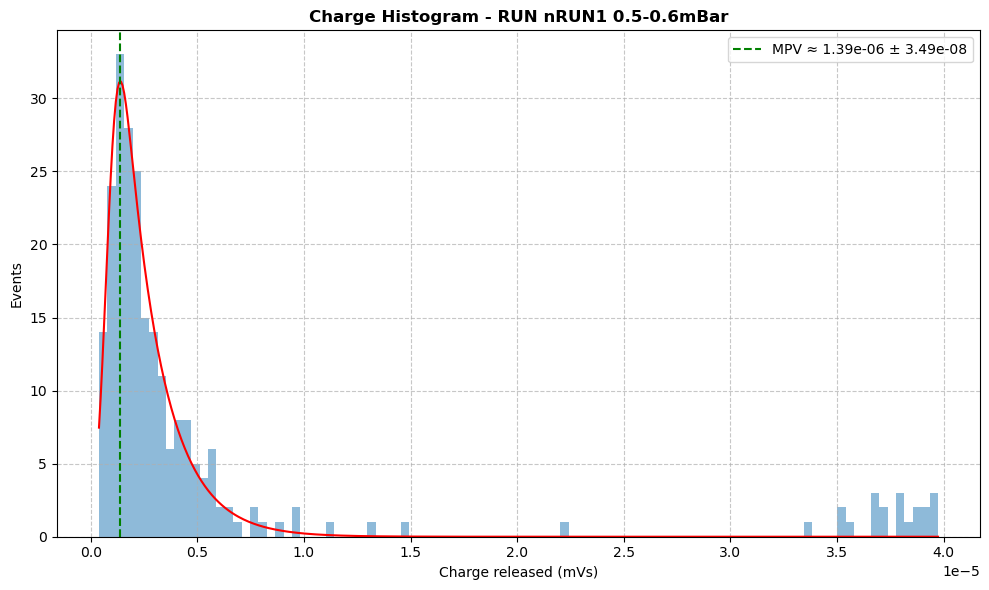

C:\Users\louis\AppData\Local\Temp\ipykernel_1688\3570109240.py:11: RuntimeWarning: overflow encountered in exp
  return A * (lambd / 2) * np.exp(lambd / 2 * (2 * mu + lambd * sigma**2 - 2 * x)) * erfc(arg)
C:\Users\louis\AppData\Local\Temp\ipykernel_1688\3570109240.py:11: RuntimeWarning: overflow encountered in multiply
  return A * (lambd / 2) * np.exp(lambd / 2 * (2 * mu + lambd * sigma**2 - 2 * x)) * erfc(arg)
C:\Users\louis\AppData\Local\Temp\ipykernel_1688\3570109240.py:11: RuntimeWarning: invalid value encountered in multiply
  return A * (lambd / 2) * np.exp(lambd / 2 * (2 * mu + lambd * sigma**2 - 2 * x)) * erfc(arg)


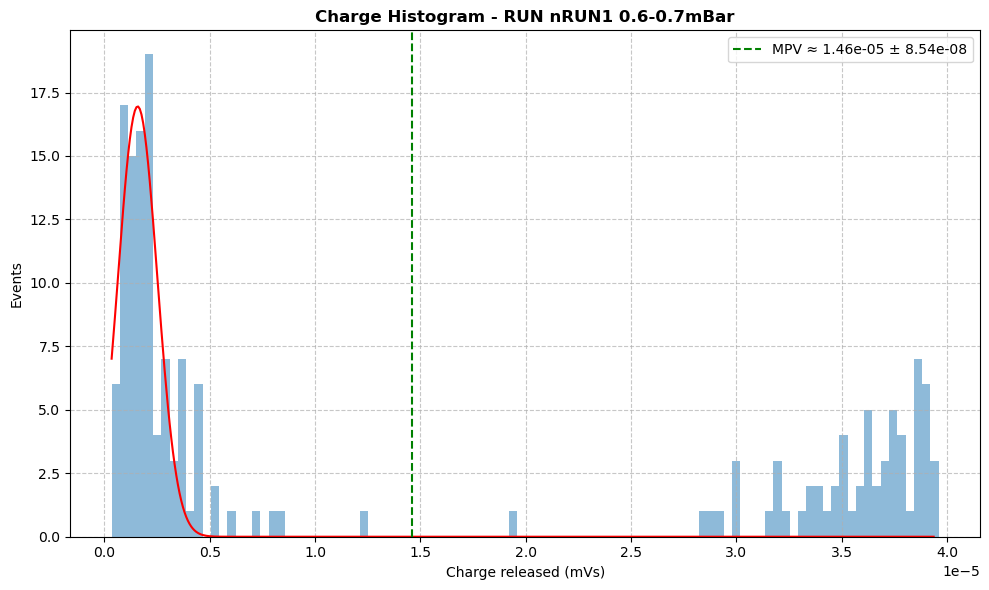

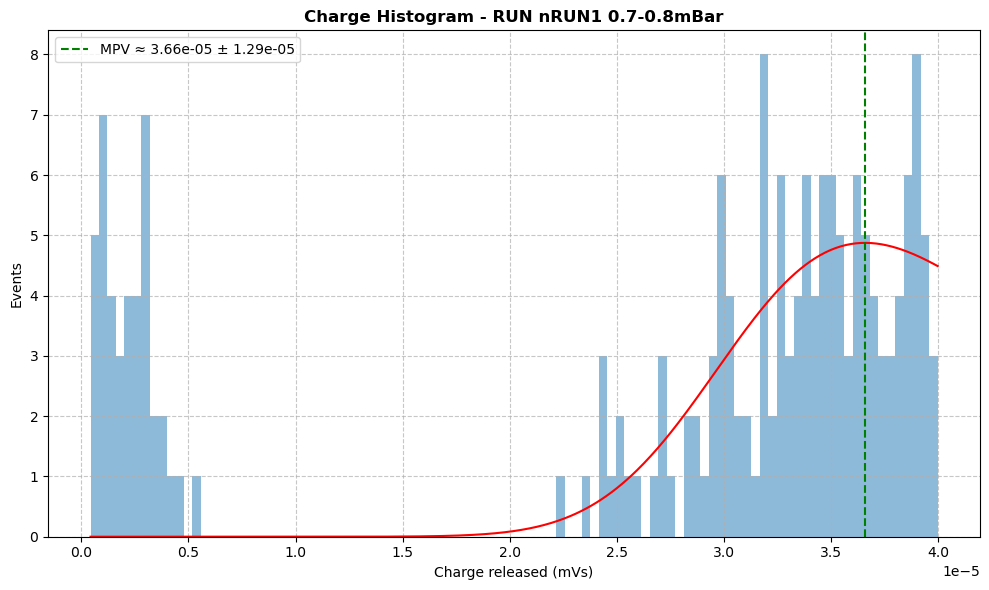

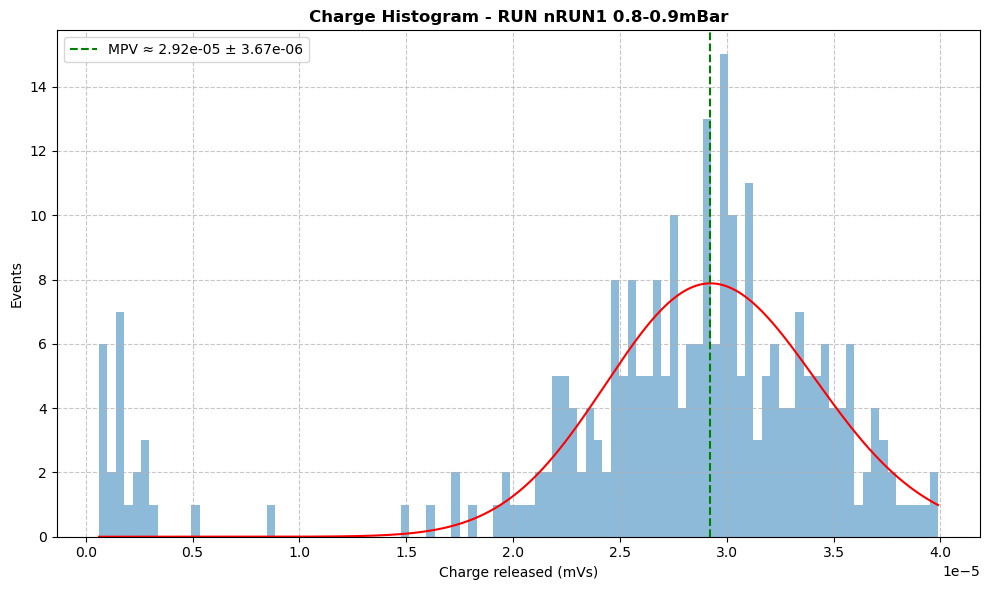

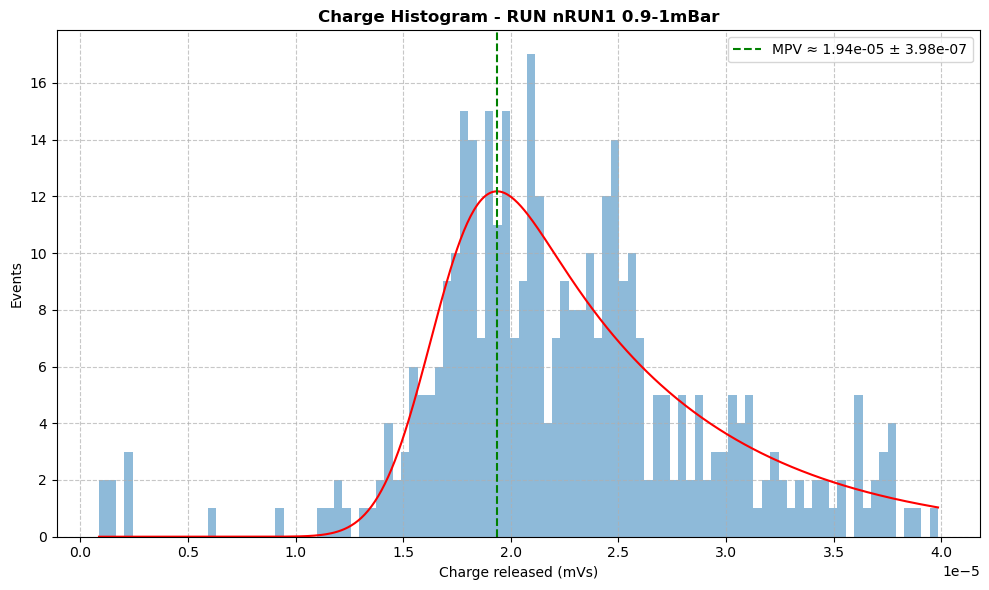

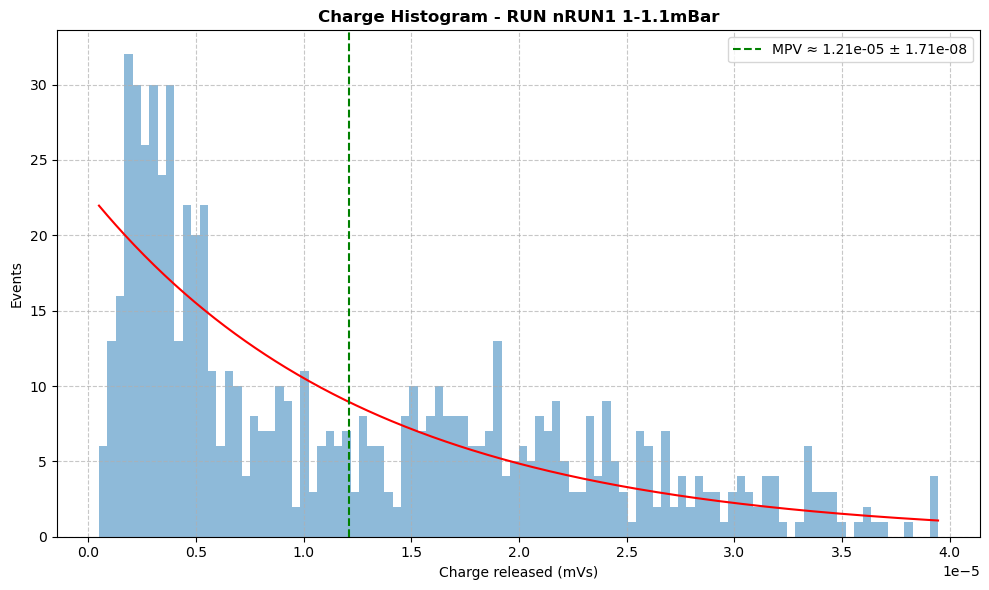

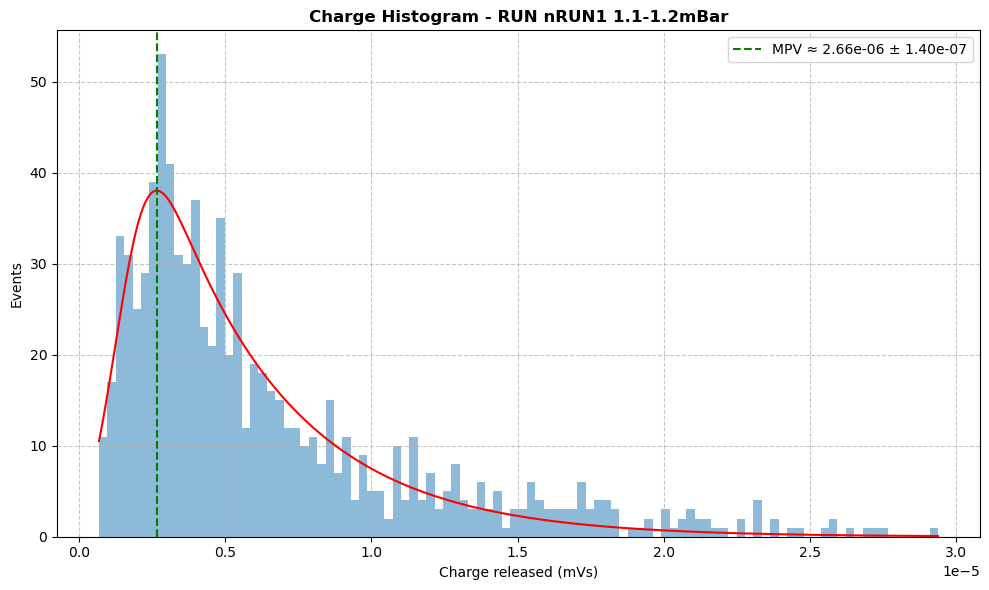

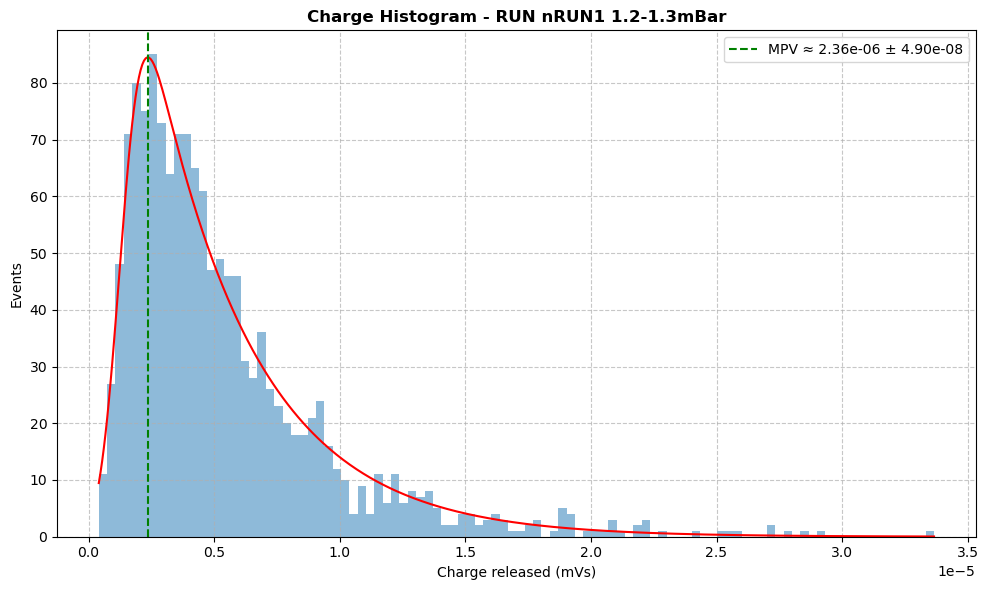

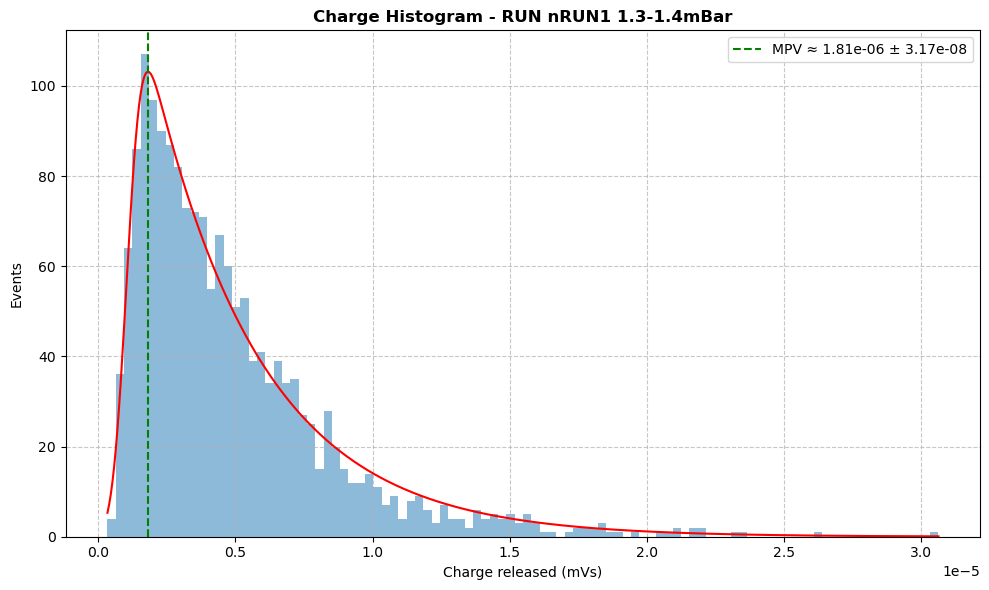

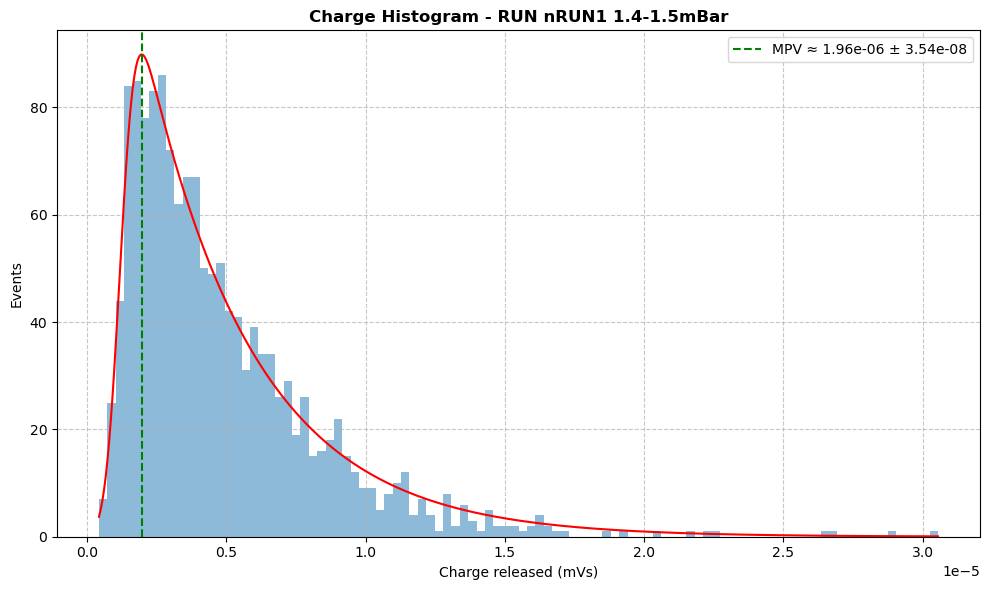

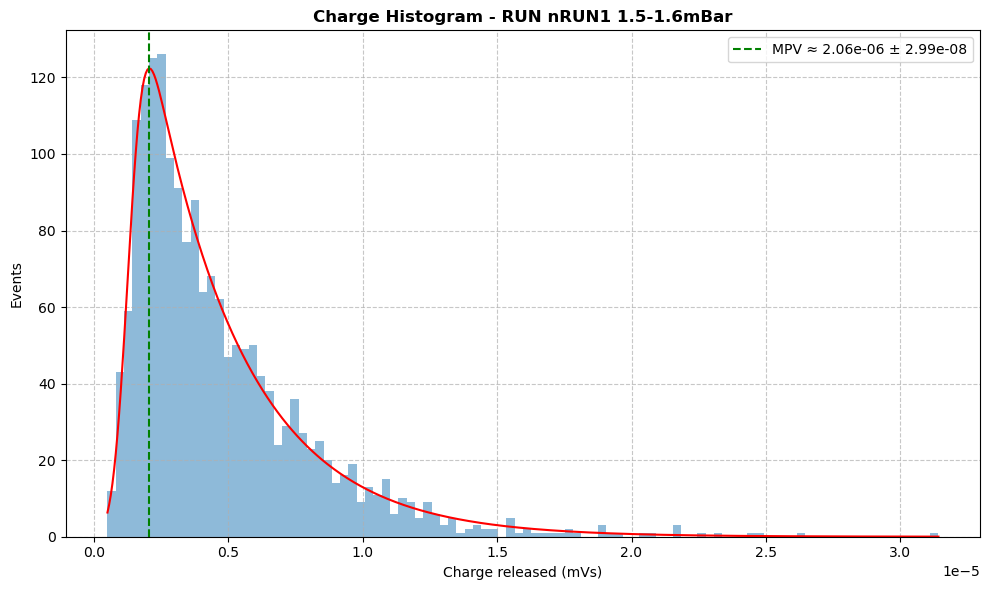

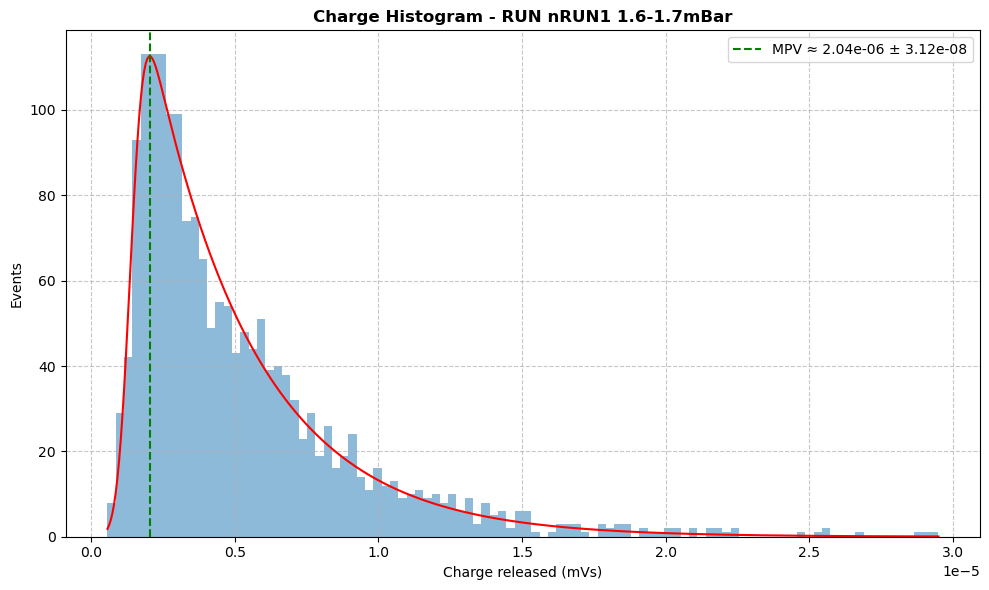

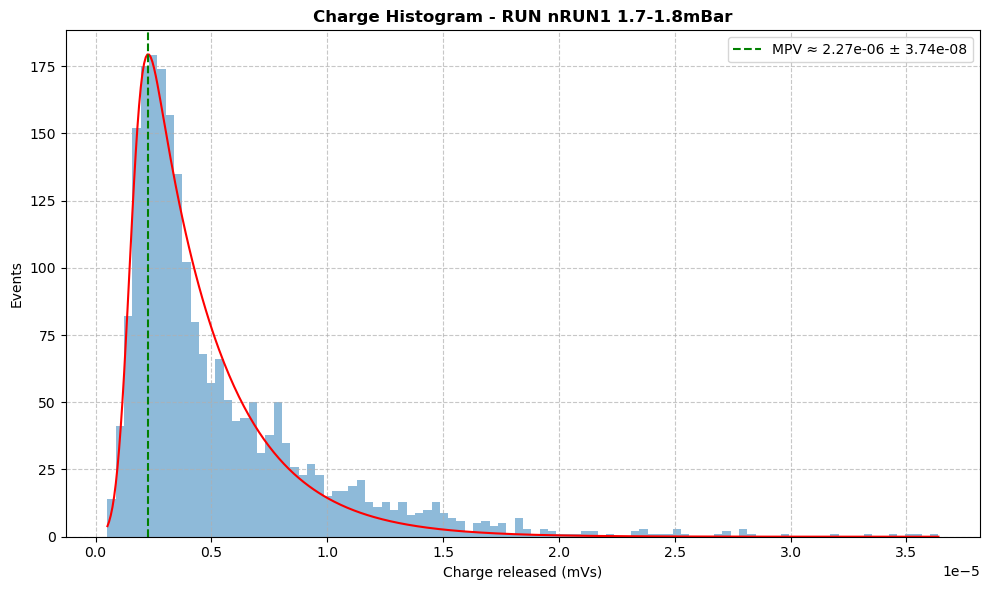

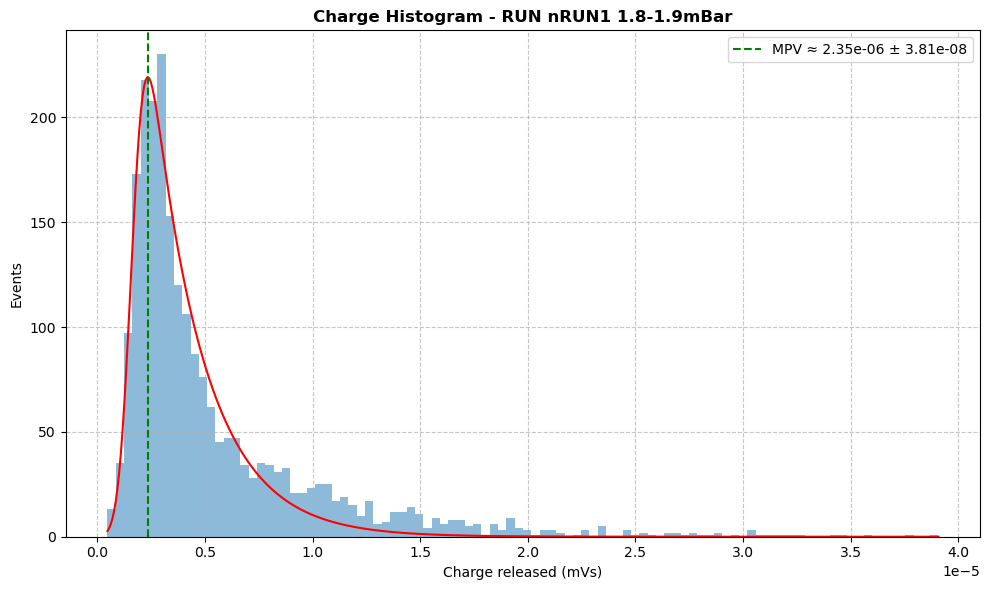

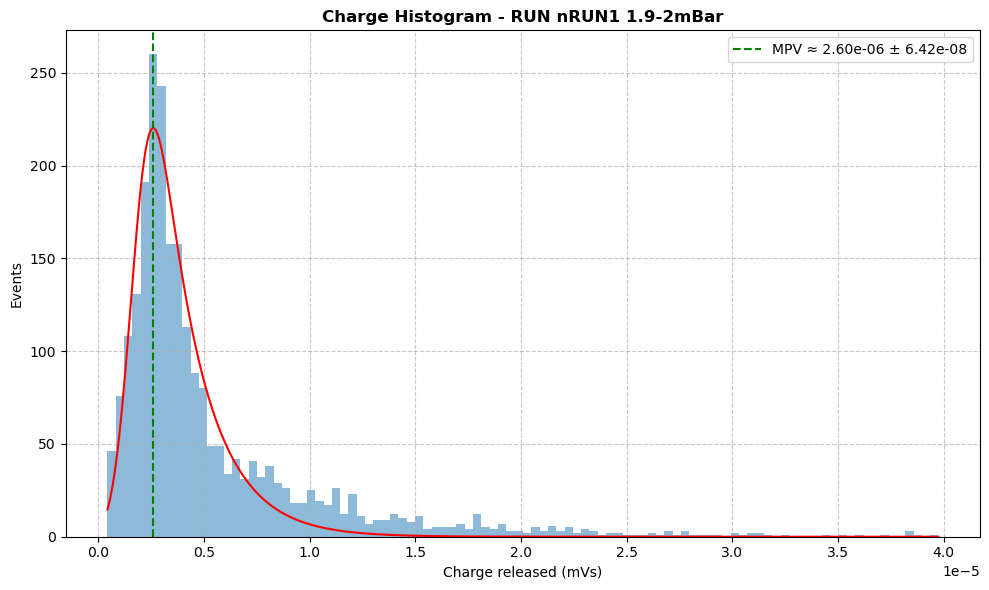

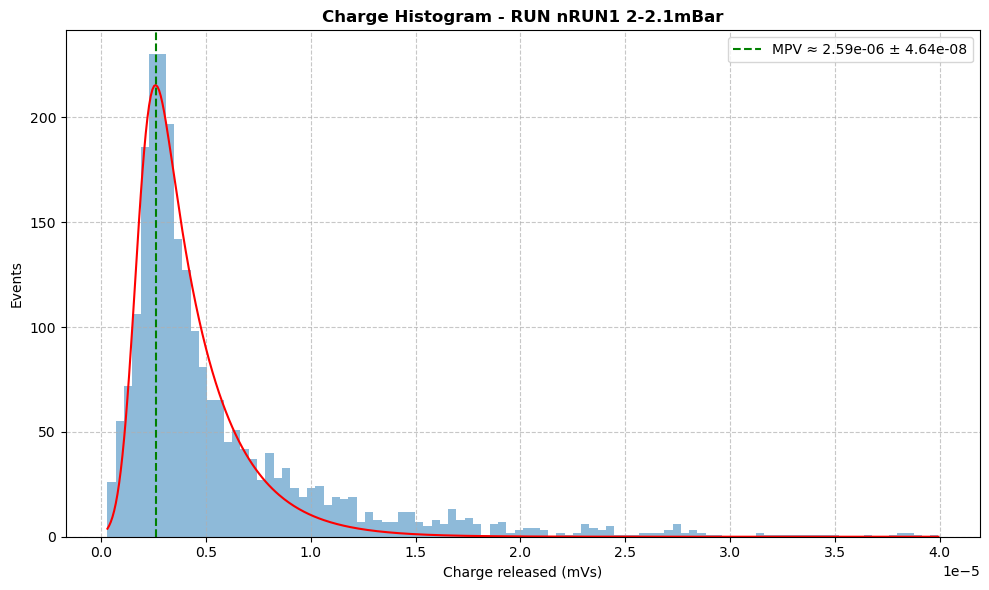

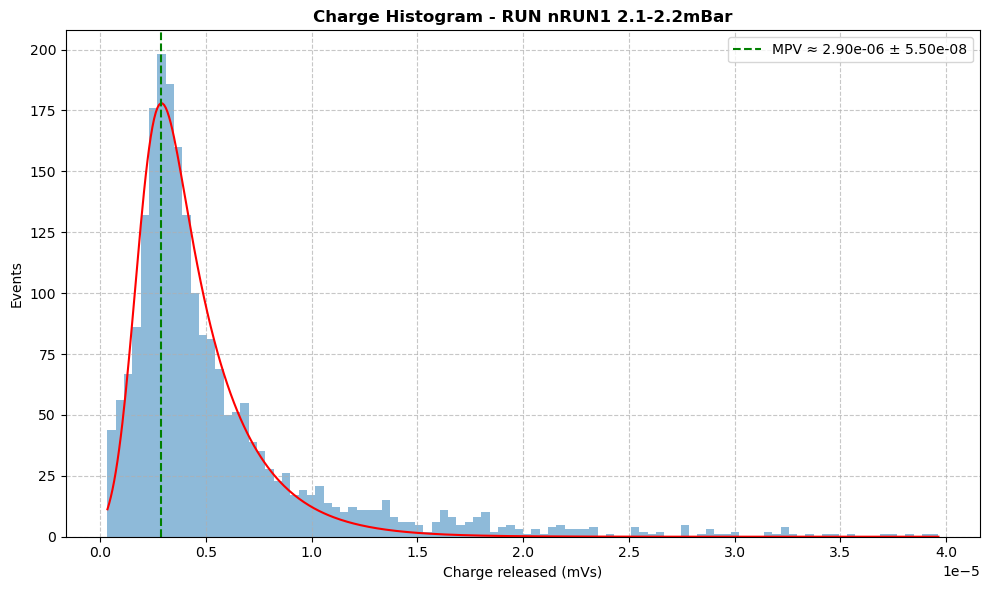

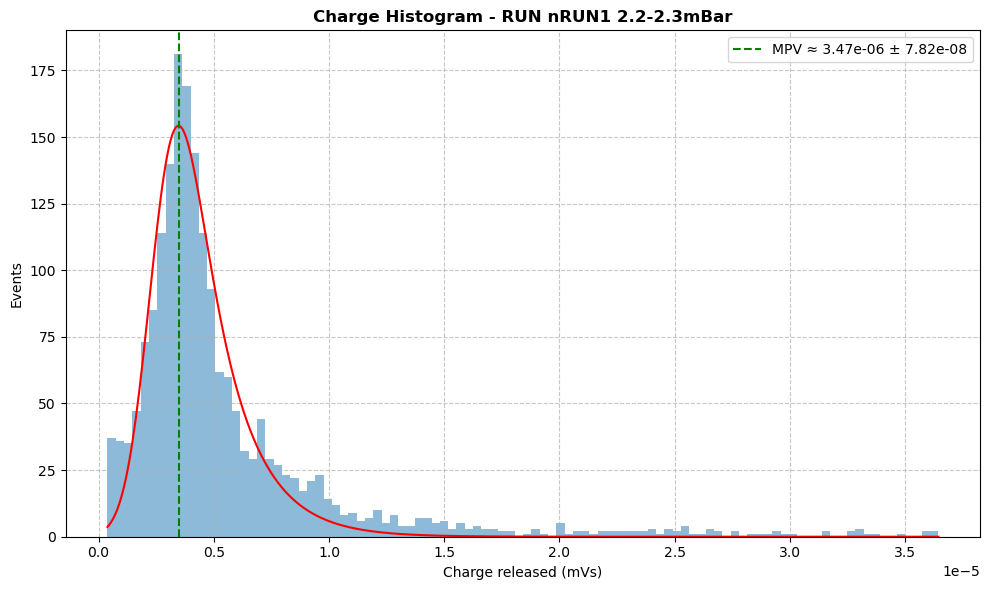

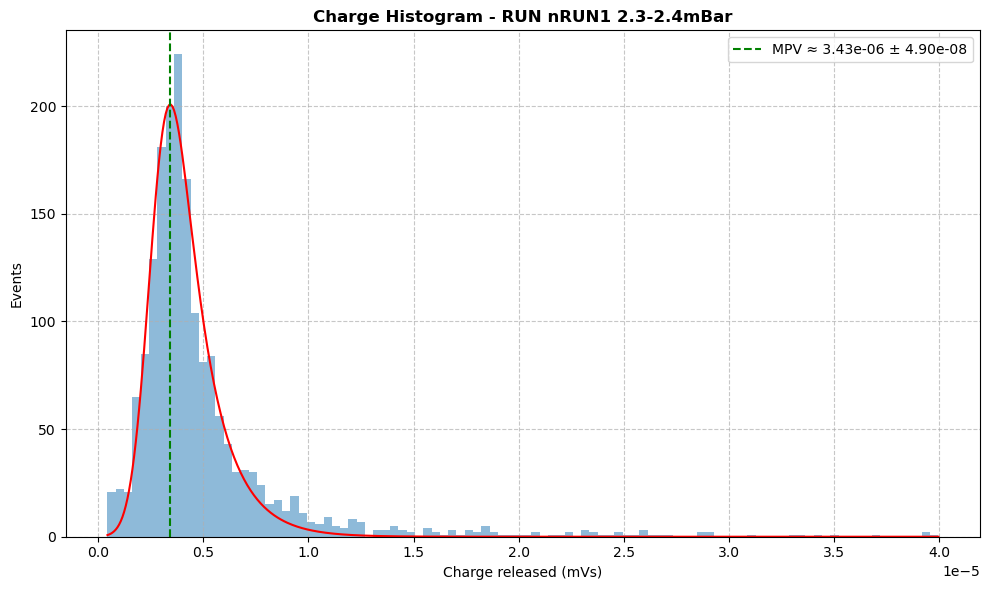

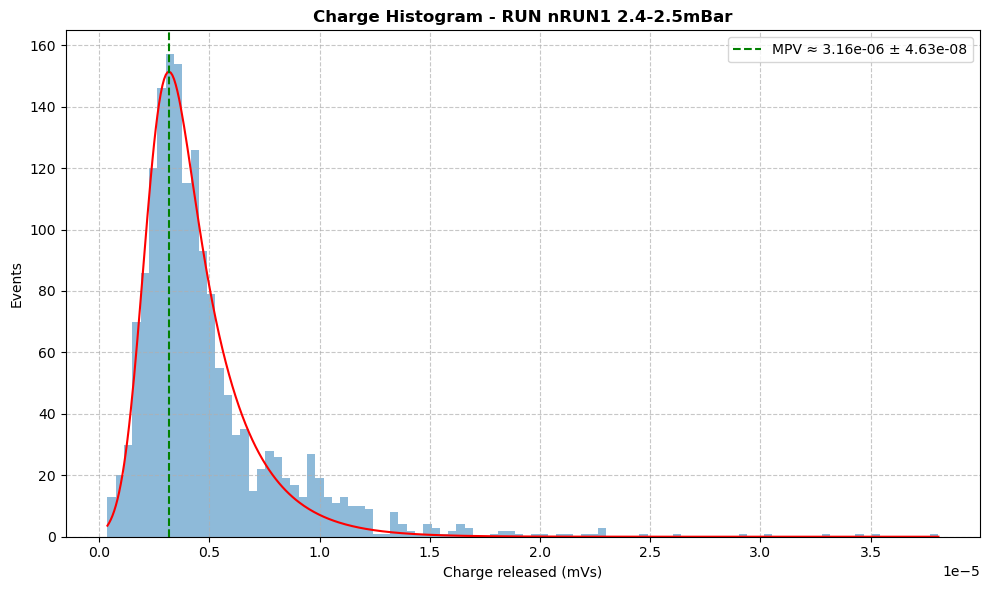

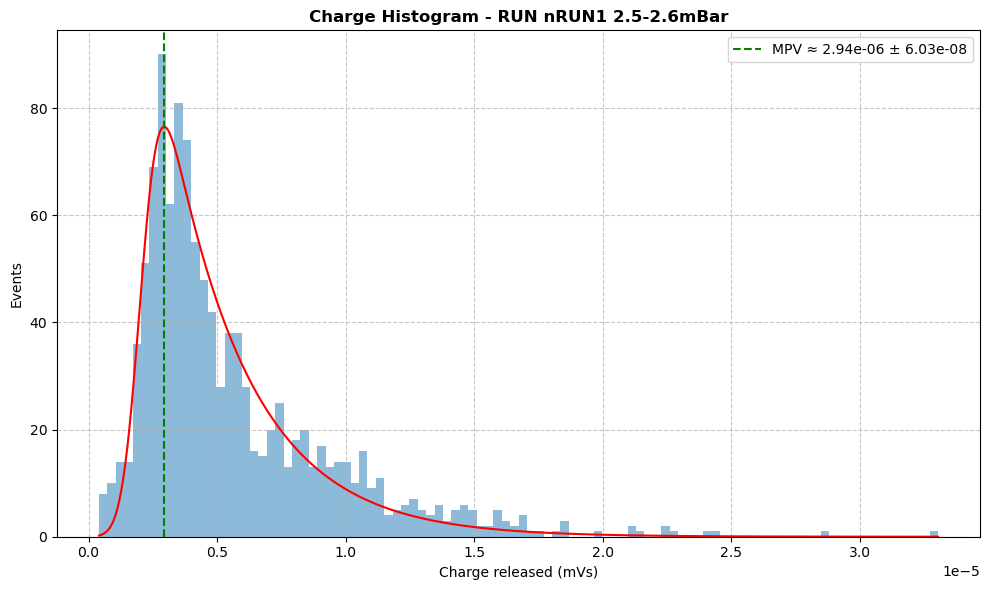

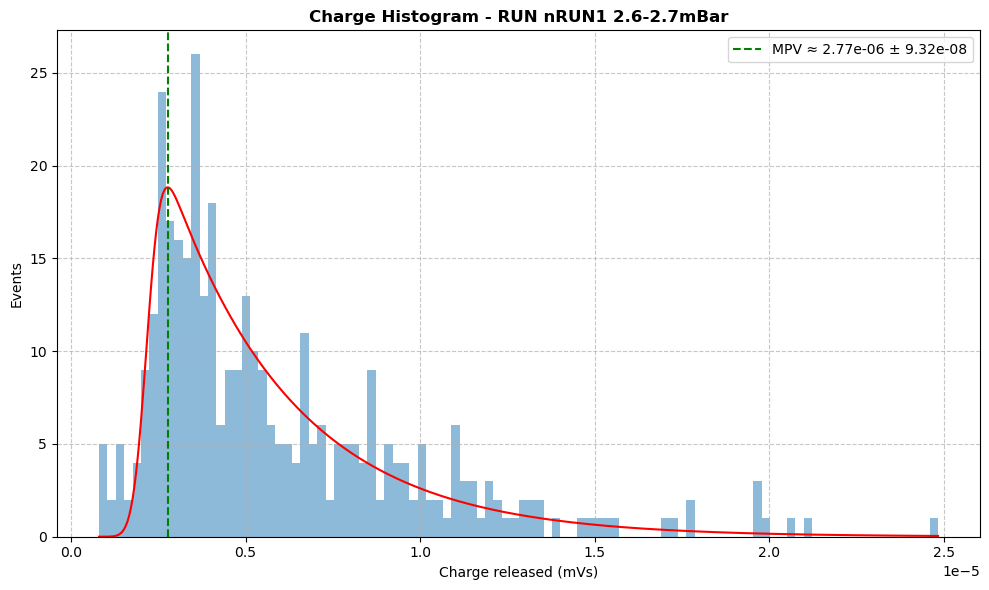

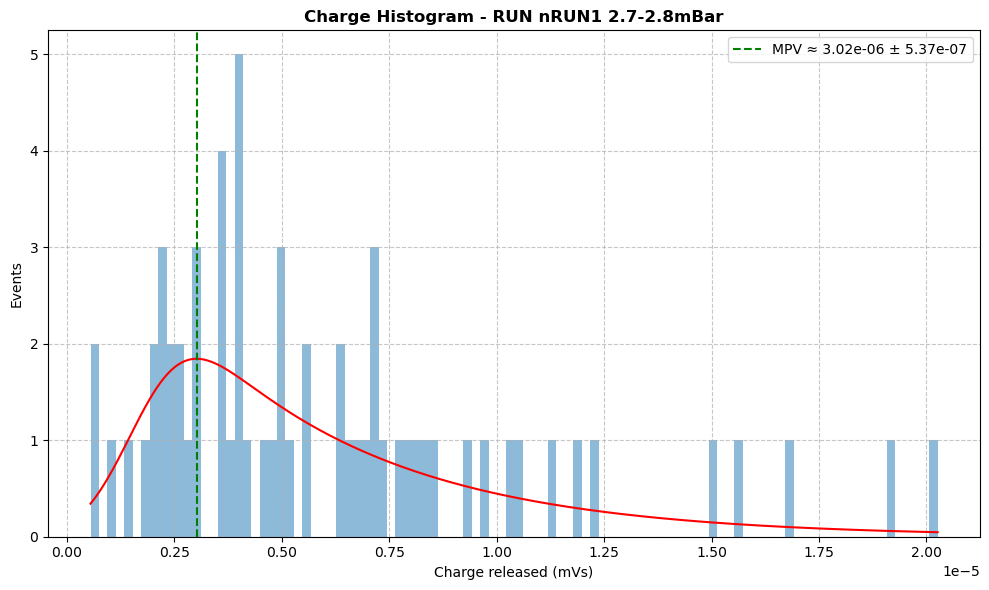

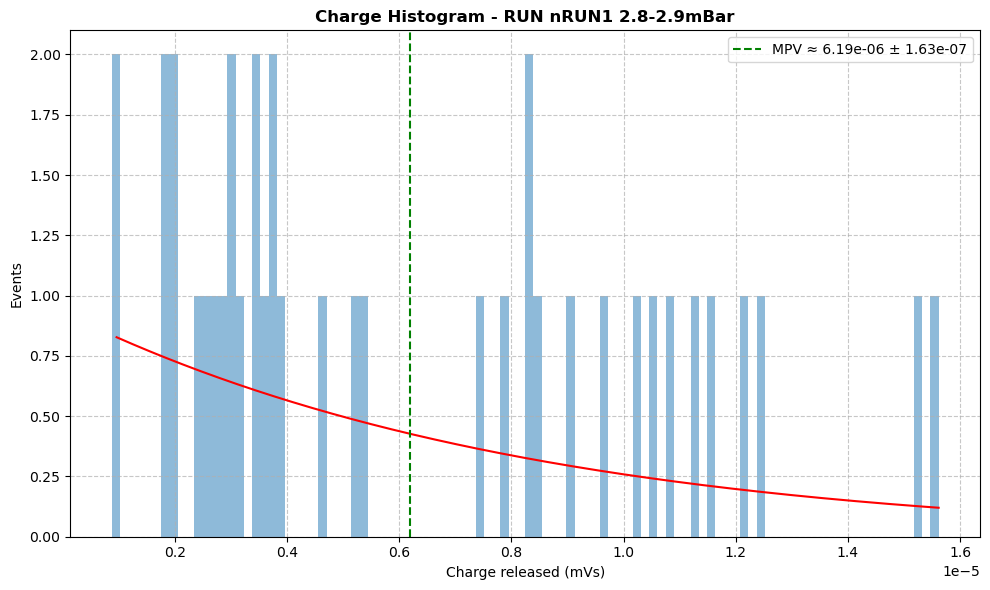

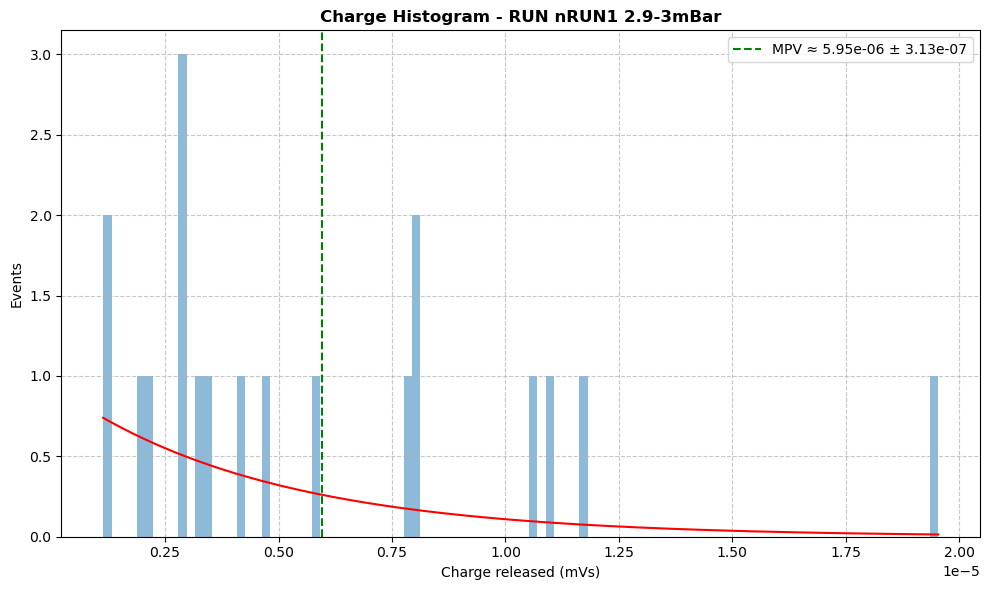

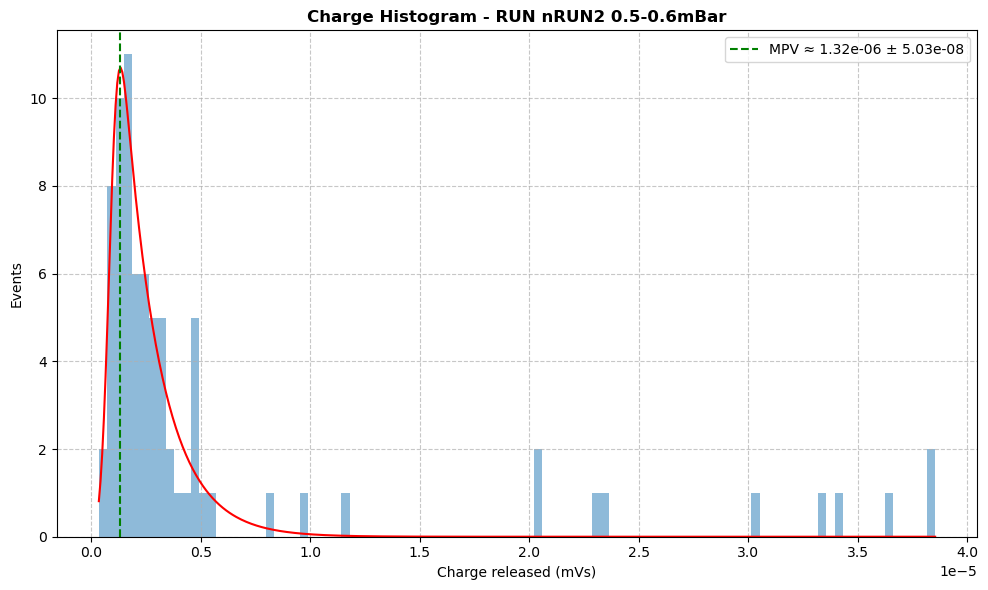

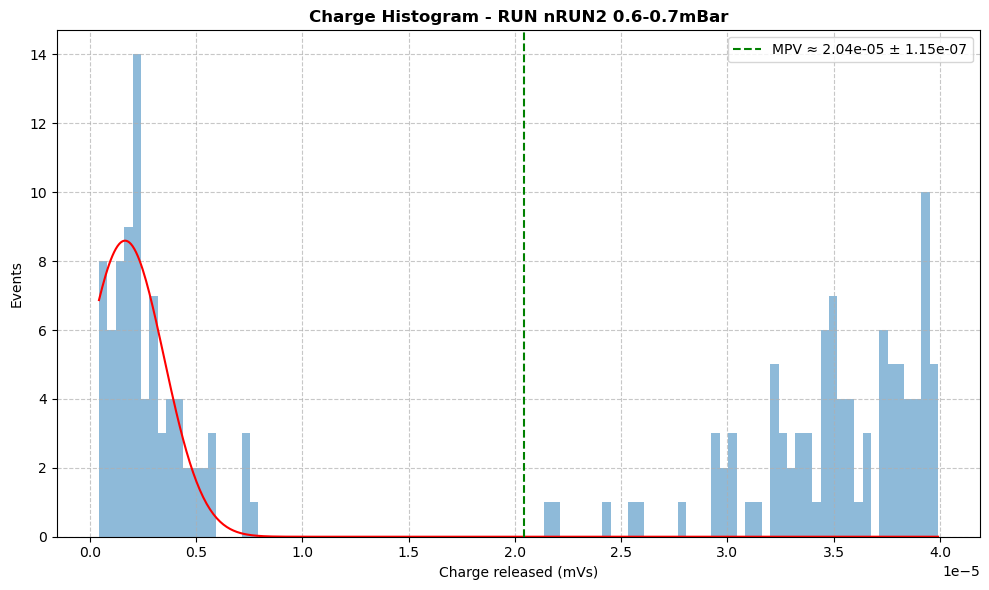

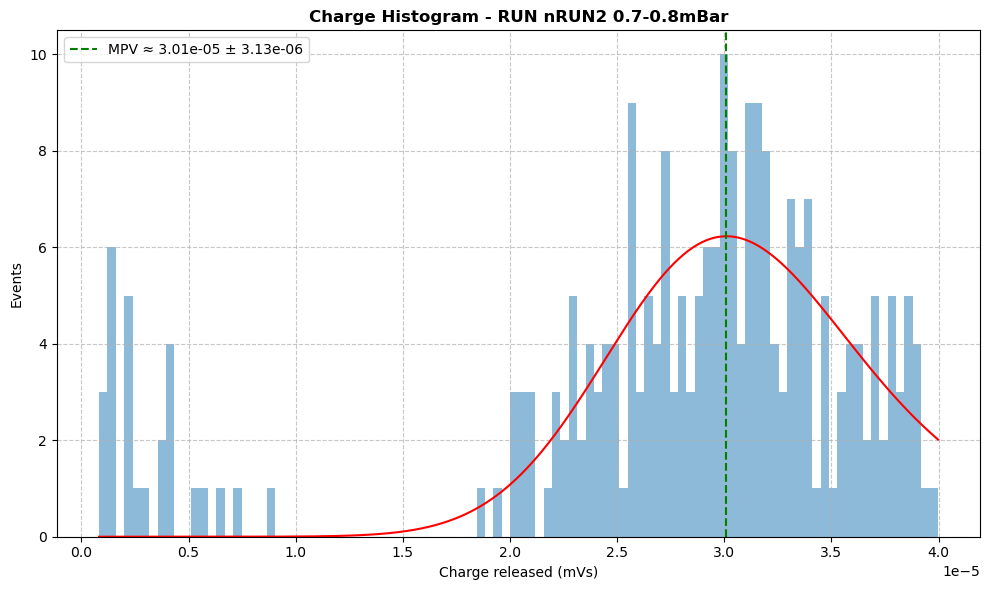

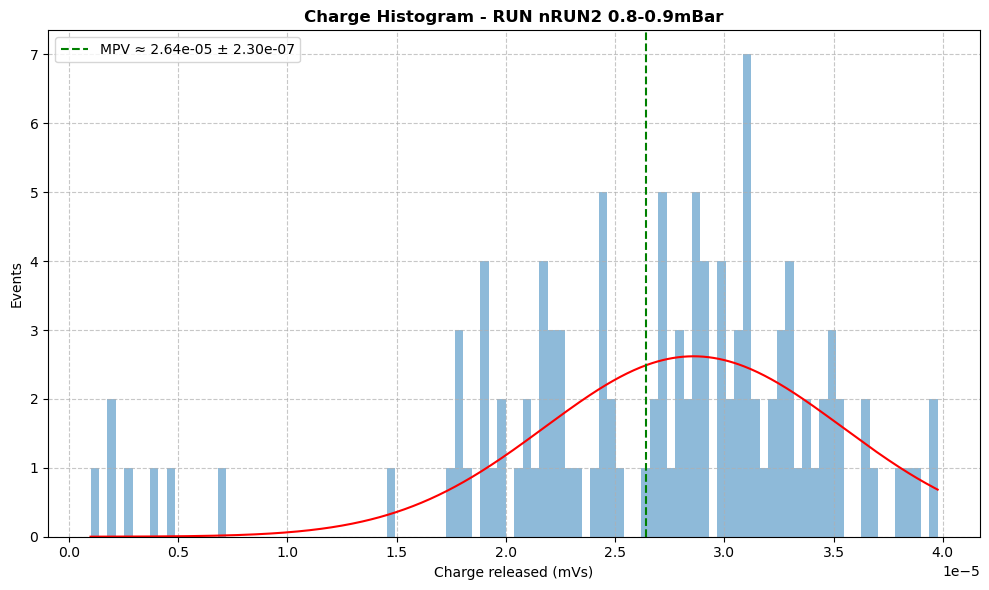

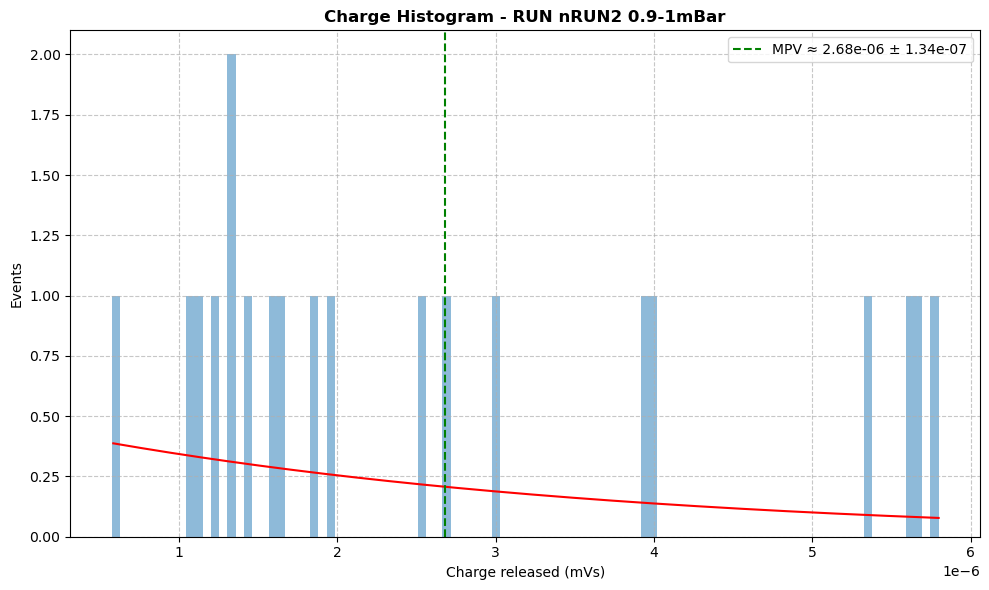

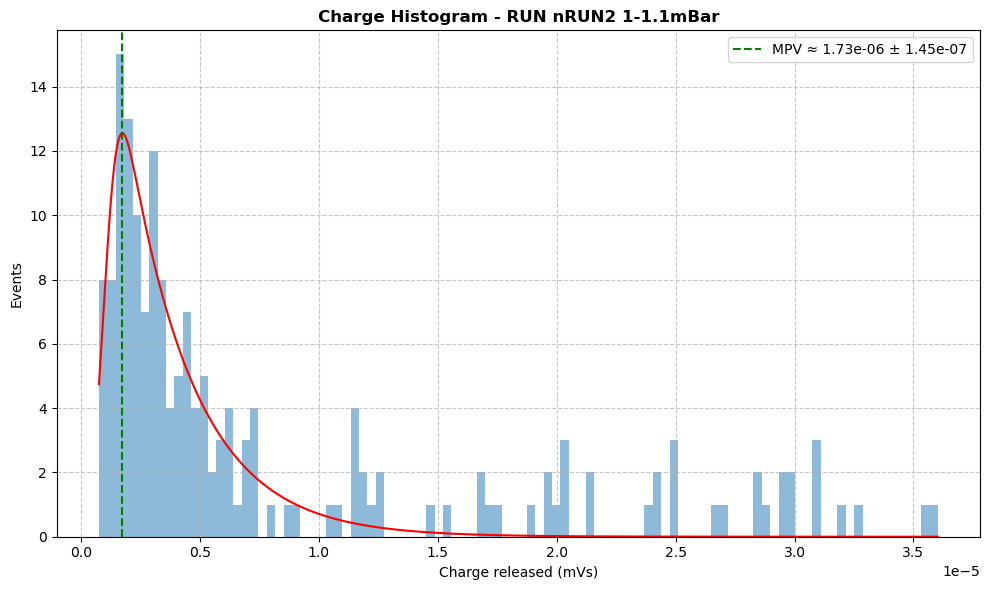

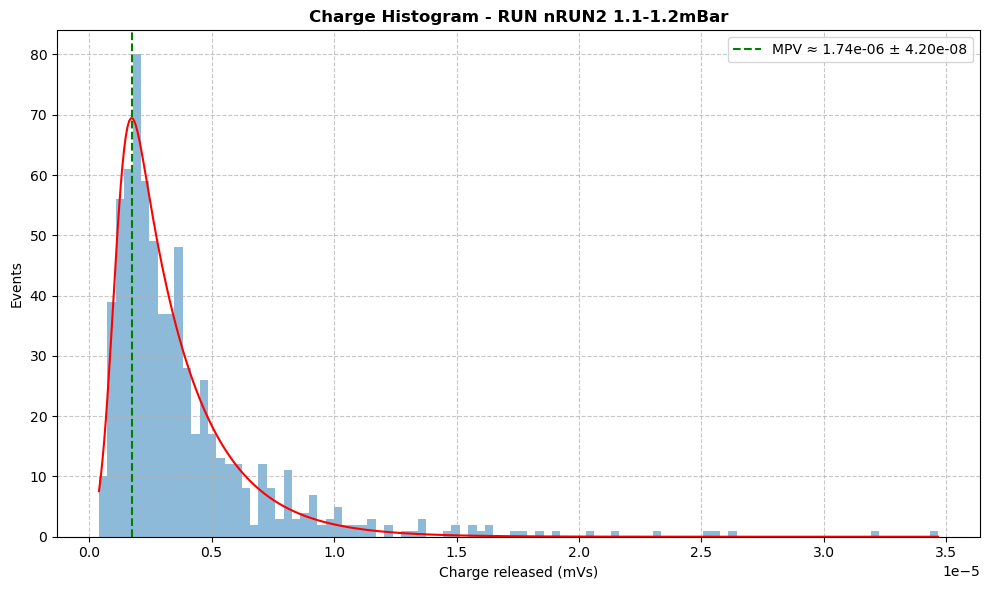

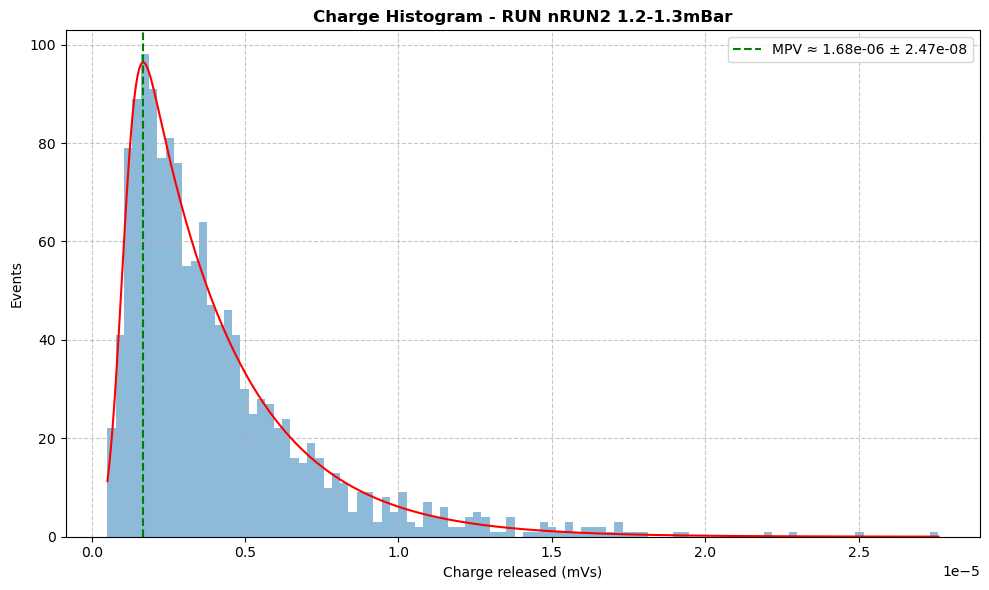

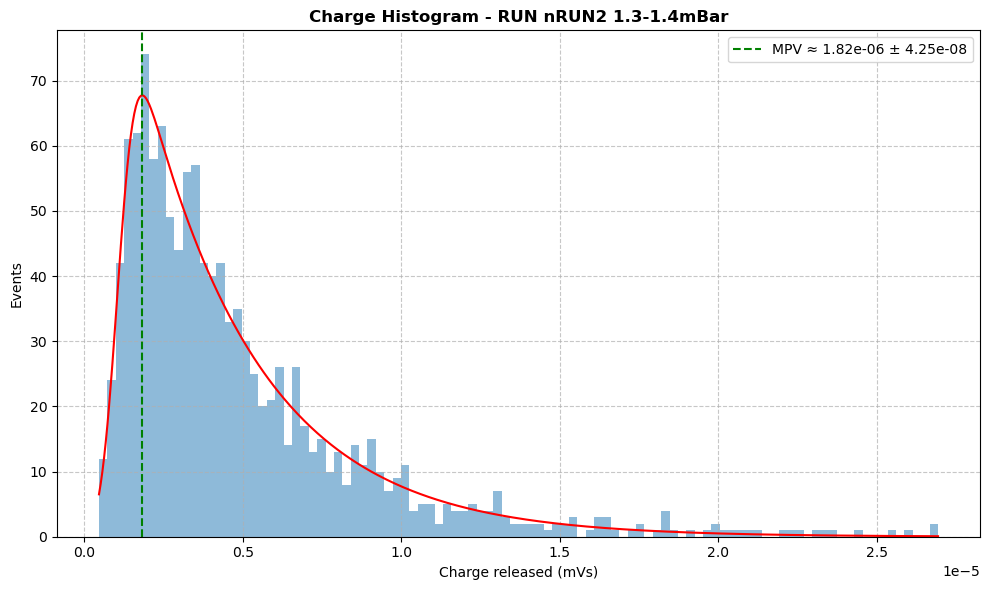

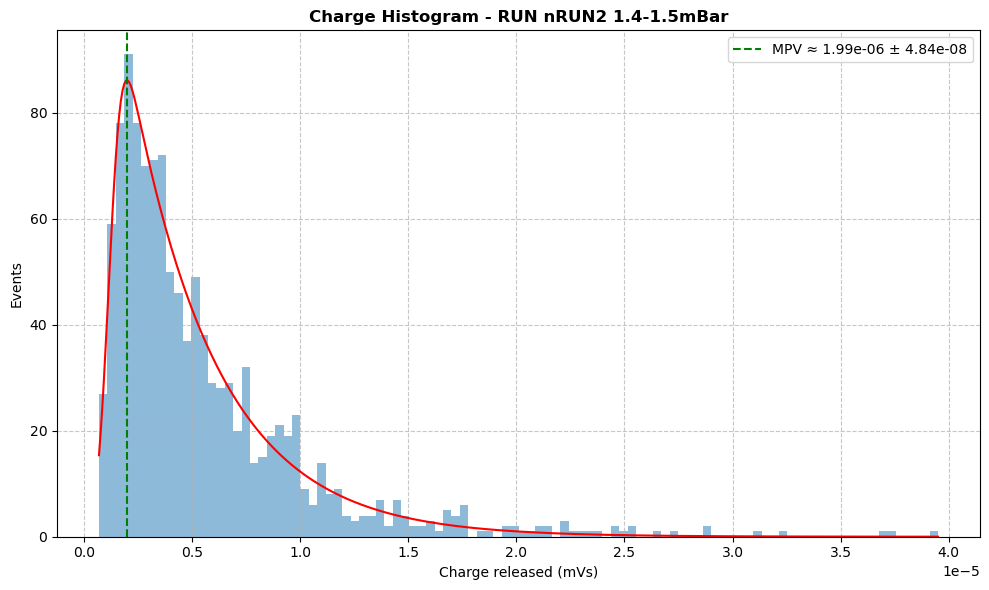

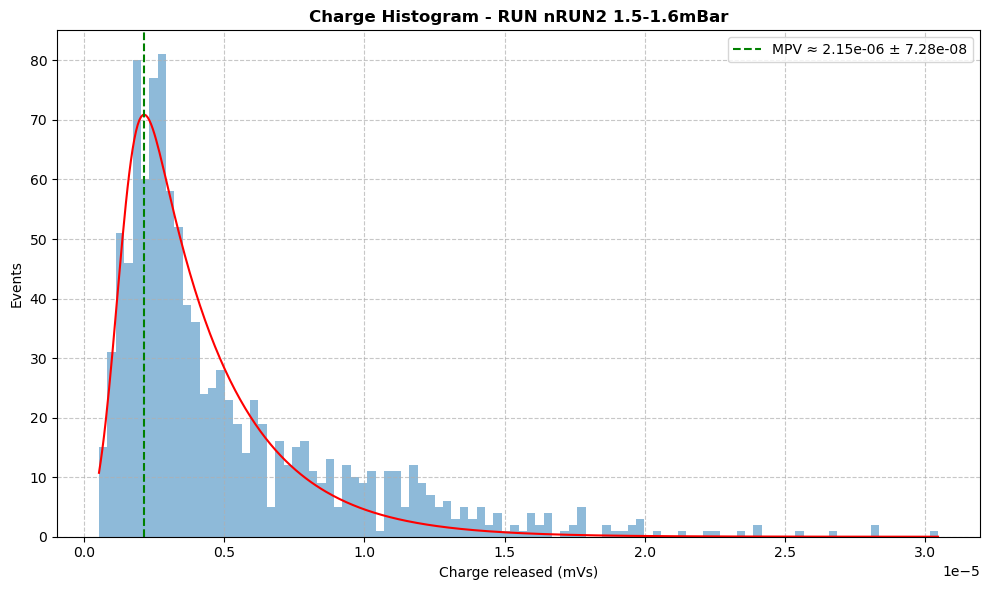

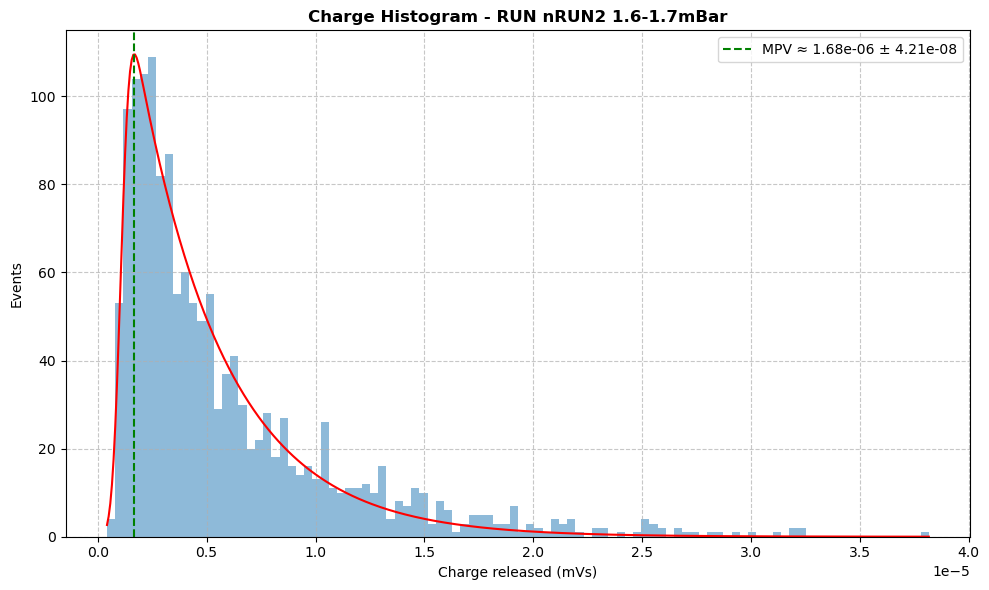

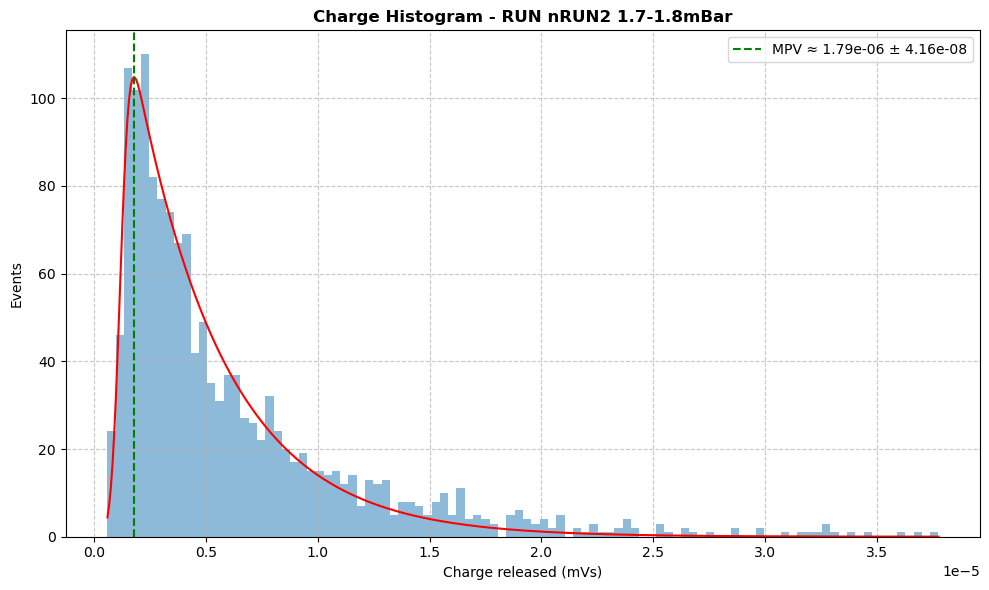

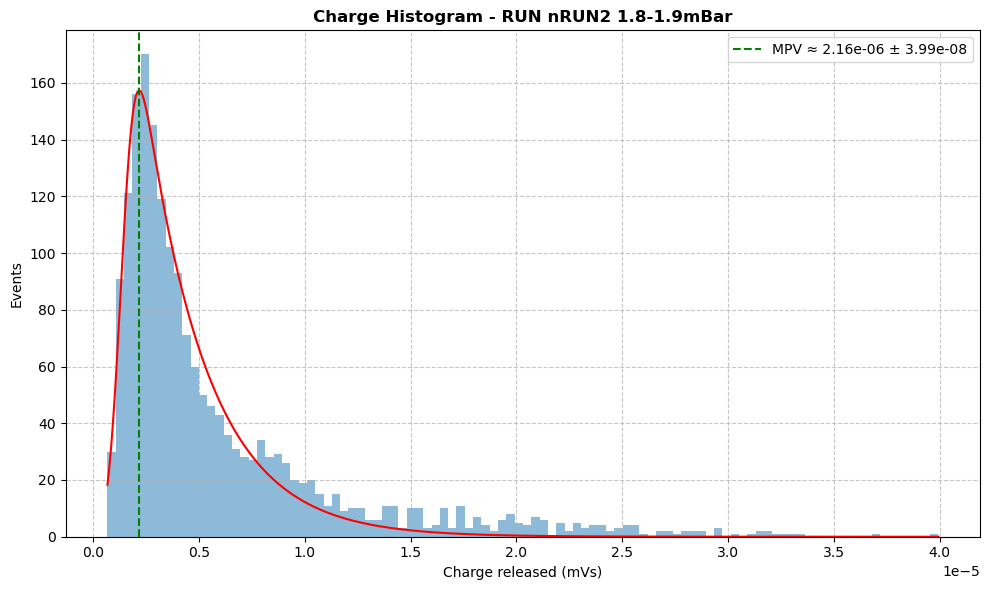

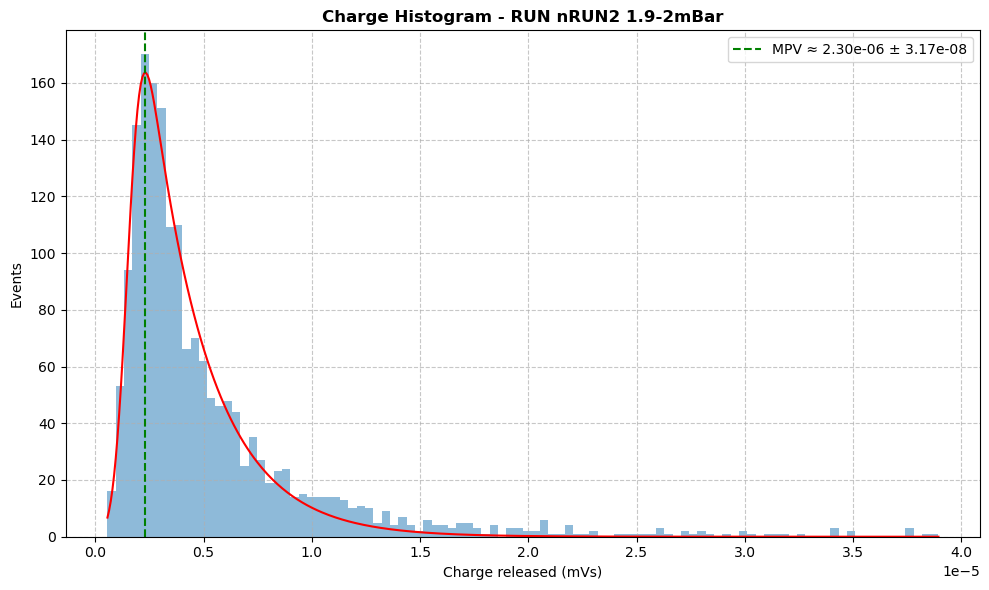

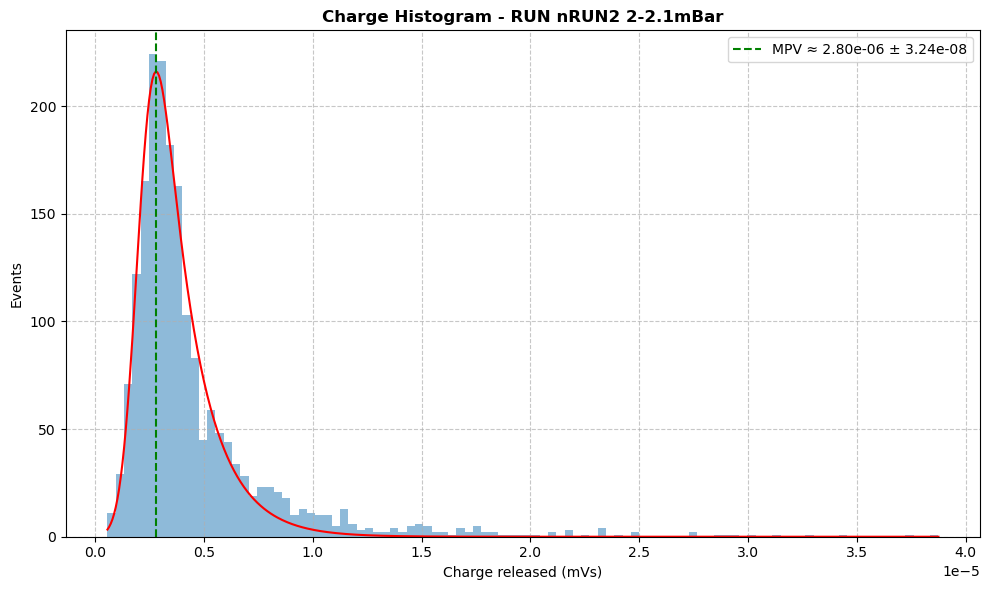

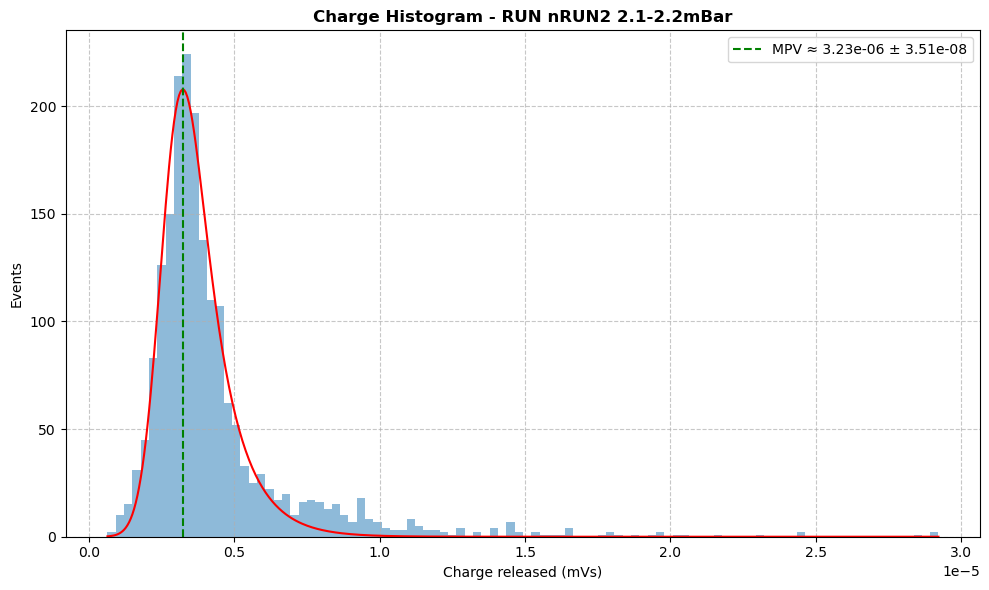

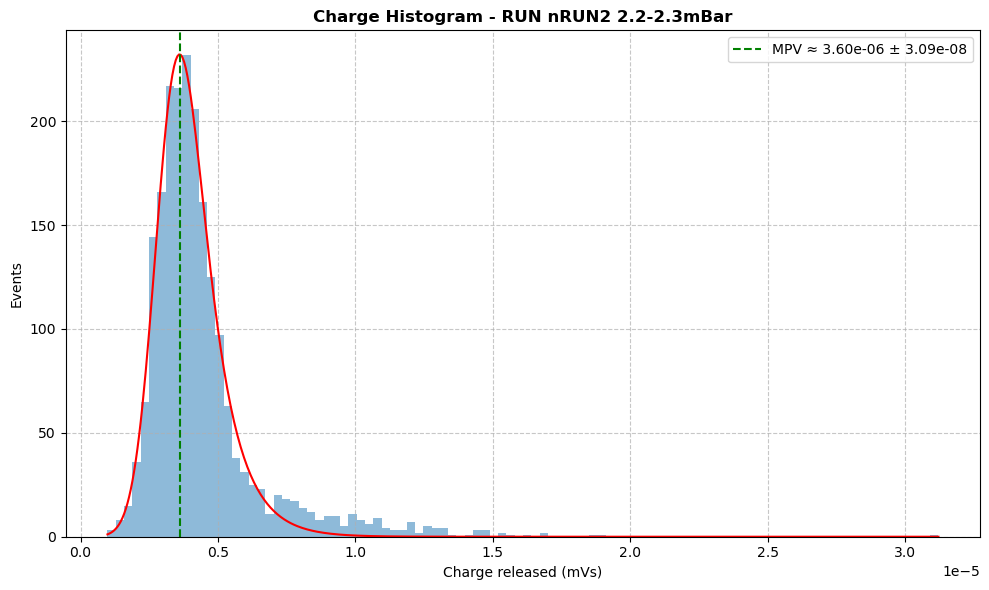

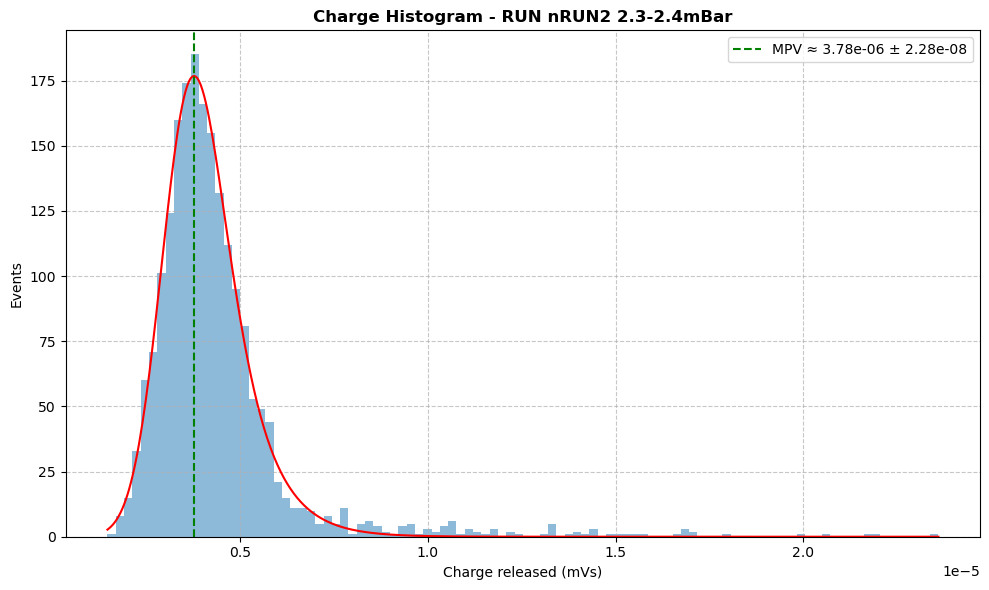

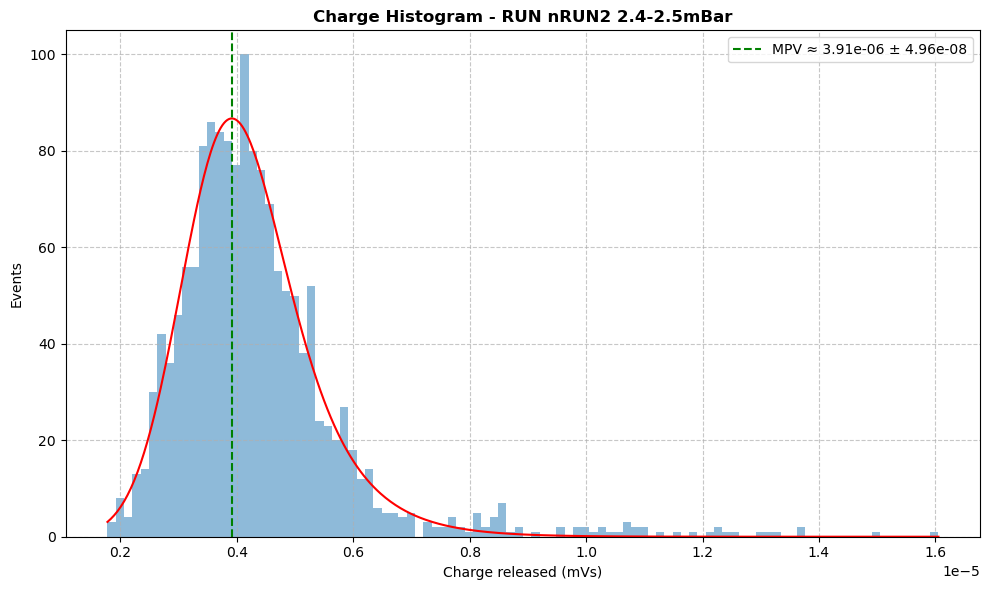

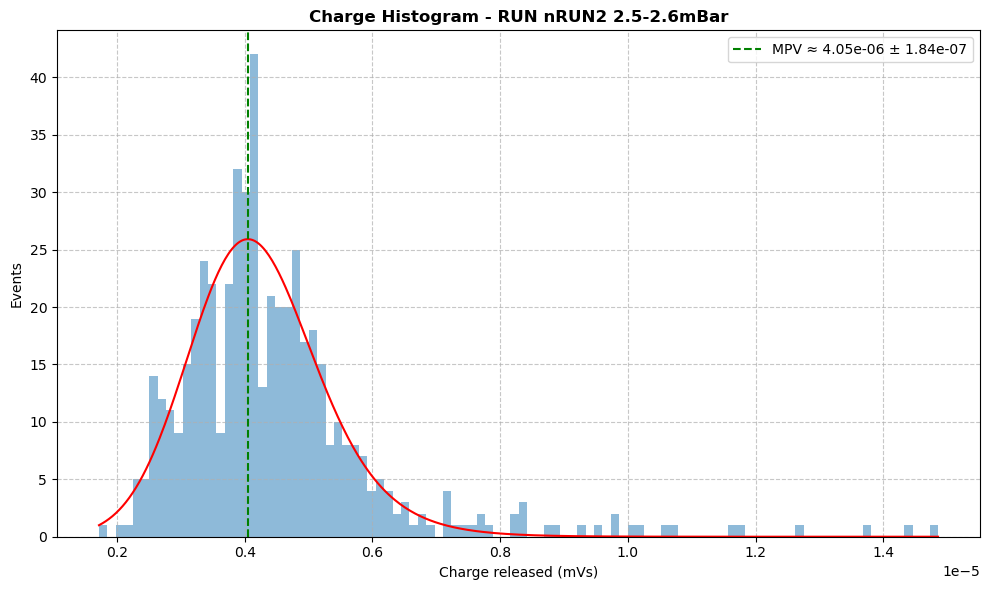

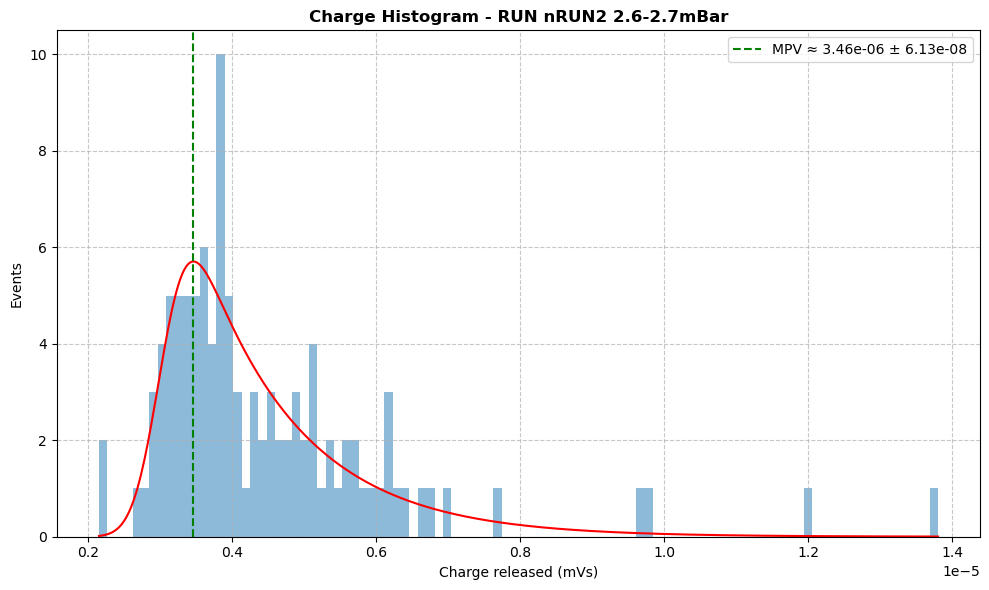

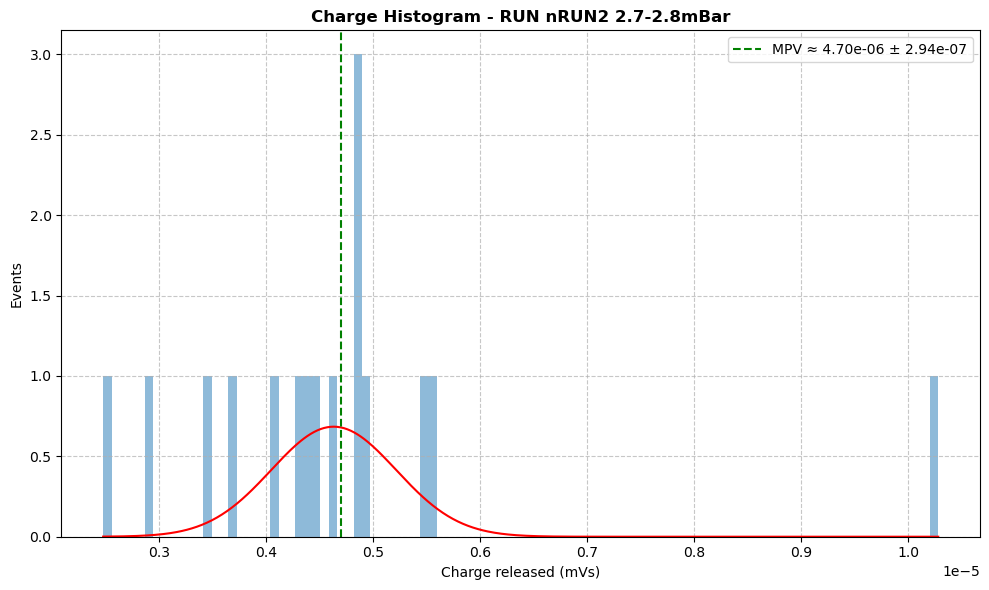

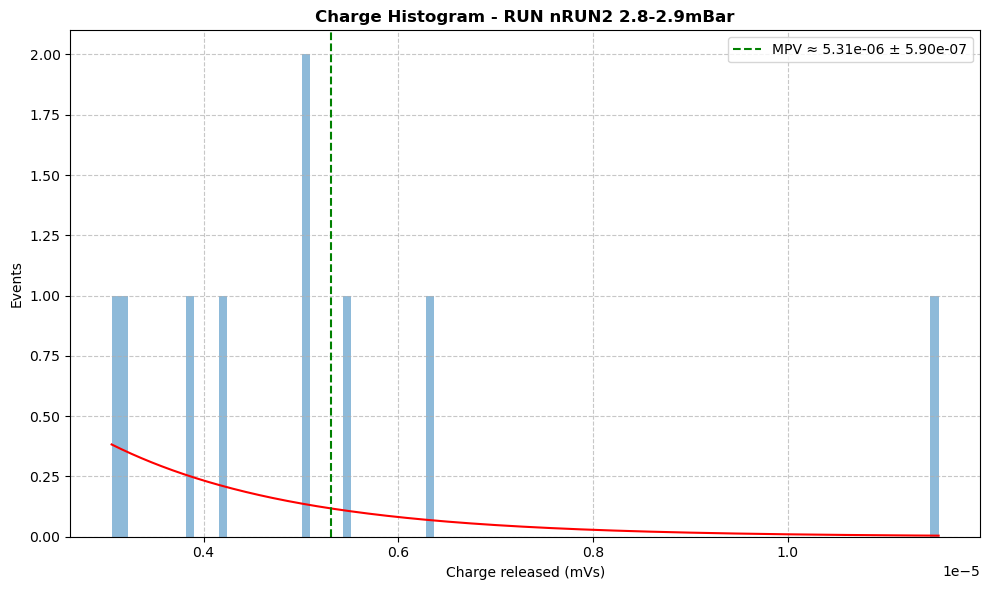

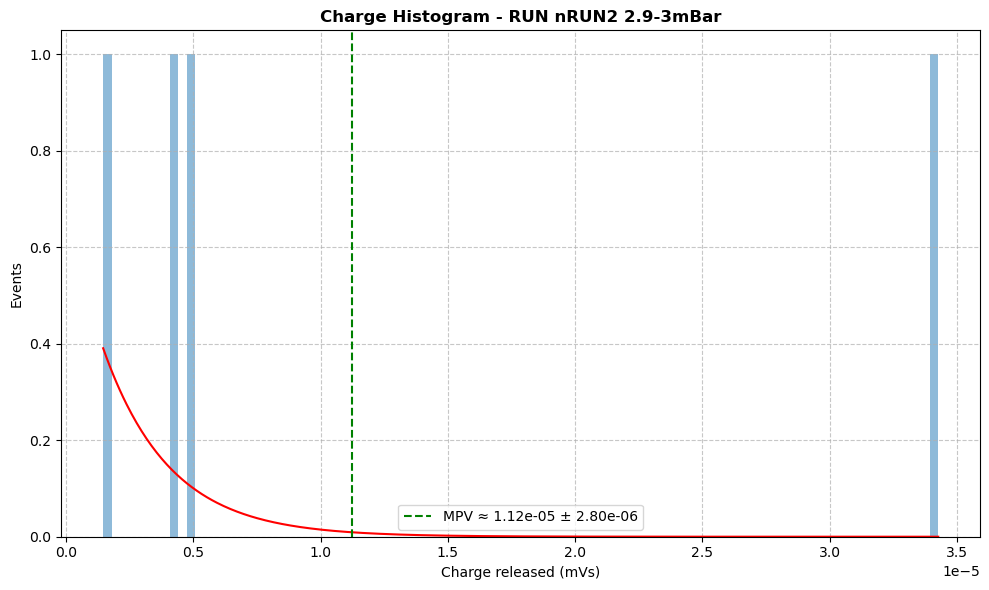

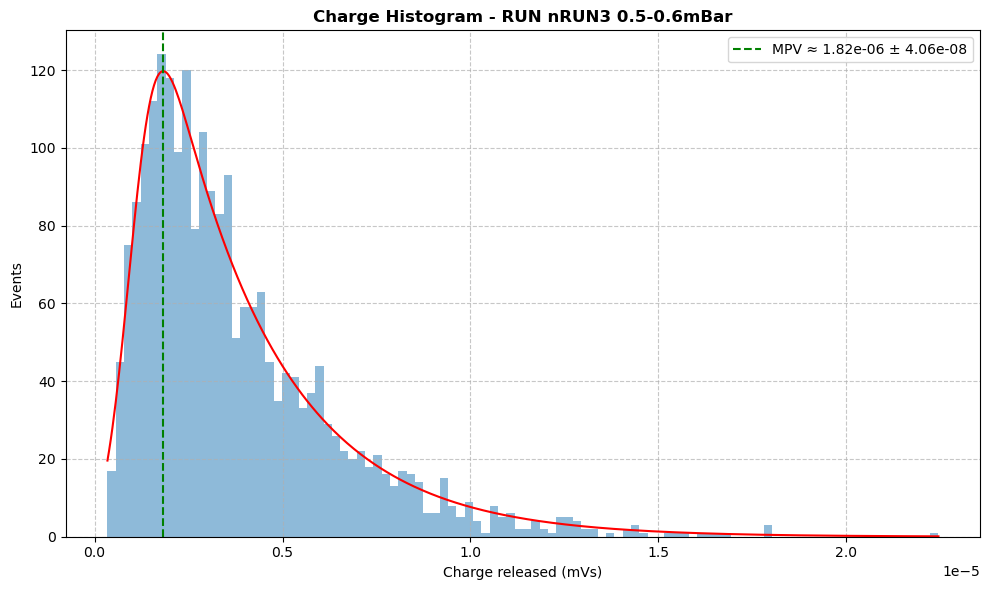

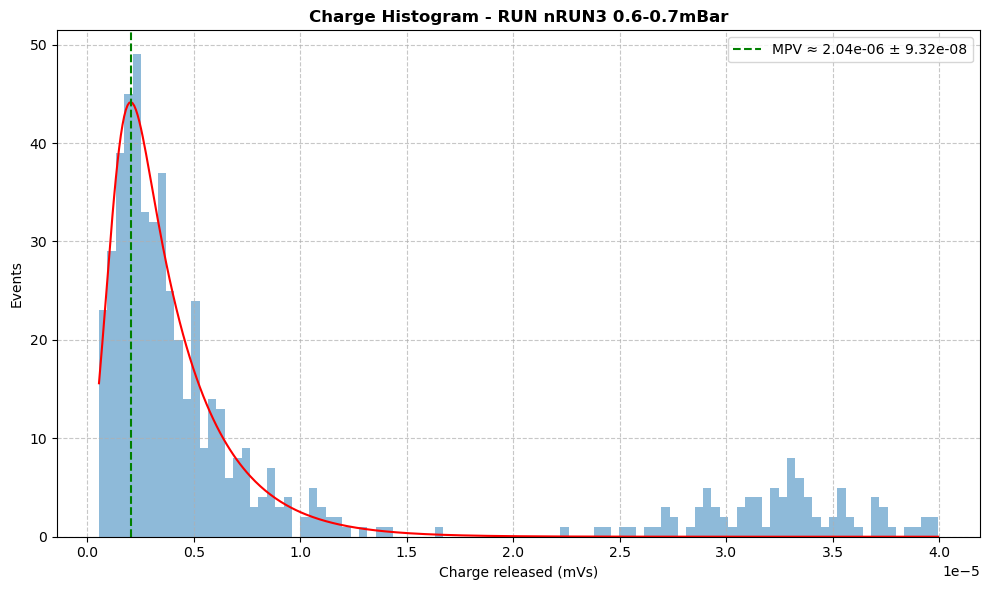

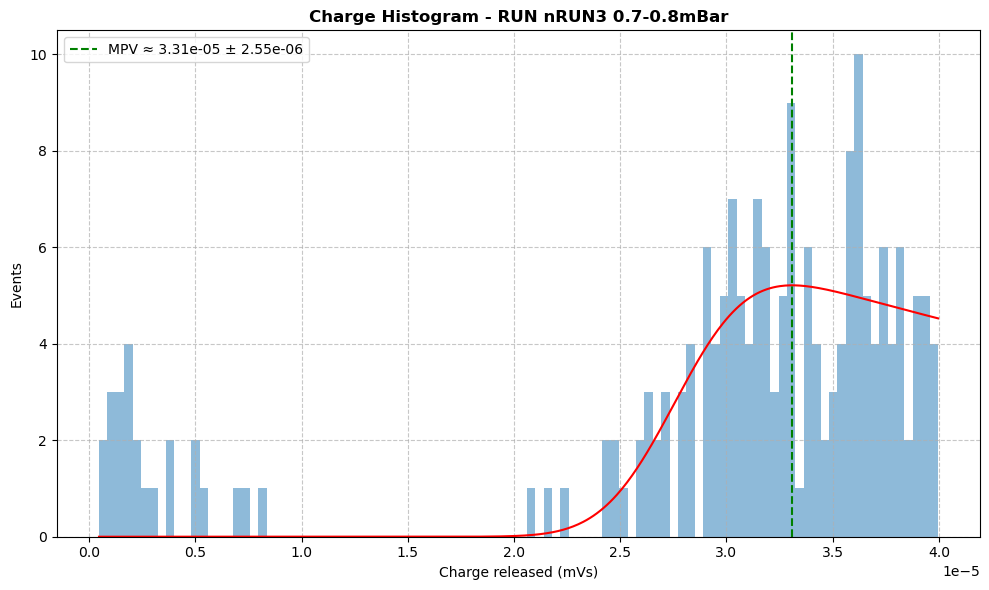

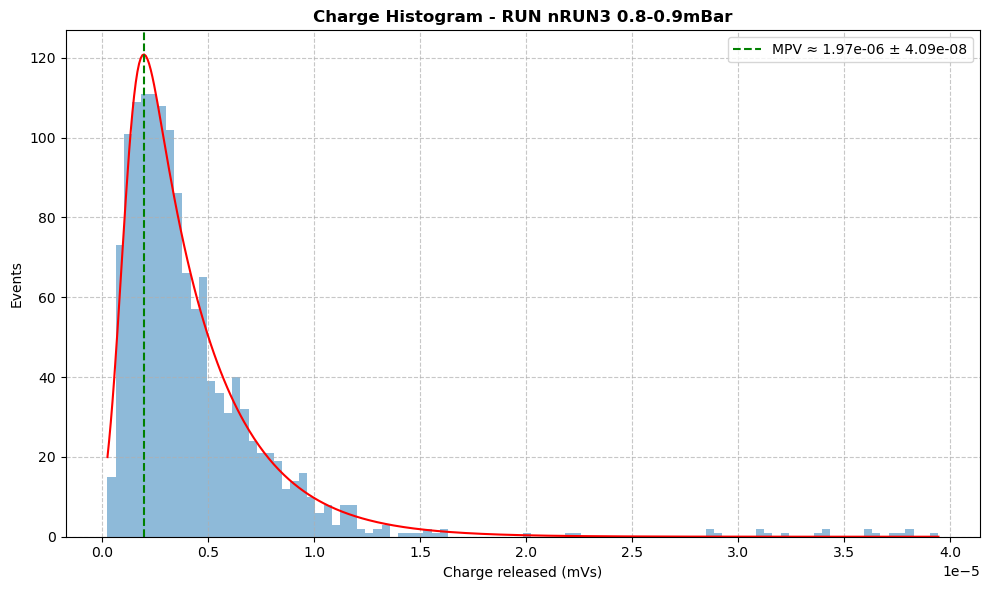

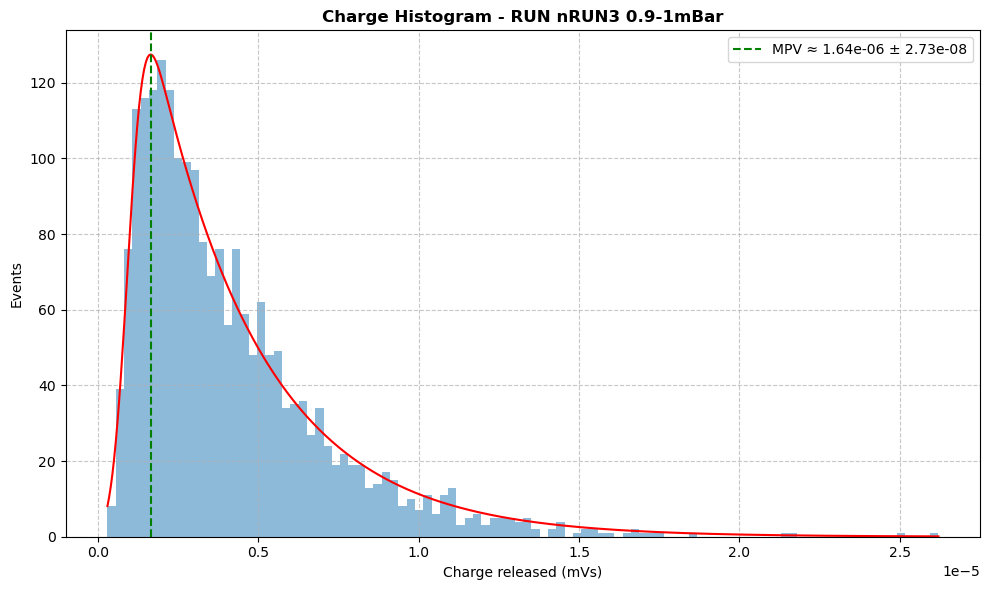

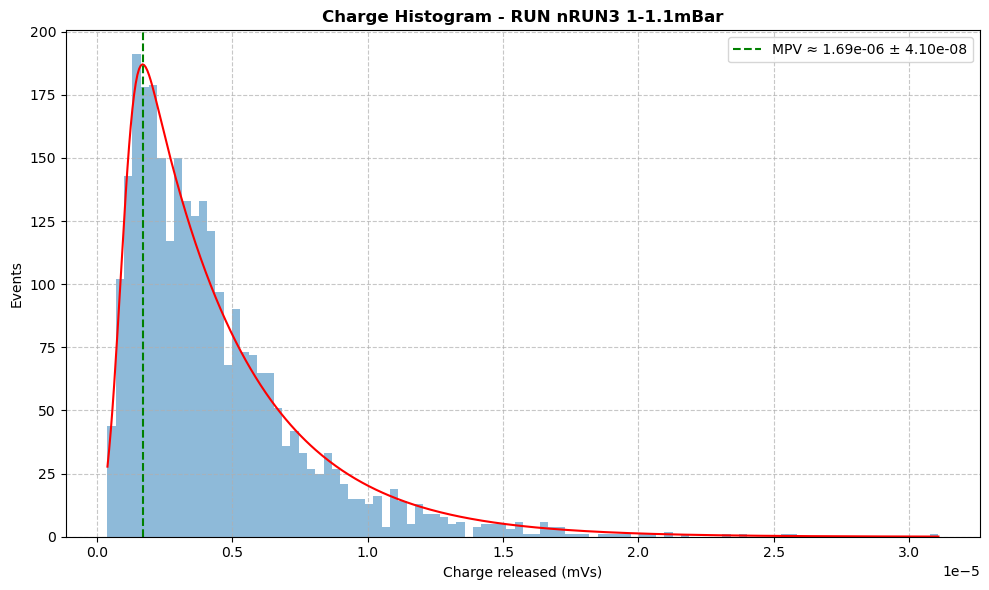

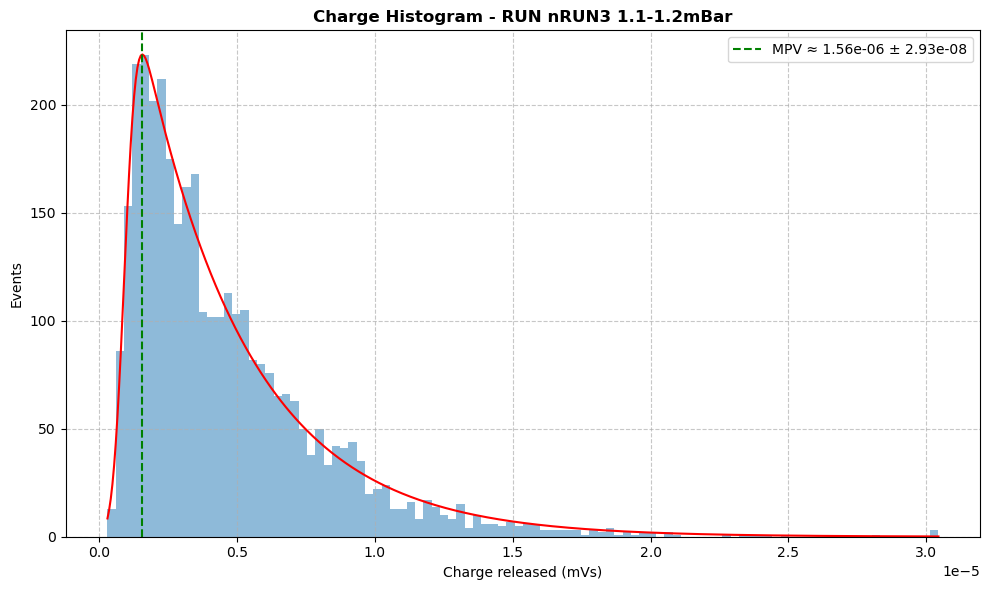

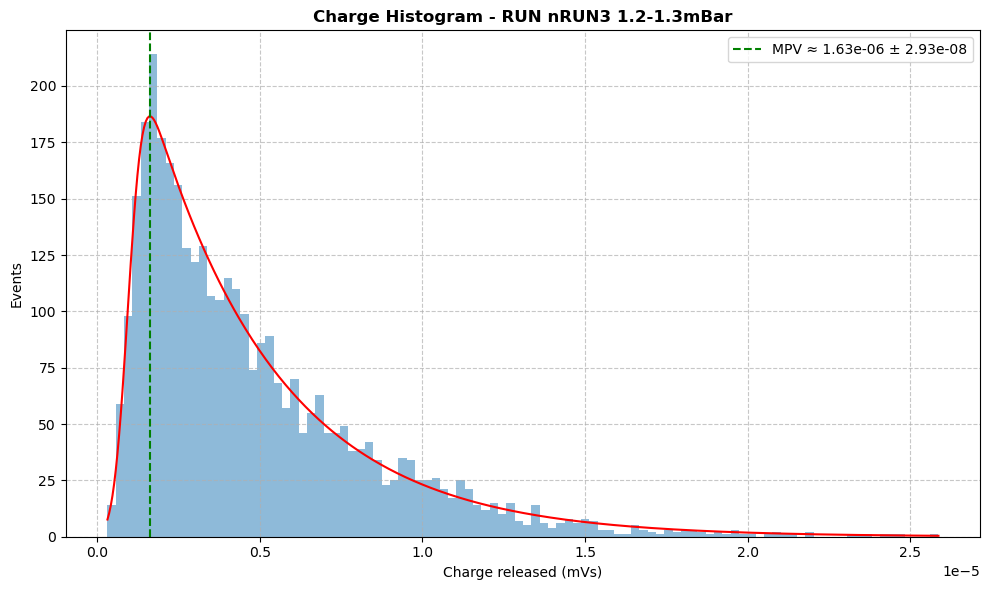

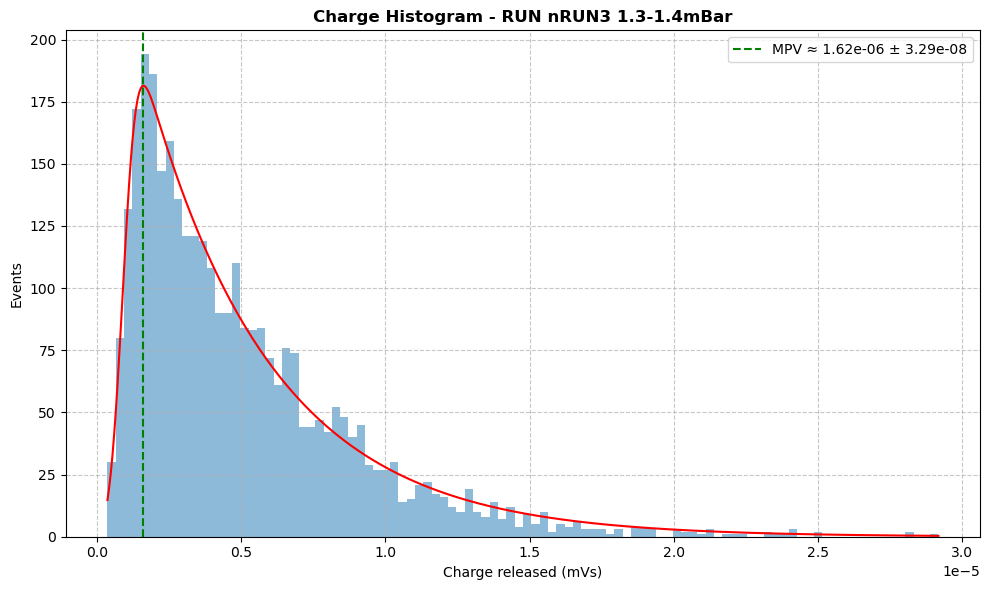

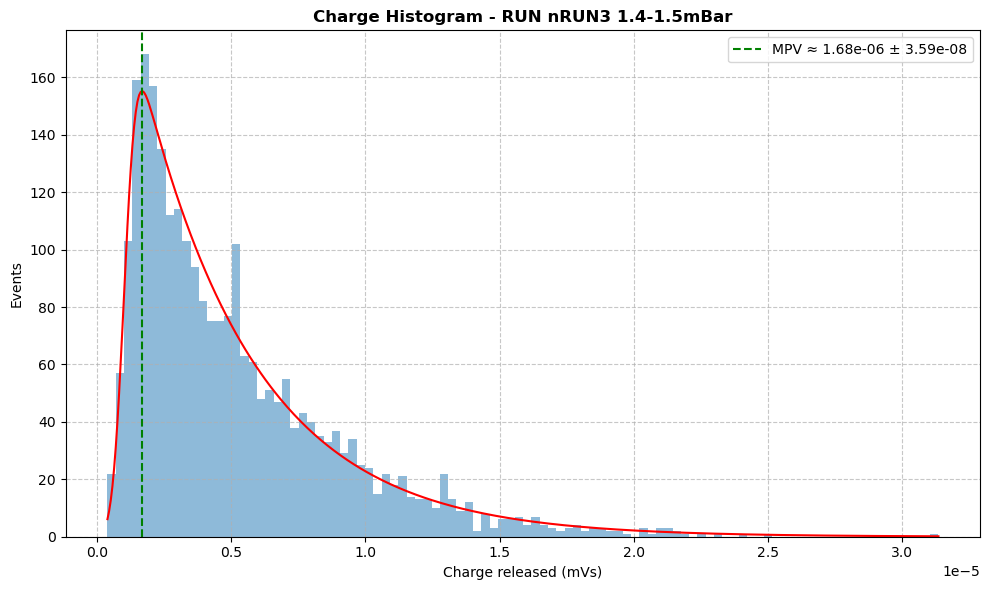

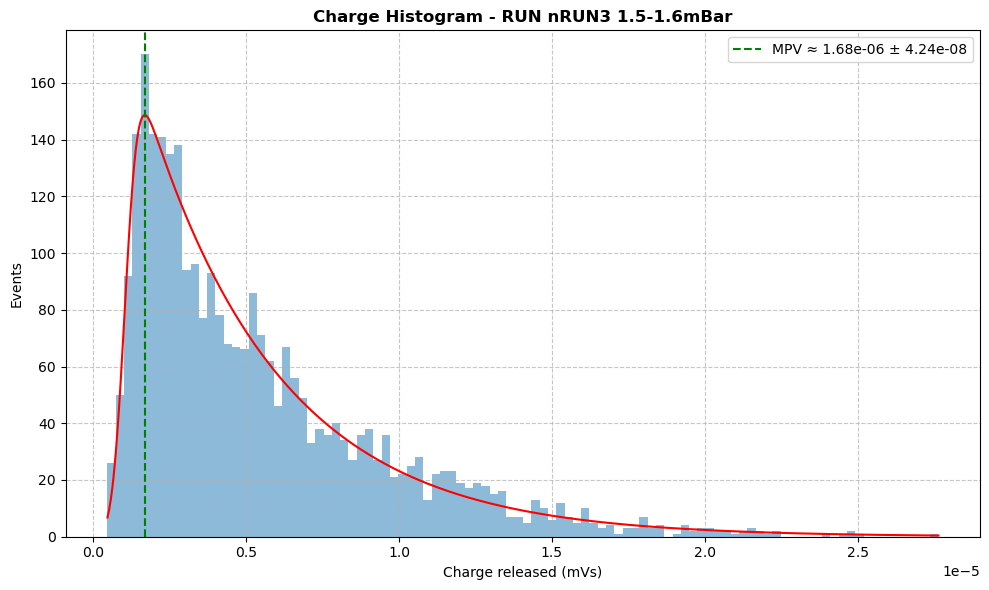

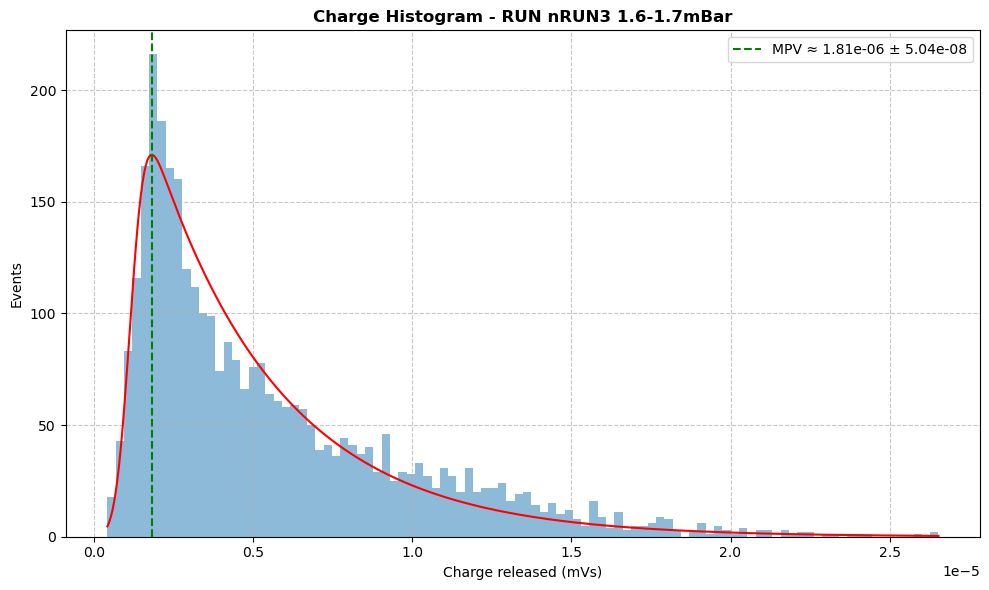

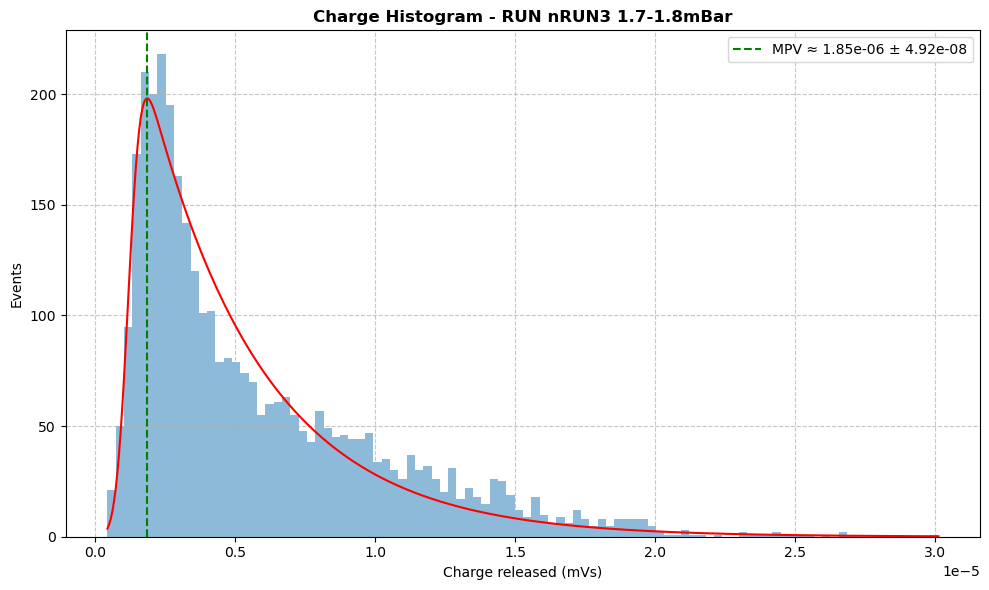

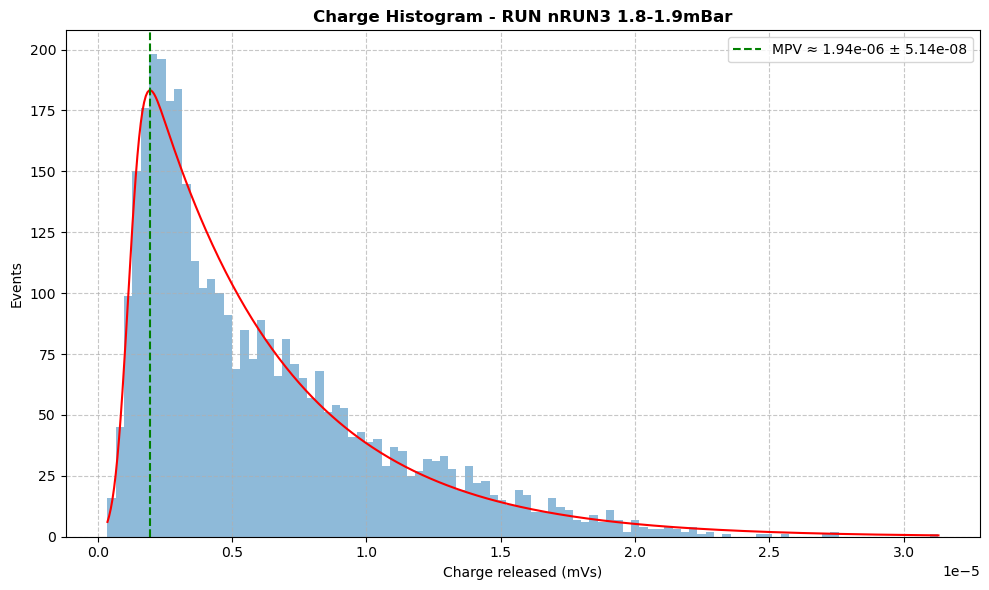

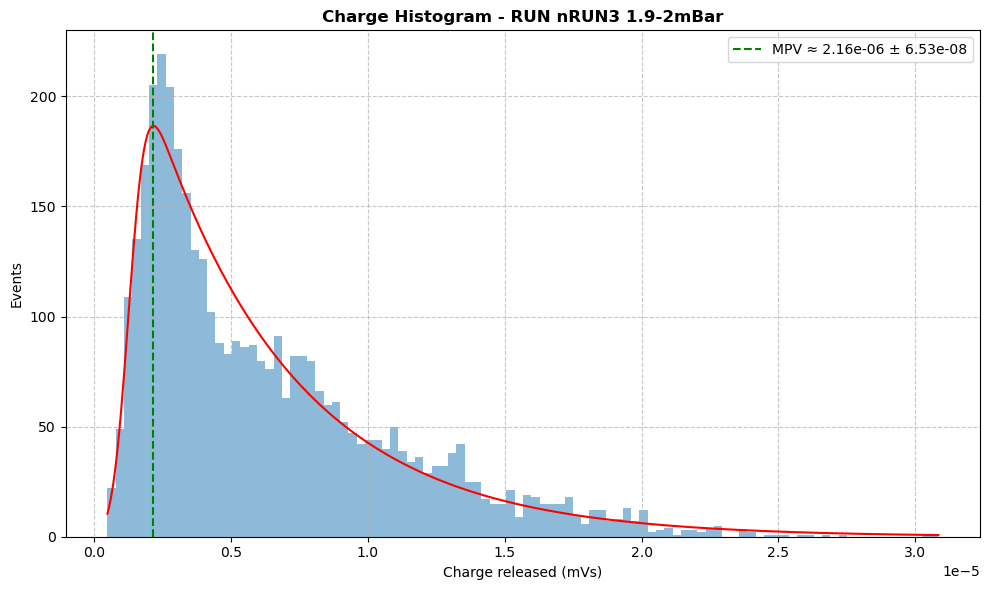

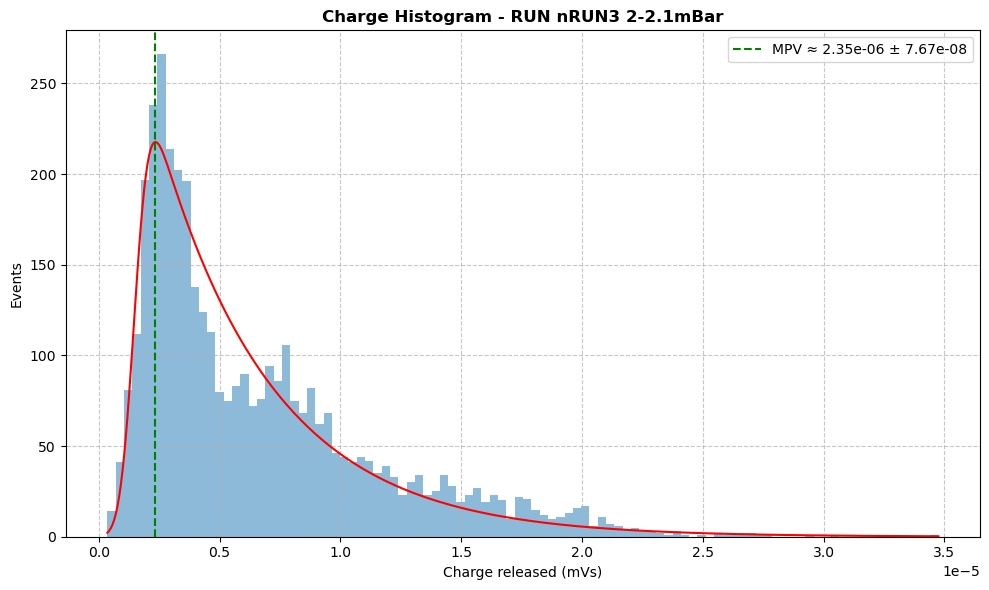

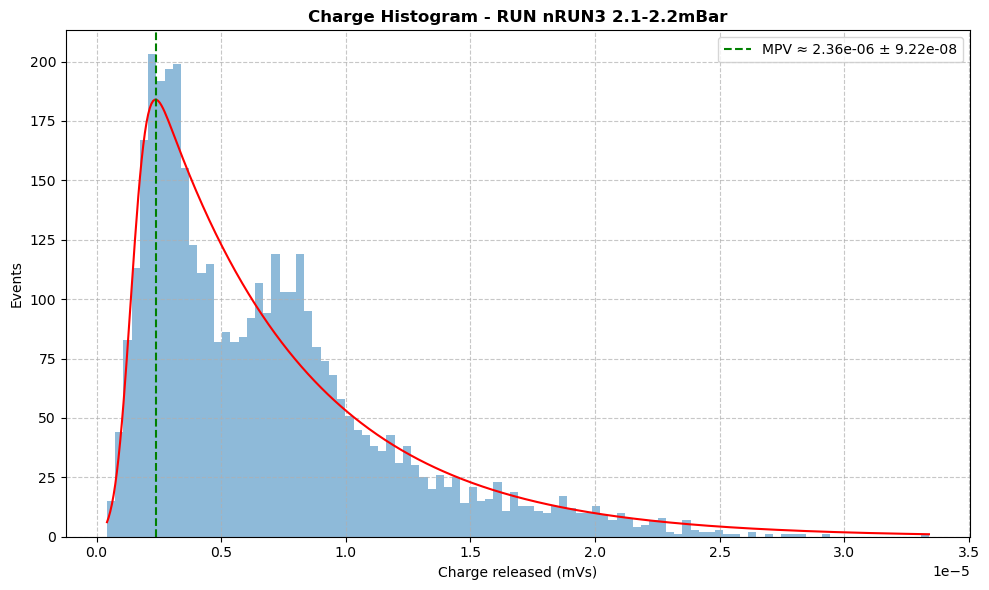

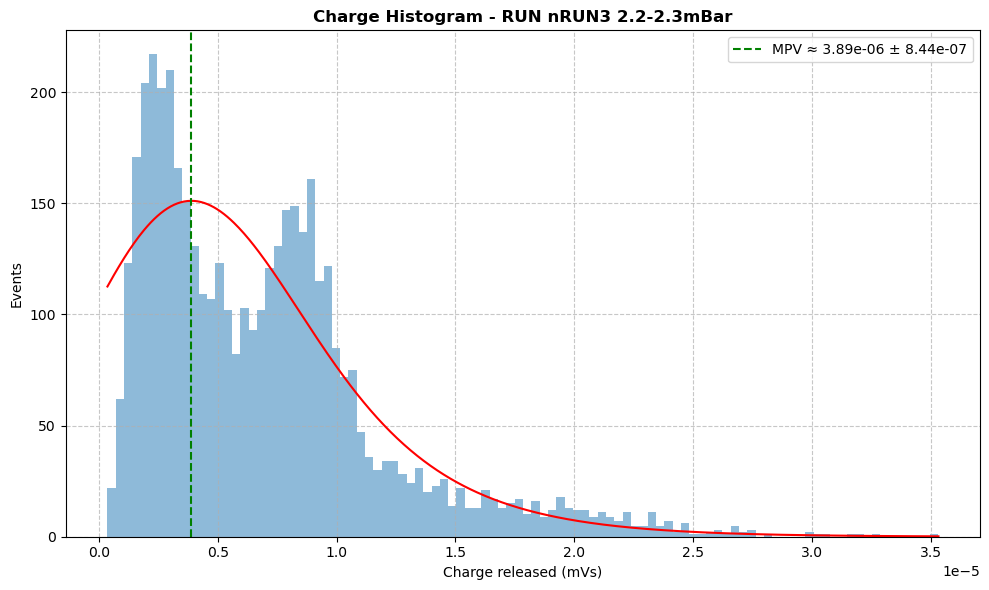

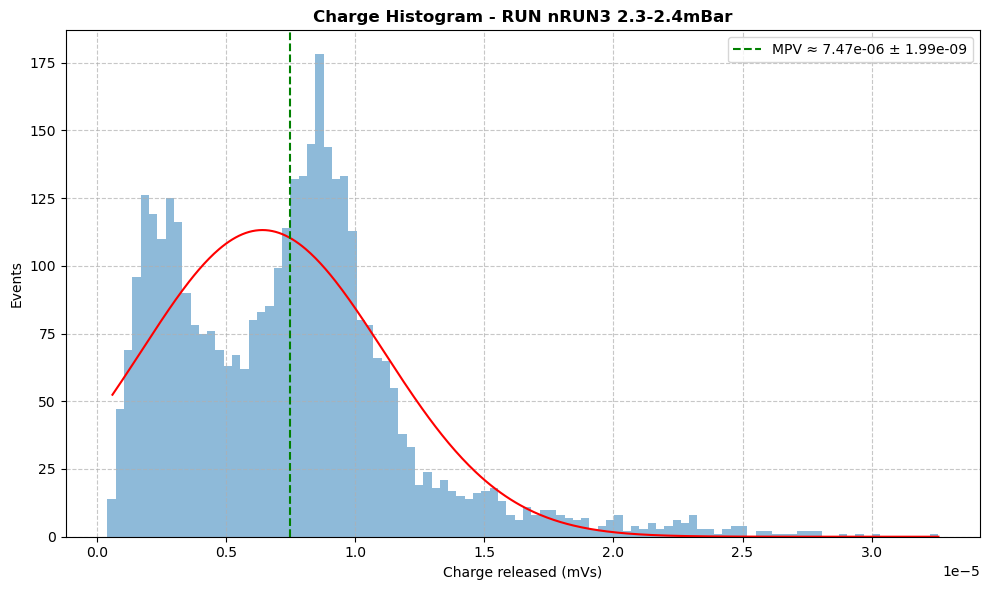

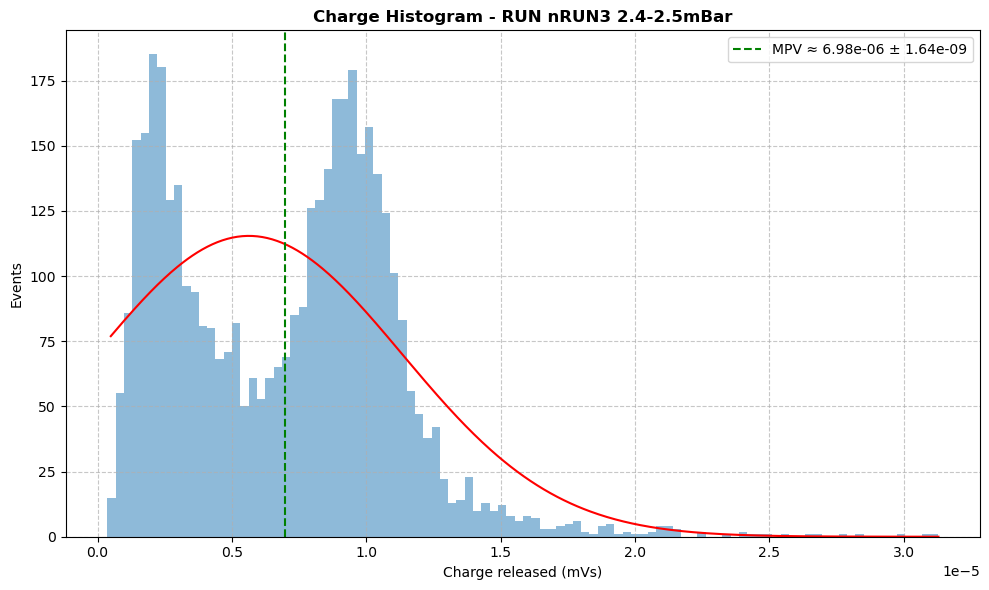

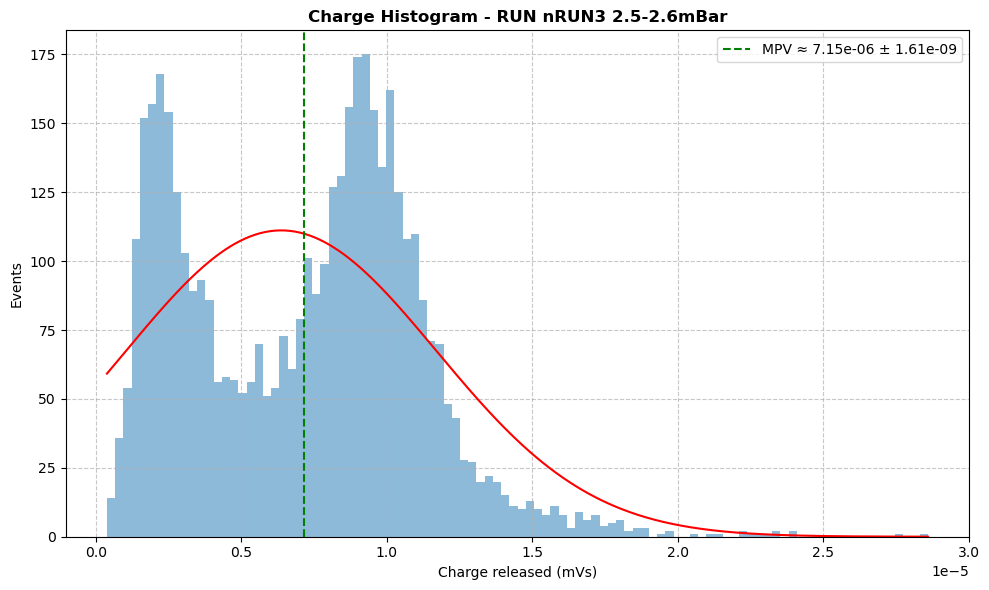

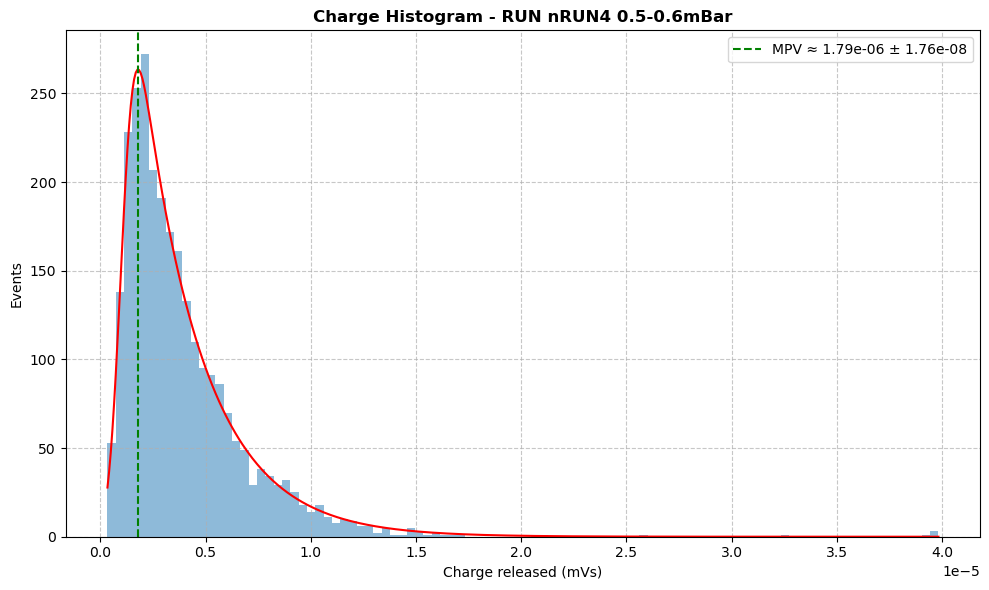

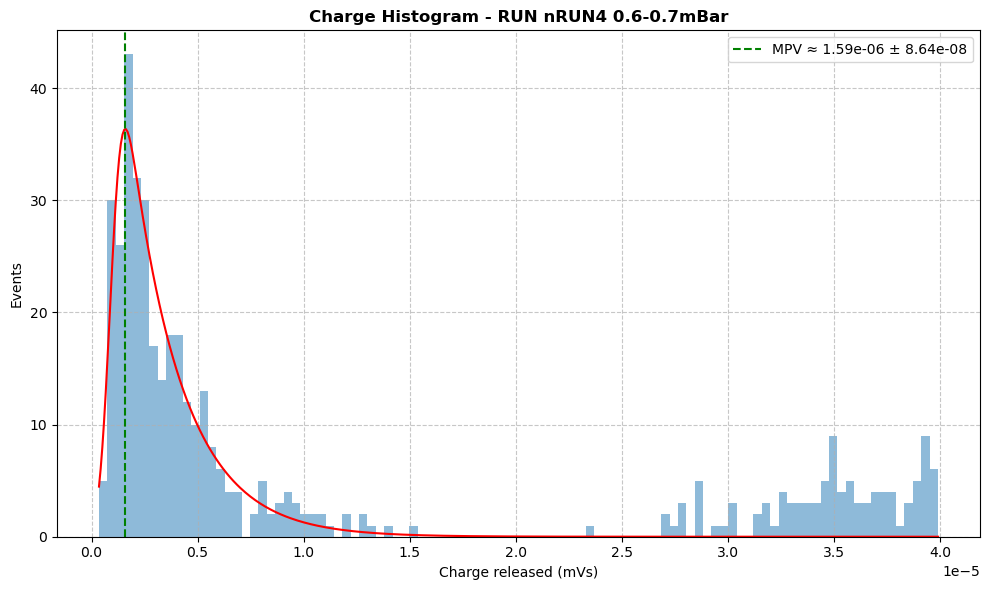

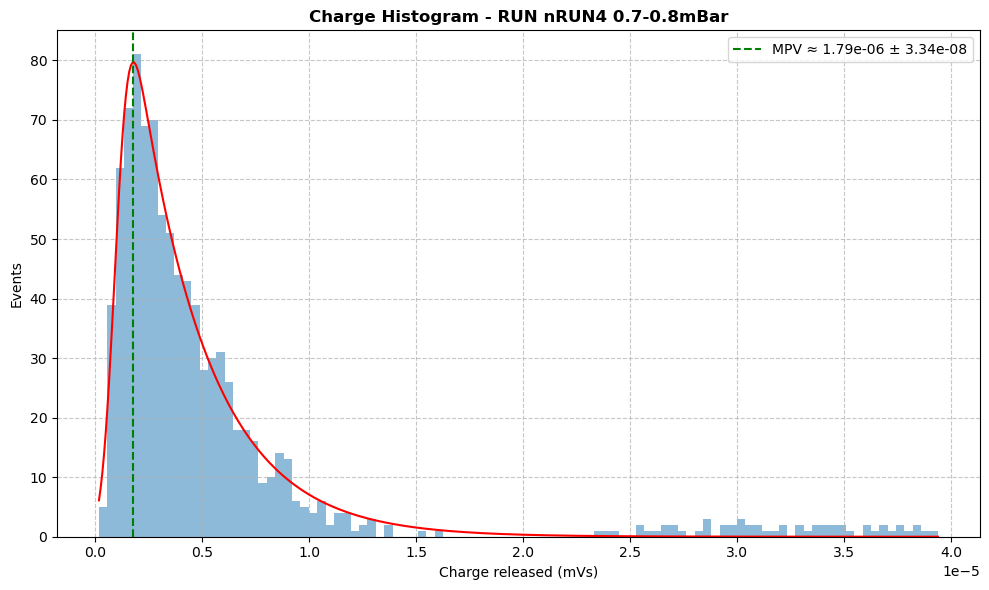

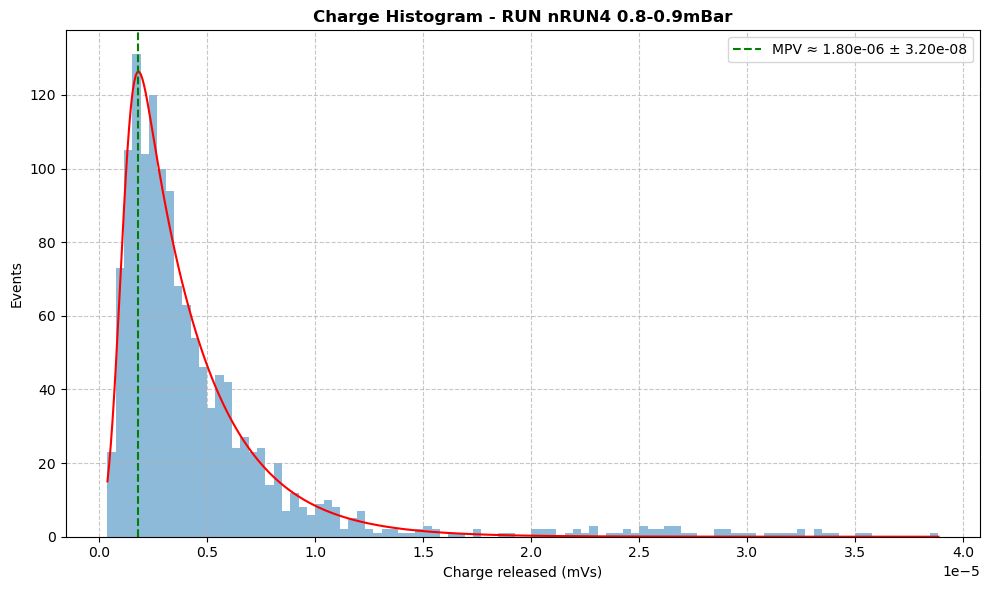

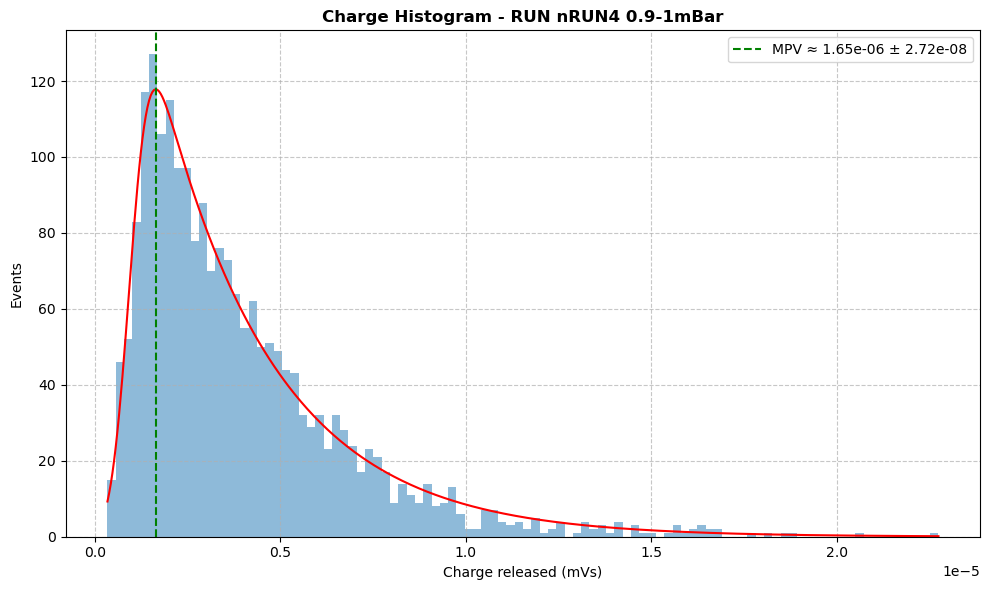

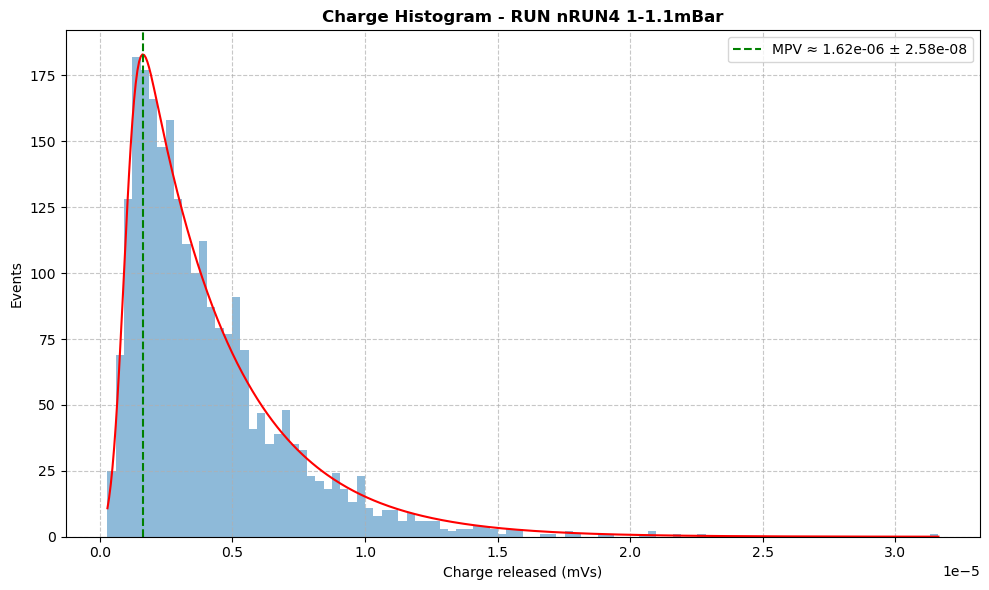

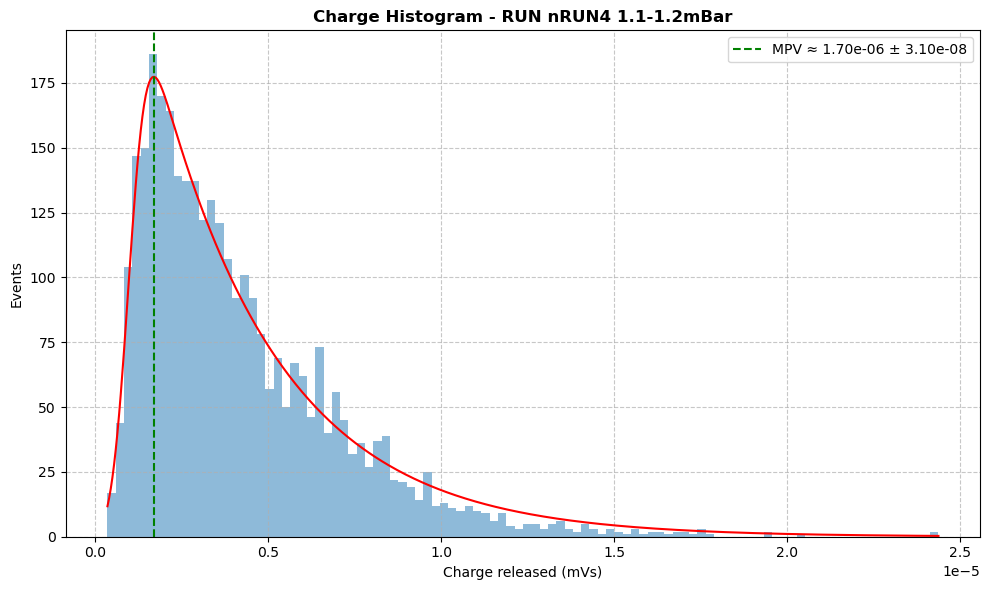

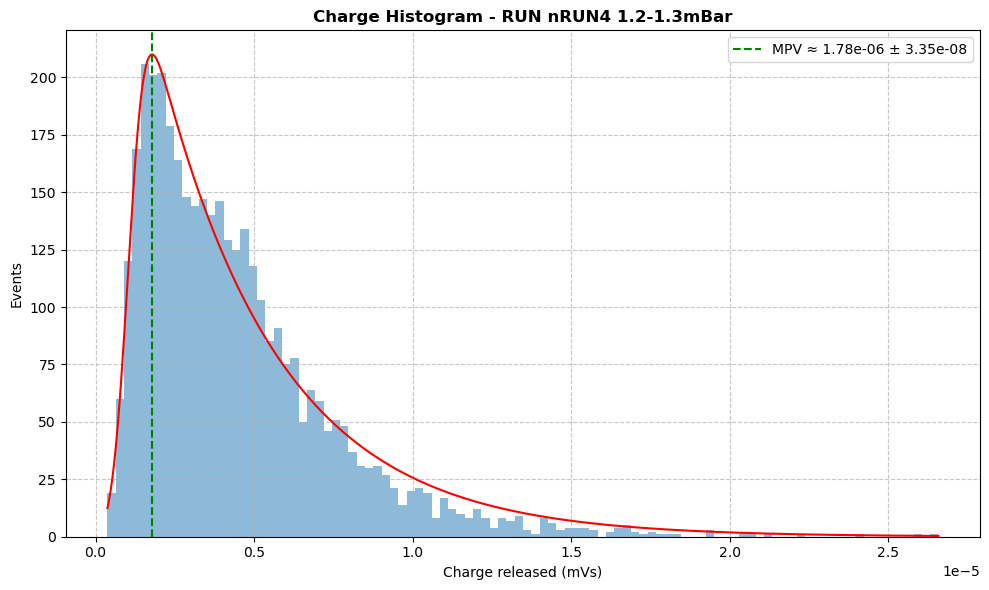

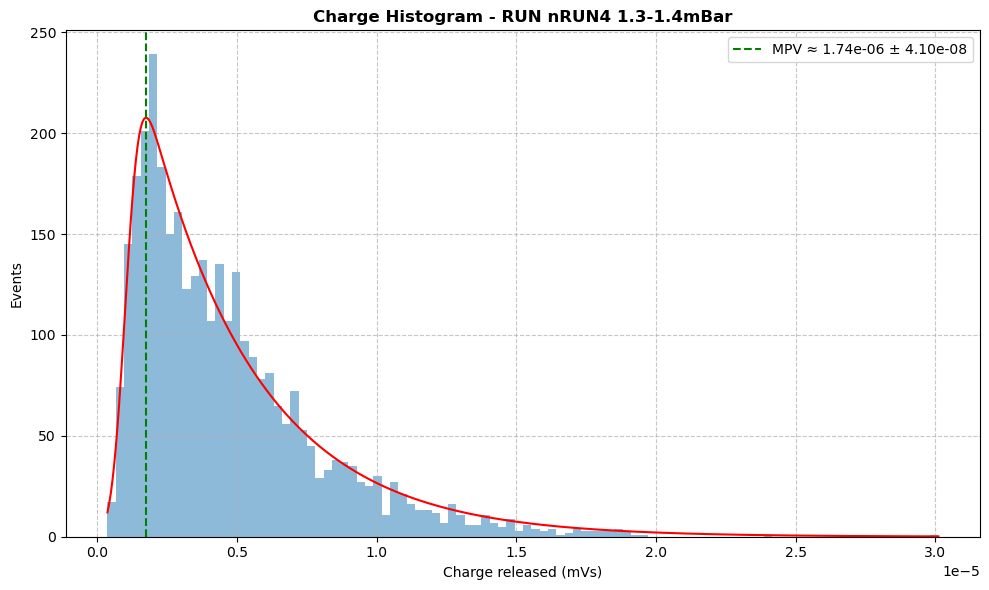

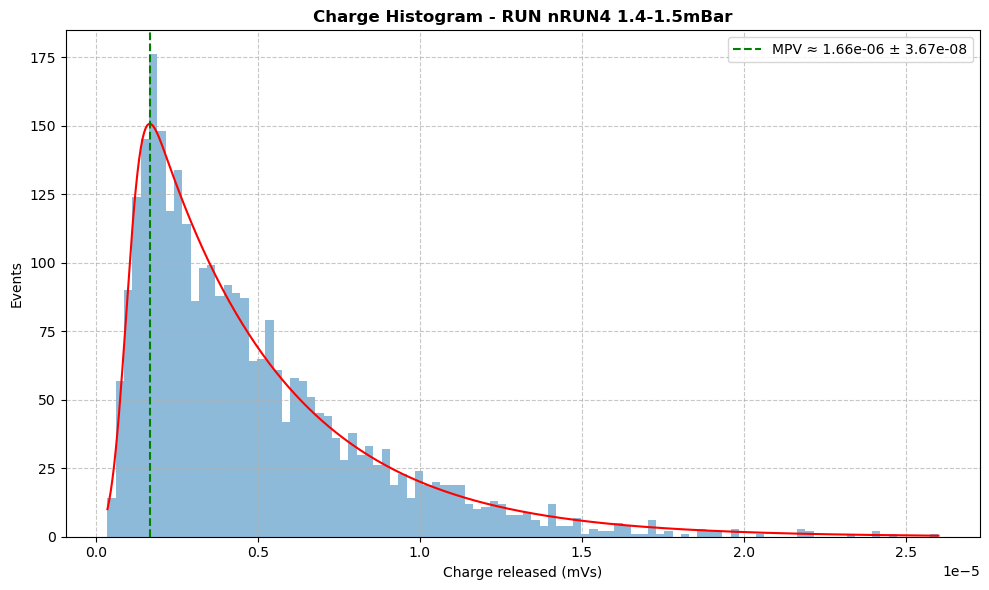

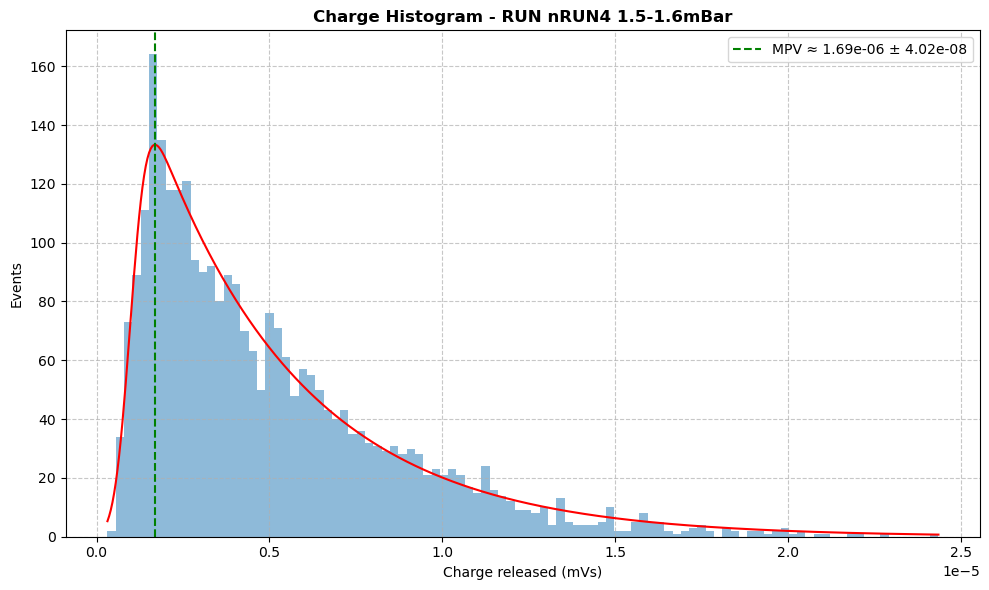

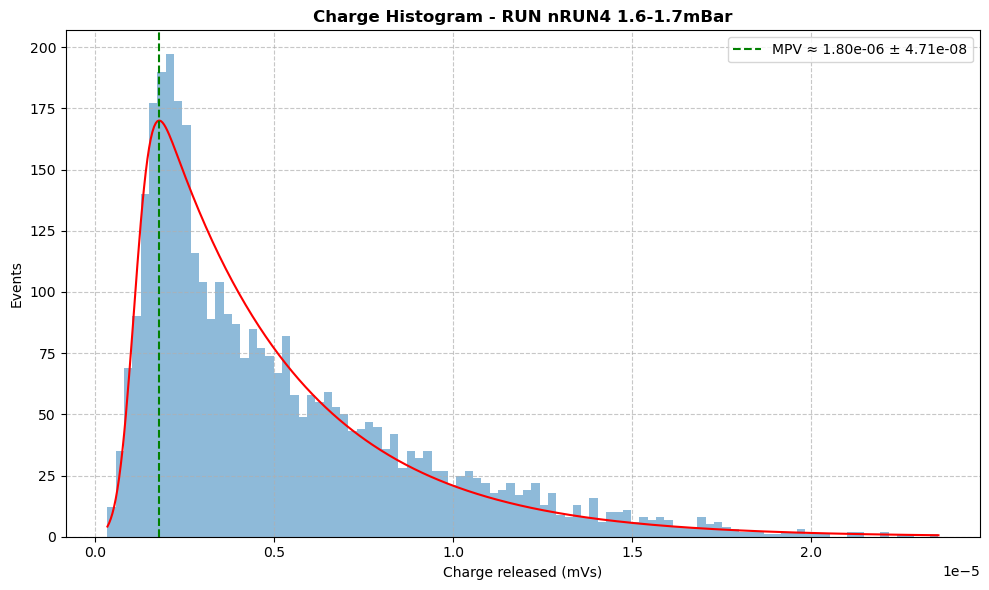

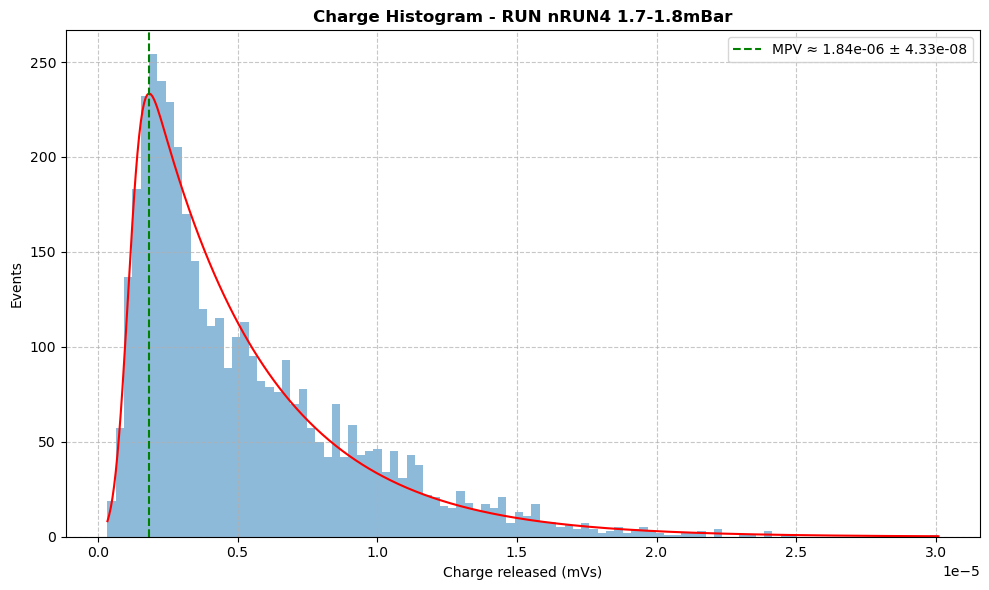

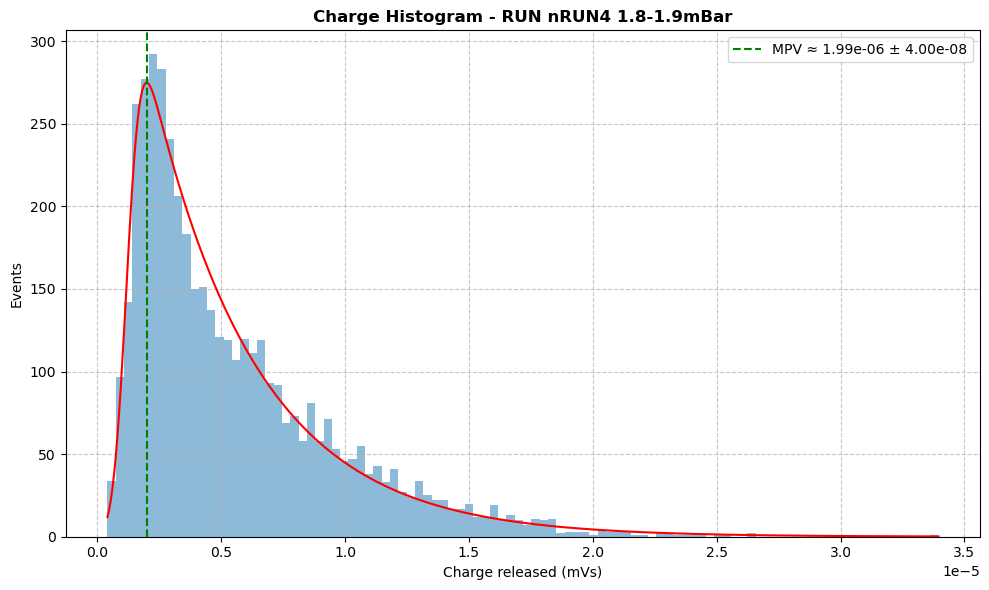

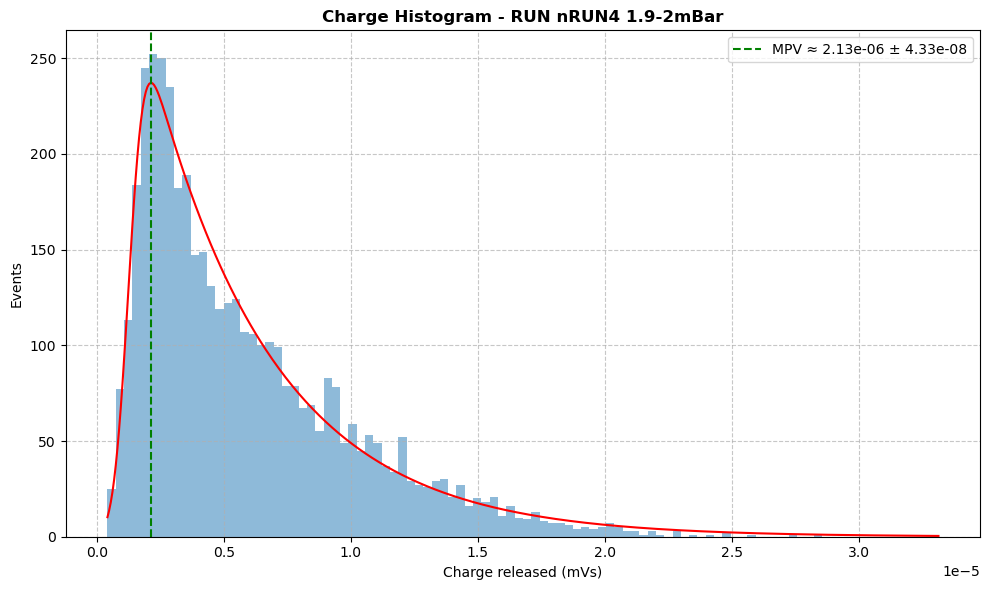

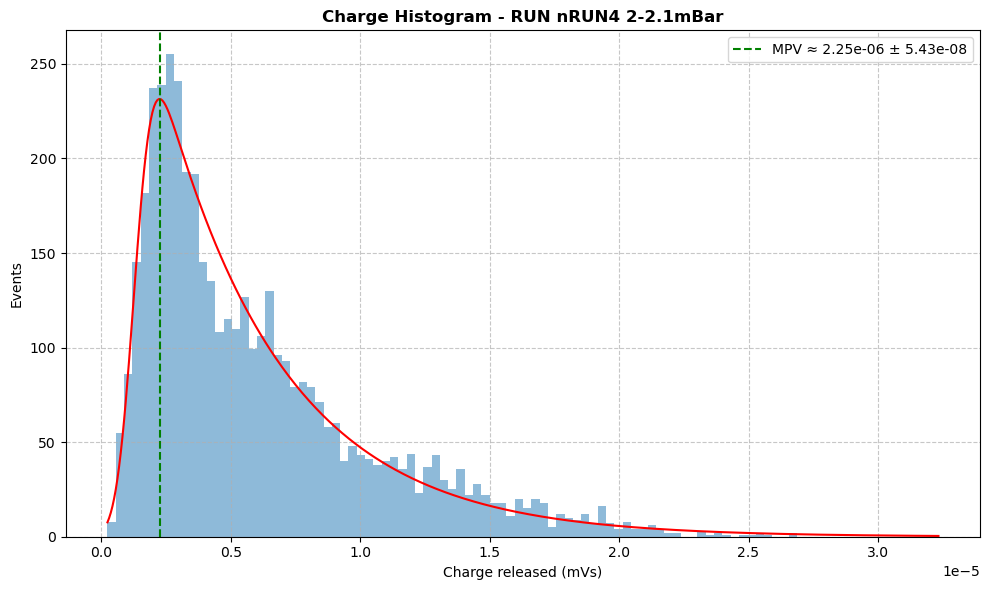

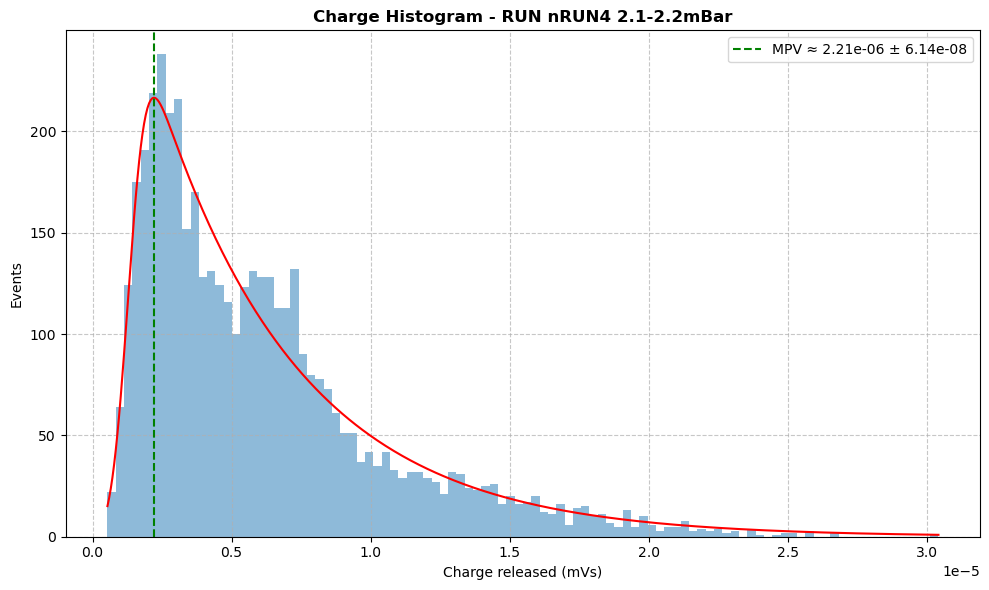

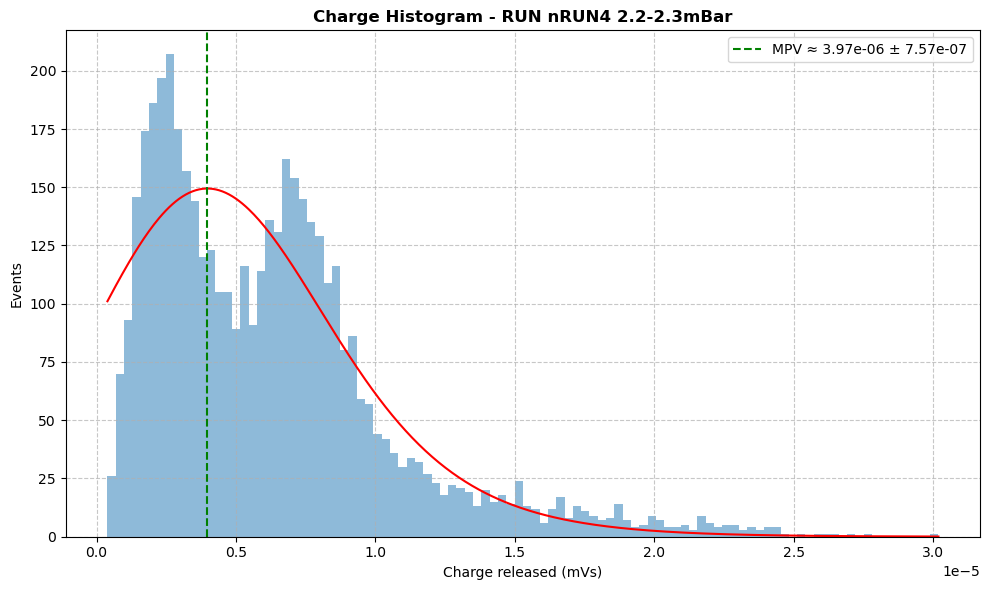

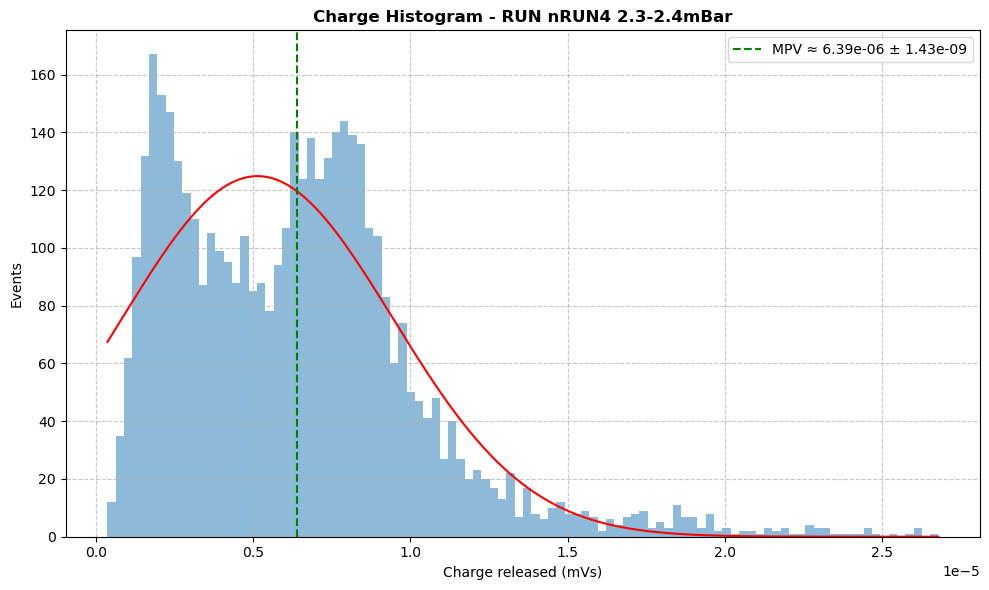

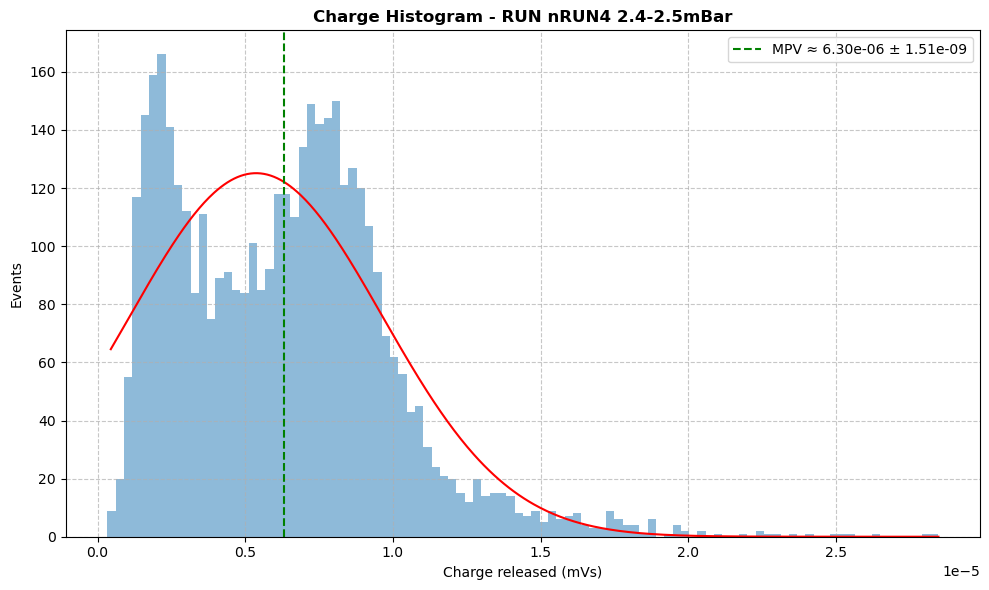

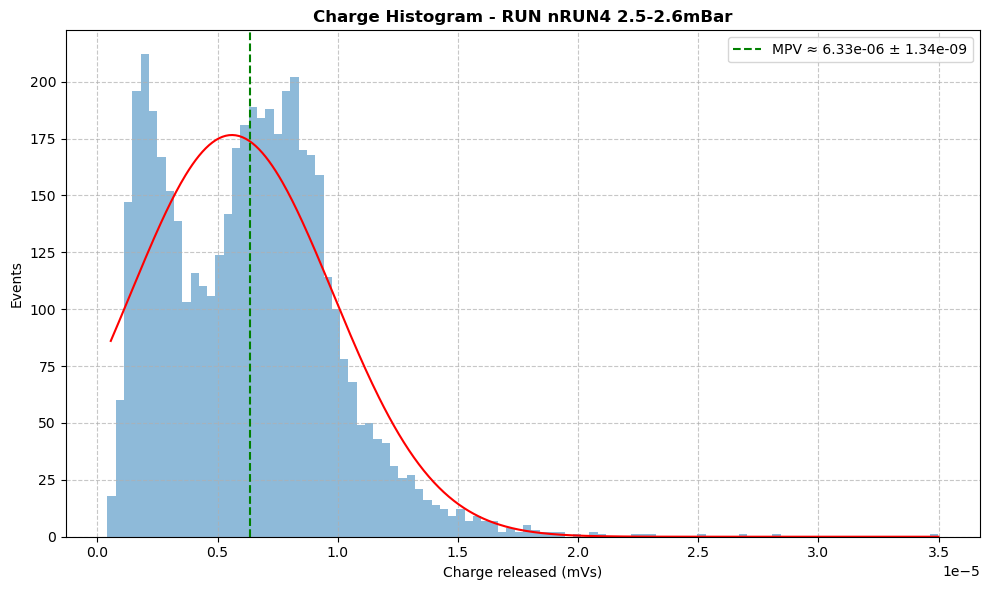

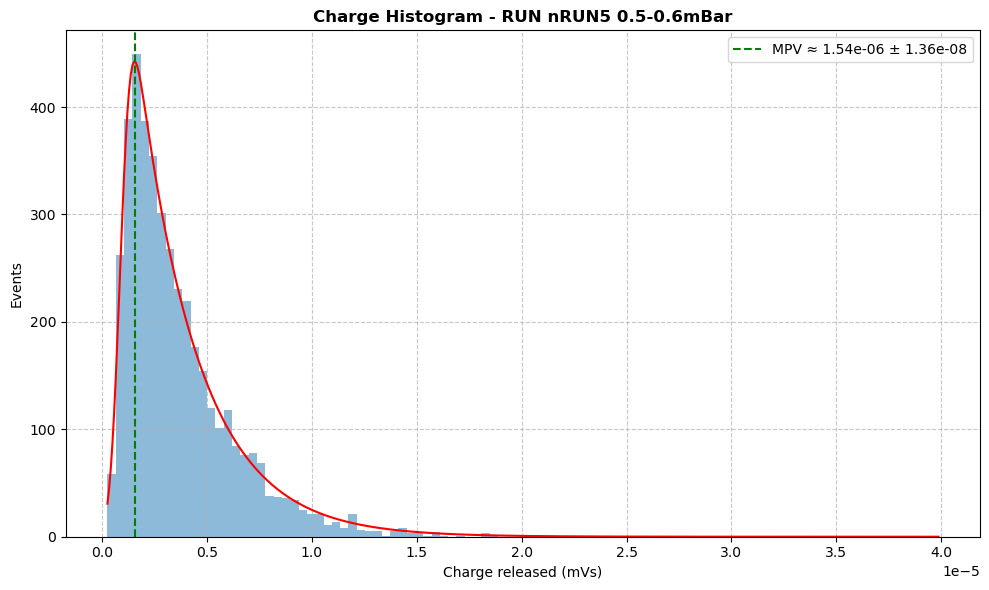

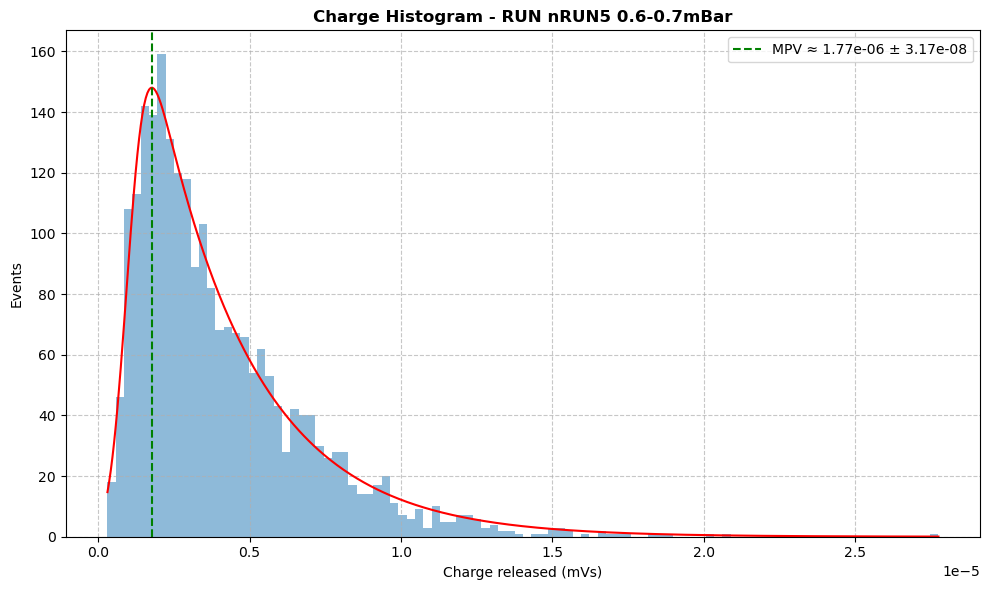

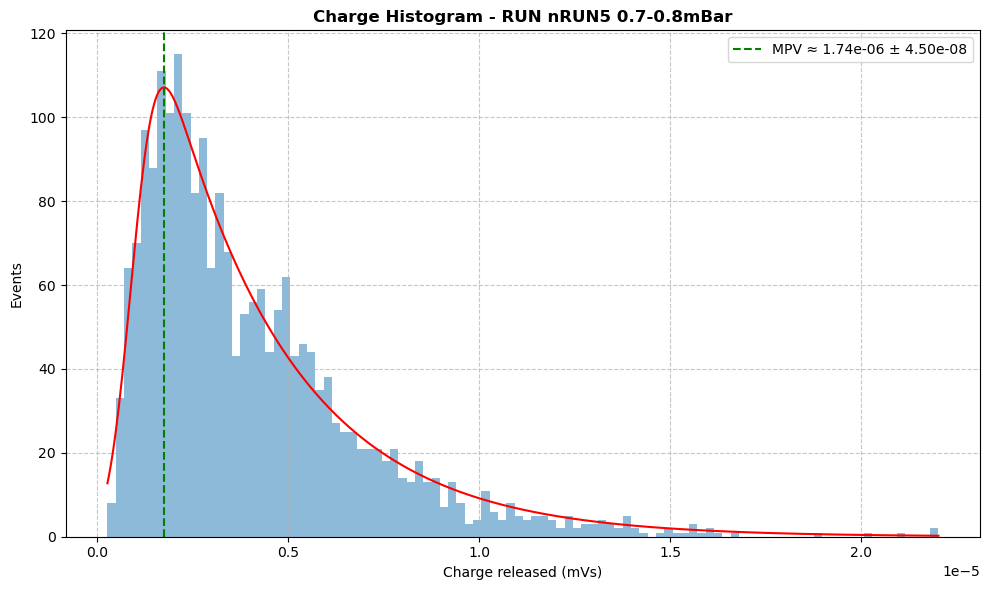

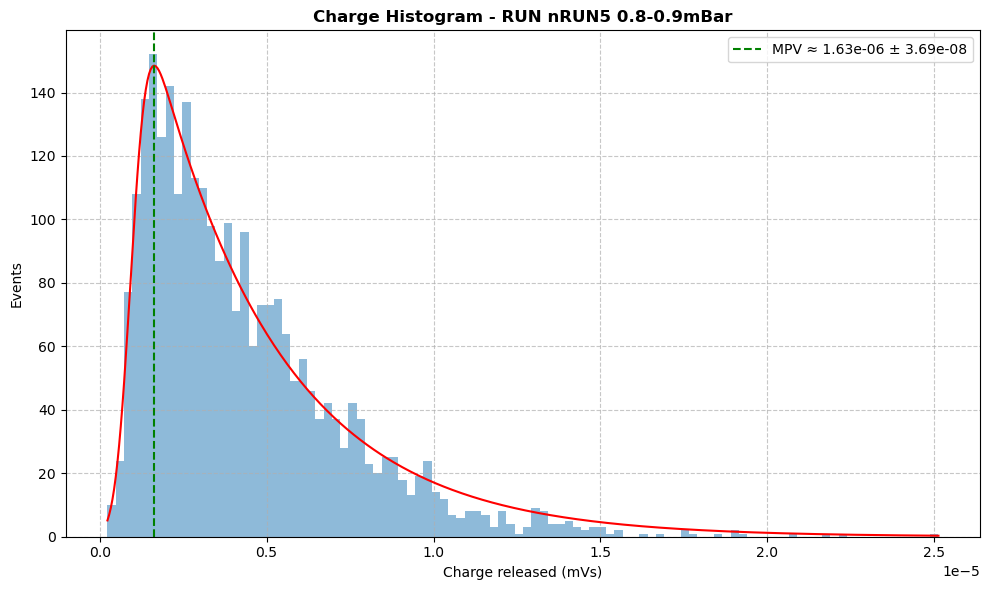

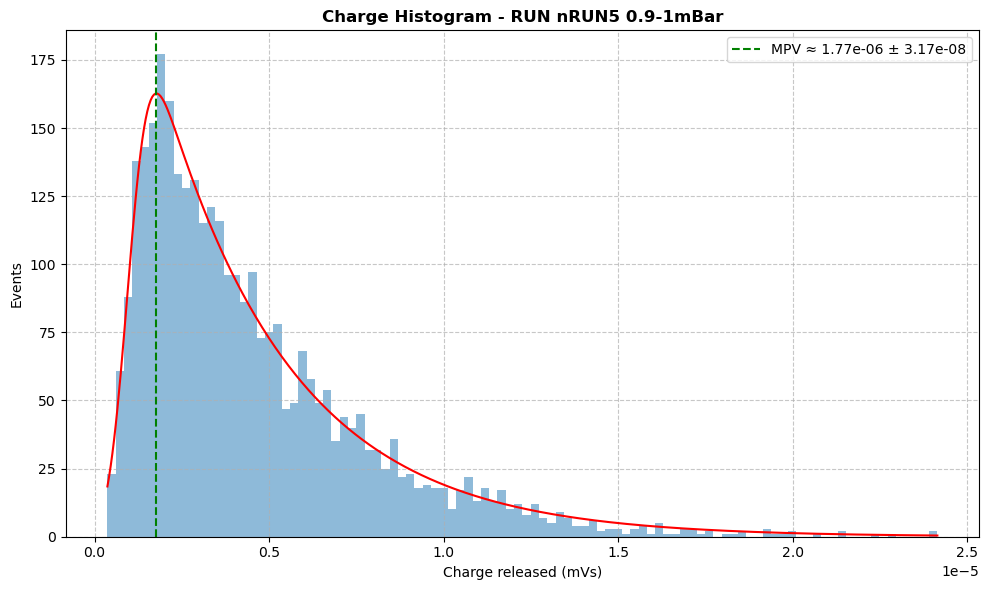

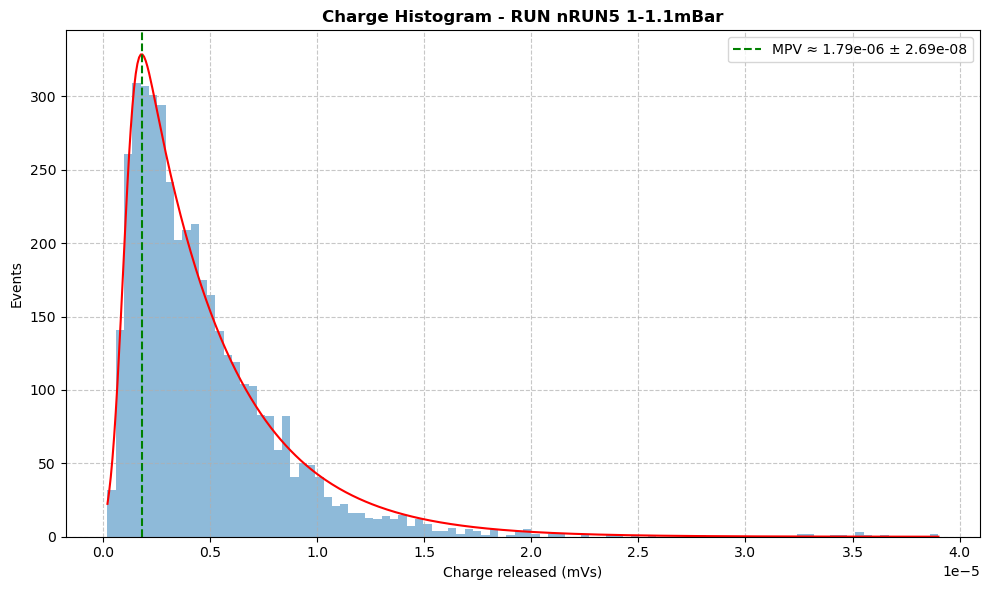

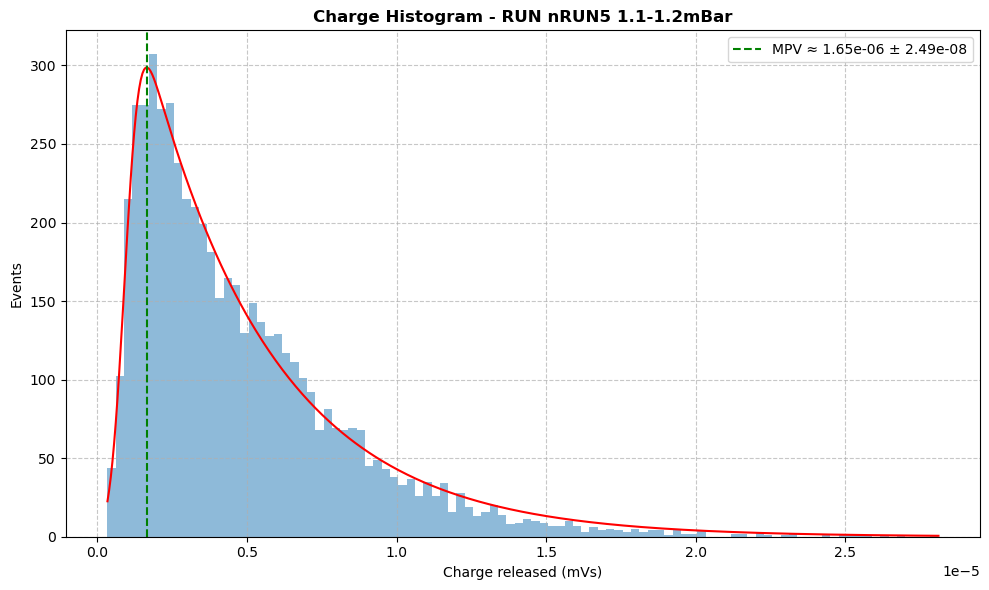

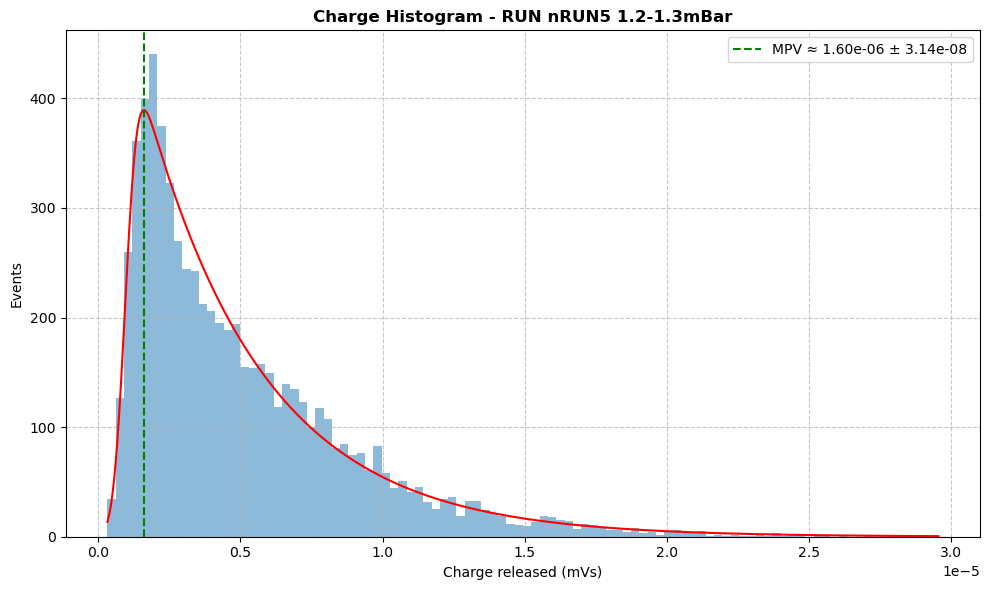

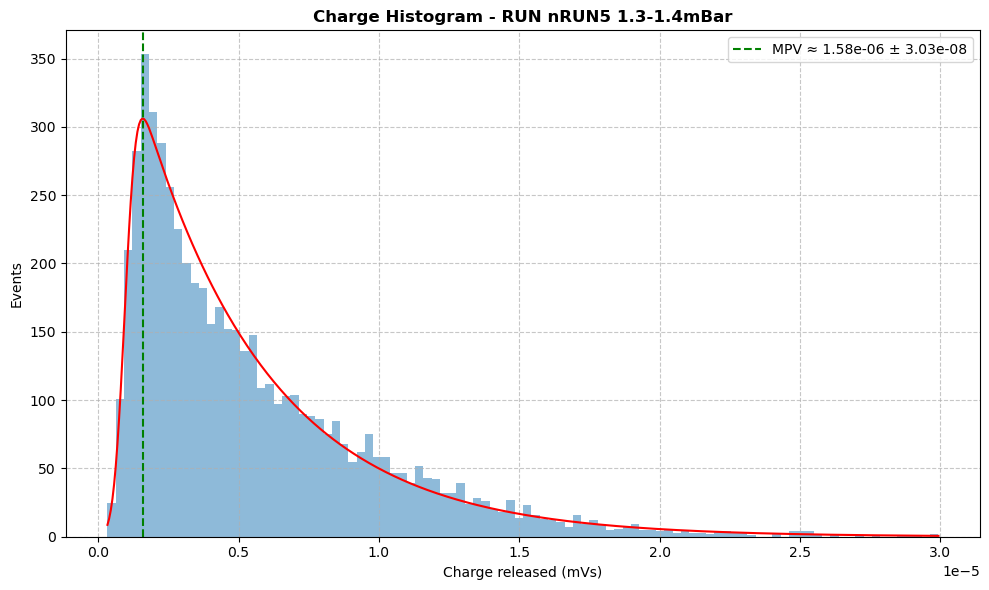

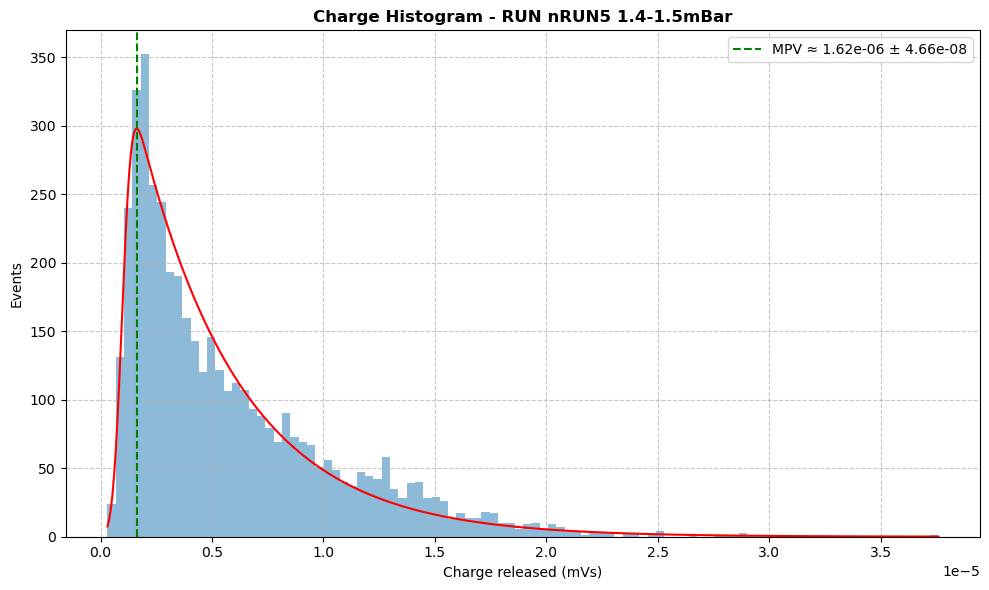

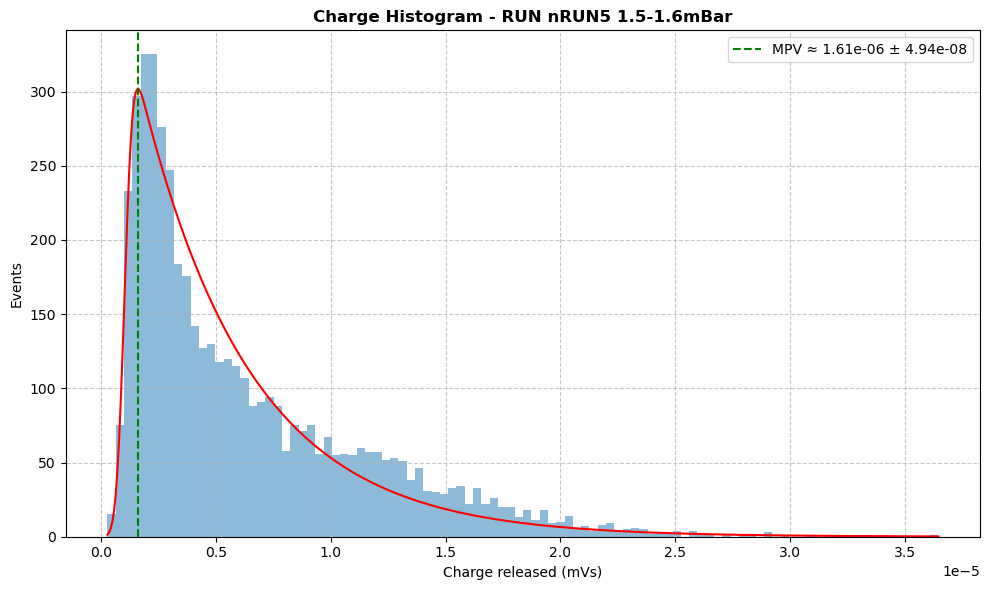

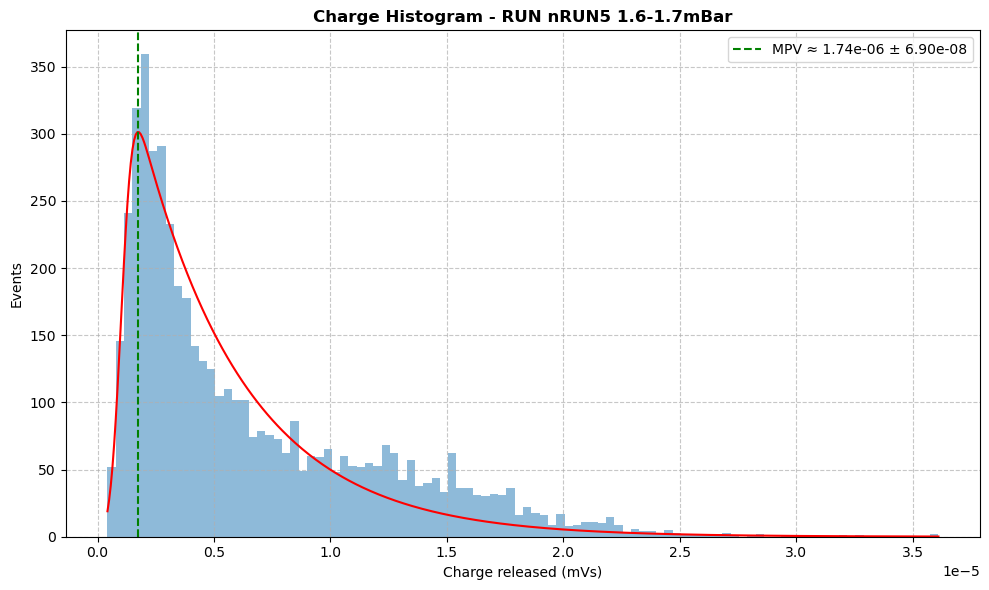

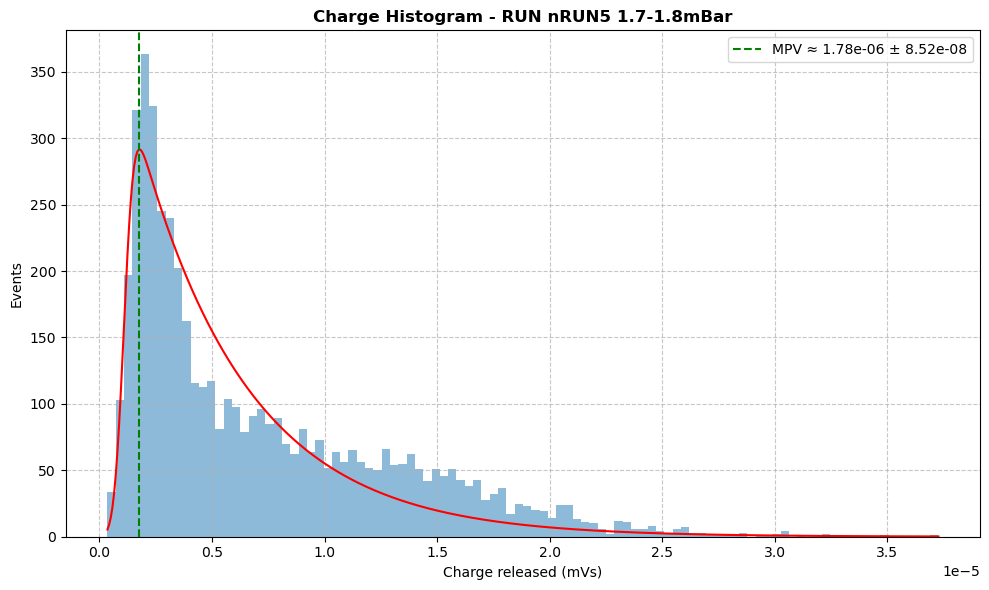

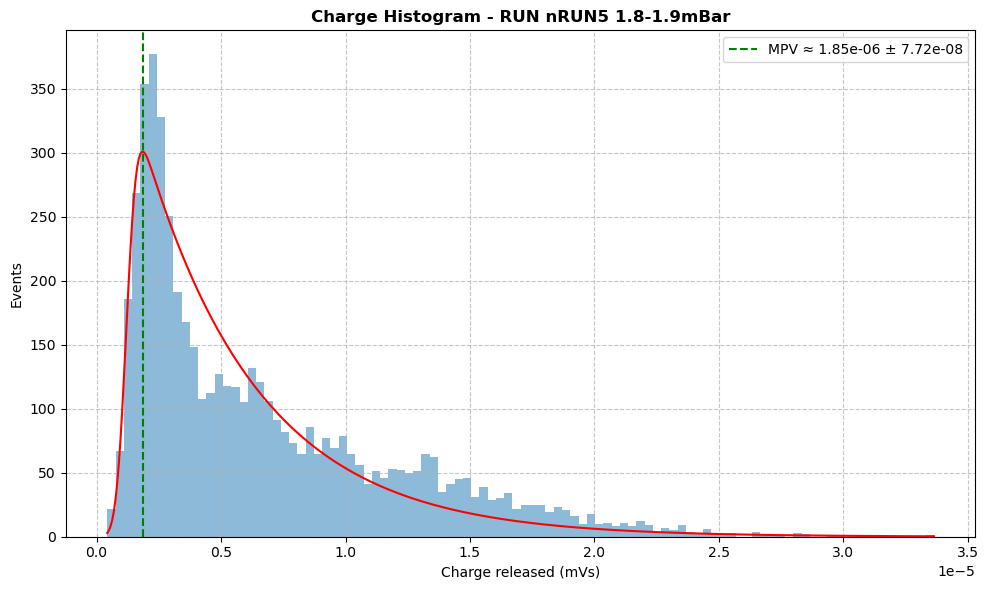

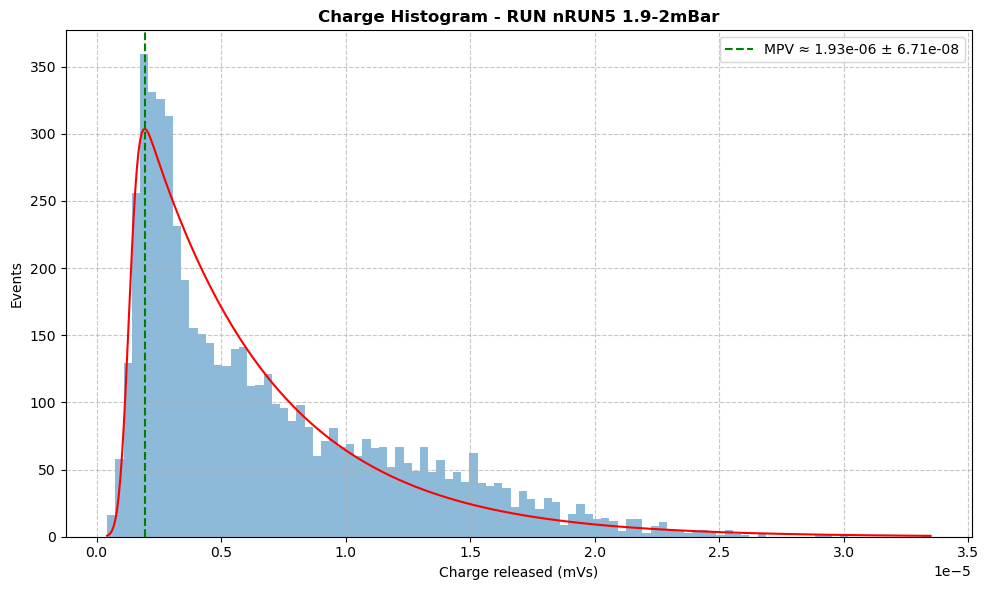

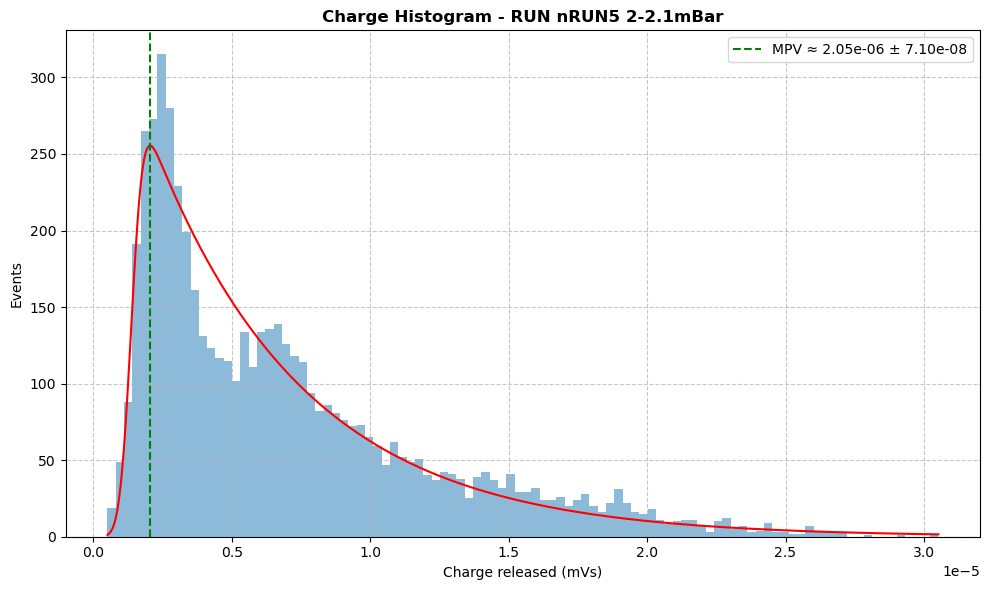

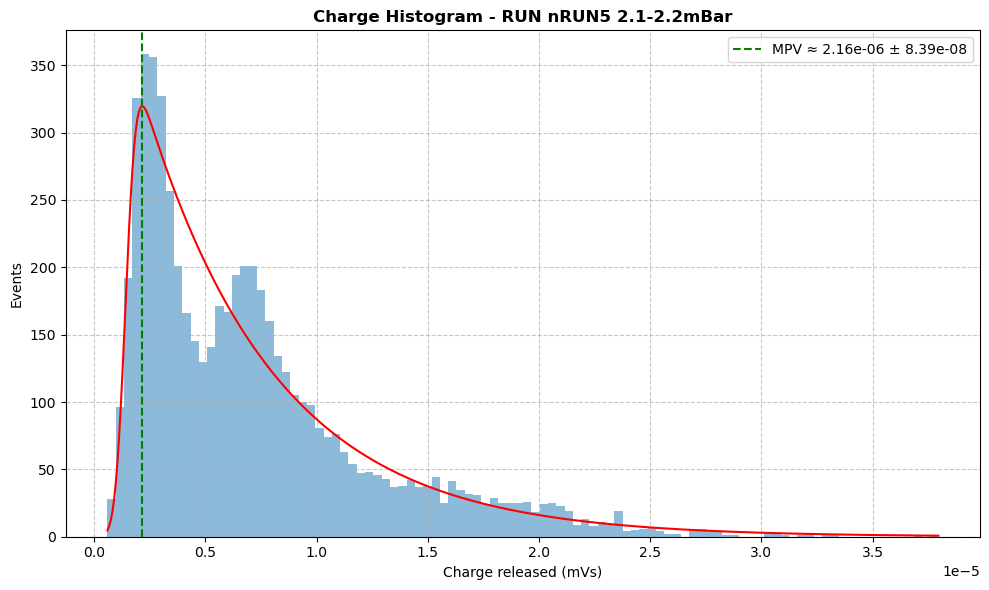

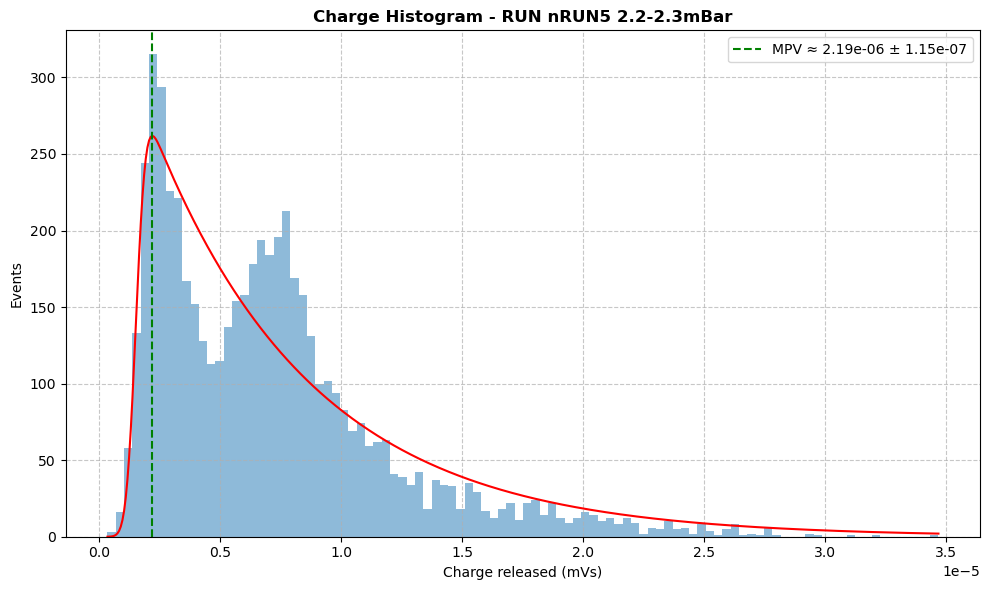

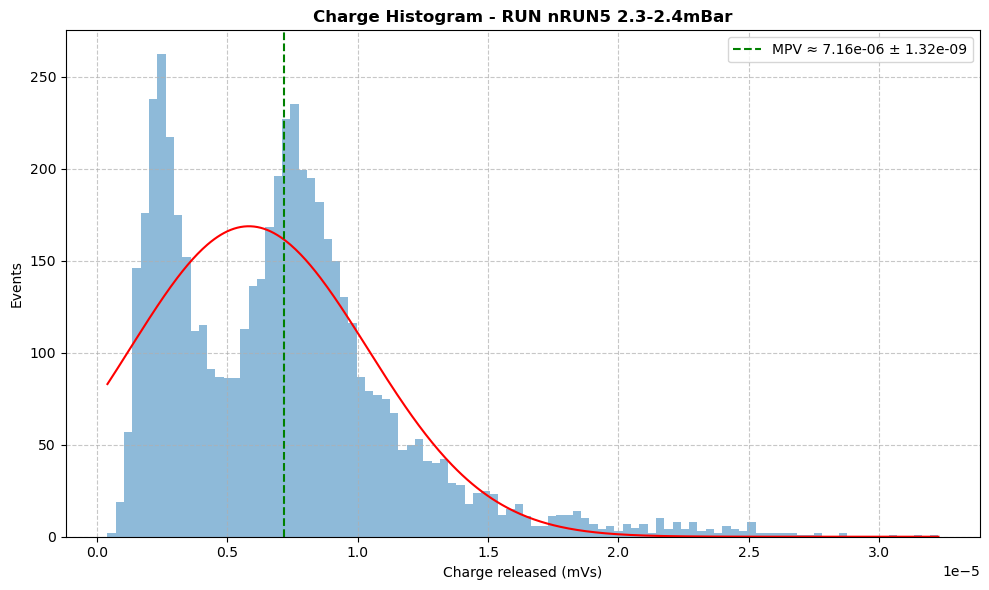

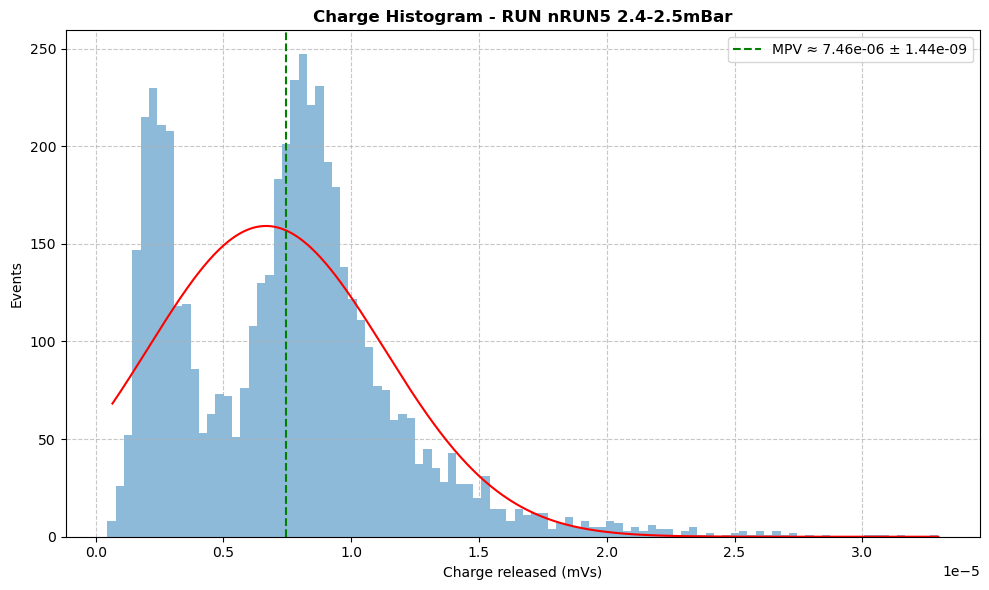

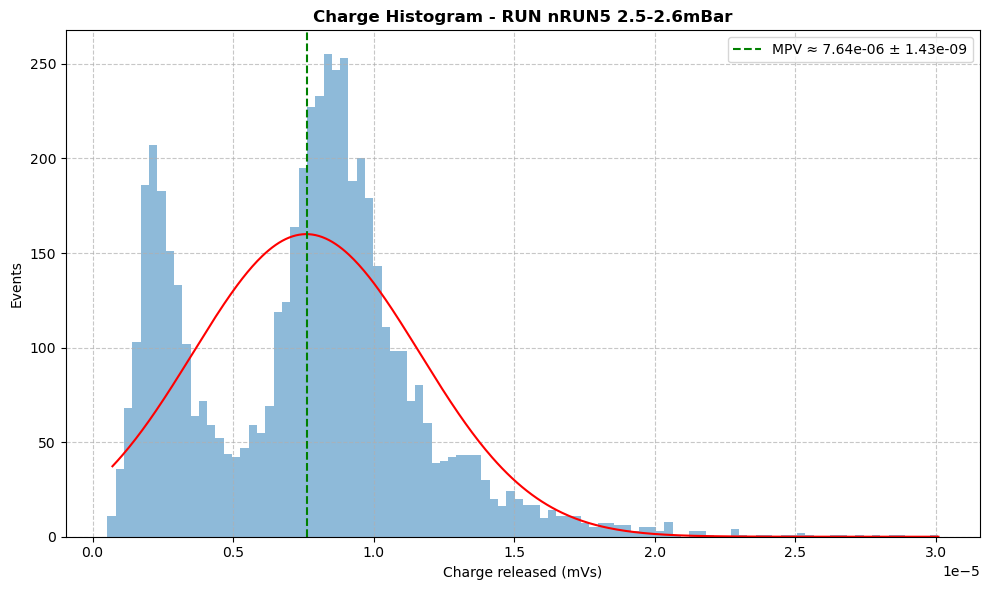

In [7]:
fitparams1 = fit_routine(areas1, nRUN1_pressure, "nRUN1", plot=False)
fitparams2 = fit_routine(areas2, nRUN2_pressure, "nRUN2", plot=False)
fitparams3 = fit_routine(areas3, nRUN3_pressure, "nRUN3", plot=False)
fitparams4 = fit_routine(areas4, nRUN4_pressure, "nRUN4", plot=False)
fitparams5 = fit_routine(areas5, nRUN5_pressure, "nRUN5", plot=False)

C:\Users\louis\AppData\Local\Temp\ipykernel_1688\2691537605.py:62: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(p_windows[0:25], photons1, yerr=photon_errs1, fmt='o', **styles[0], label="nRUN1", capsize=3)
C:\Users\louis\AppData\Local\Temp\ipykernel_1688\2691537605.py:63: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(p_windows[0:25], photons2, yerr=photon_errs2, fmt='o', **styles[1], label="nRUN2", capsize=3)
C:\Users\louis\AppData\Local\Temp\ipykernel_1688\2691537605.py:64: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(p_windows[0:21], photons3, yerr=photon_errs3, fmt='o', **styles[2], label="nRUN3", capsiz

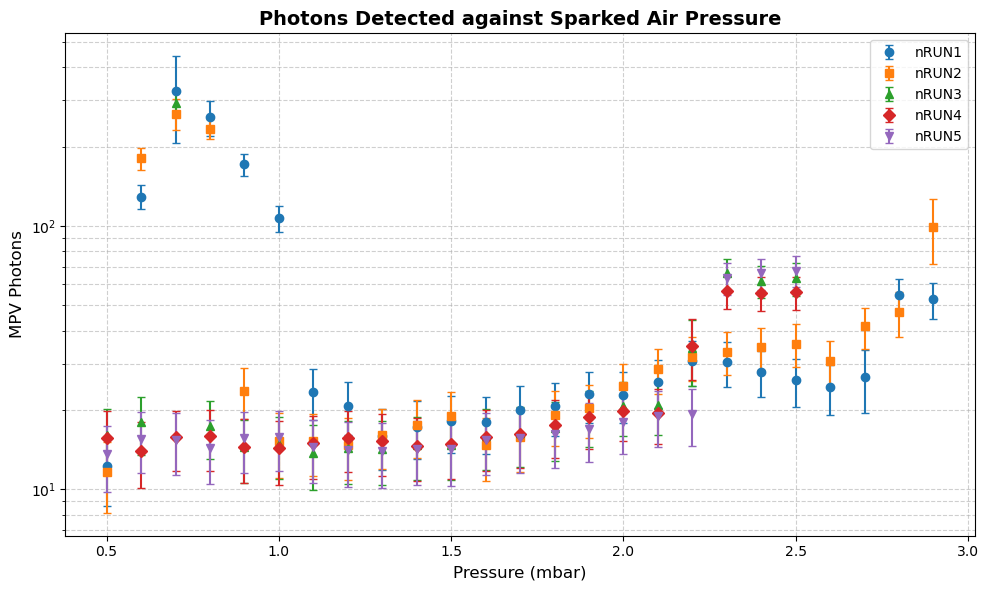

In [12]:
mpvs1 = fitparams1[:,6]
mpvs2 = fitparams2[:,6]
mpvs3 = fitparams3[:,6]
mpvs4 = fitparams4[:,6]
mpvs5 = fitparams5[:,6]

photons1 = (mpvs1 / 1e3 - 8.42e-12) / 1.13e-10
photons2 = (mpvs2 / 1e3 - 8.42e-12) / 1.13e-10
photons3 = (mpvs3 / 1e3 - 8.42e-12) / 1.13e-10
photons4 = (mpvs4 / 1e3 - 8.42e-12) / 1.13e-10
photons5 = (mpvs5 / 1e3 - 8.42e-12) / 1.13e-10

mpv_errs1 = fitparams1[:,7]
mpv_errs2 = fitparams2[:,7]
mpv_errs3 = fitparams3[:,7]
mpv_errs4 = fitparams4[:,7]
mpv_errs5 = fitparams5[:,7]

photon_errs1 = np.sqrt((np.sqrt((mpv_errs1 / mpvs1) ** 2 + (6.71e-12 / 1.13e-10) ** 2) * np.abs(photons1) + 1.11e-11)**2 + photons1)
photon_errs2 = np.sqrt((np.sqrt((mpv_errs2 / mpvs2) ** 2 + (6.71e-12 / 1.13e-10) ** 2) * np.abs(photons2) + 1.11e-11)**2 + photons2)
photon_errs3 = np.sqrt((np.sqrt((mpv_errs3 / mpvs3) ** 2 + (6.71e-12 / 1.13e-10) ** 2) * np.abs(photons3) + 1.11e-11)**2 + photons3)
photon_errs4 = np.sqrt((np.sqrt((mpv_errs4 / mpvs4) ** 2 + (6.71e-12 / 1.13e-10) ** 2) * np.abs(photons4) + 1.11e-11)**2 + photons4)
photon_errs5 = np.sqrt((np.sqrt((mpv_errs5 / mpvs5) ** 2 + (6.71e-12 / 1.13e-10) ** 2) * np.abs(photons5) + 1.11e-11)**2 + photons5)

stack = np.zeros((len(photons1), 5))
stack[:,0] = photons1
stack[:,1] = photons2
stack[0:21,2] = photons3
stack[0:21,3] = photons4
stack[0:21,4] = photons5

stack_errs = np.zeros((len(photons1), 5))
stack_errs[:,0] = photon_errs1
stack_errs[:,1] = photon_errs2
stack_errs[0:21,2] = photon_errs3
stack_errs[0:21,3] = photon_errs4
stack_errs[0:21,4] = photon_errs5

reprod = np.zeros(len(stack))
reprod_err = np.zeros(len(stack))
for i in range(len(photons3)):
    reprod[i] = (np.max(stack[i, :]) - np.min(stack[i, :]))/np.mean(stack[i, :])
    max_idx = np.argmax(stack[i, :])
    min_idx = np.argmin(stack[i, :])
    reprod_err[i] = np.sqrt(((stack_errs[i, max_idx] + stack_errs[i, min_idx])/(np.max(stack[i, :]) - np.min(stack[i, :])))**2 + (np.mean(stack_errs[i, :])//np.mean(stack[i, :]))**2)
reprod[21:25] = np.abs(stack[21:25,0] - stack[21:25,1])
reprod_err[21:25] = np.abs(stack_errs[21:25,0] + stack_errs[21:25,1])


plt.figure(figsize=(10, 6))

# Define styles for clarity
styles = [
    {'color': 'C0', 'marker': 'o'},
    {'color': 'C1', 'marker': 's'},
    {'color': 'C2', 'marker': '^'},
    {'color': 'C3', 'marker': 'D'},
    {'color': 'C4', 'marker': 'v'},
]

# Plot each run with its style
plt.errorbar(p_windows[0:25], photons1, yerr=photon_errs1, fmt='o', **styles[0], label="nRUN1", capsize=3)
plt.errorbar(p_windows[0:25], photons2, yerr=photon_errs2, fmt='o', **styles[1], label="nRUN2", capsize=3)
plt.errorbar(p_windows[0:21], photons3, yerr=photon_errs3, fmt='o', **styles[2], label="nRUN3", capsize=3)
plt.errorbar(p_windows[0:21], photons4, yerr=photon_errs4, fmt='o', **styles[3], label="nRUN4", capsize=3)
plt.errorbar(p_windows[0:21], photons5, yerr=photon_errs5, fmt='o', **styles[4], label="nRUN5", capsize=3)
#plt.errorbar(p_windows[0:25], reprod, yerr=reprod_err, fmt='k', label="Reproducibility", capsize=3)

# Aesthetics
plt.xlabel("Pressure (mbar)", fontsize=12)
plt.ylabel("MPV Photons", fontsize=12)
plt.title("Photons Detected against Sparked Air Pressure", fontsize=14, weight='bold')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
#plt.ylim(0,30)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


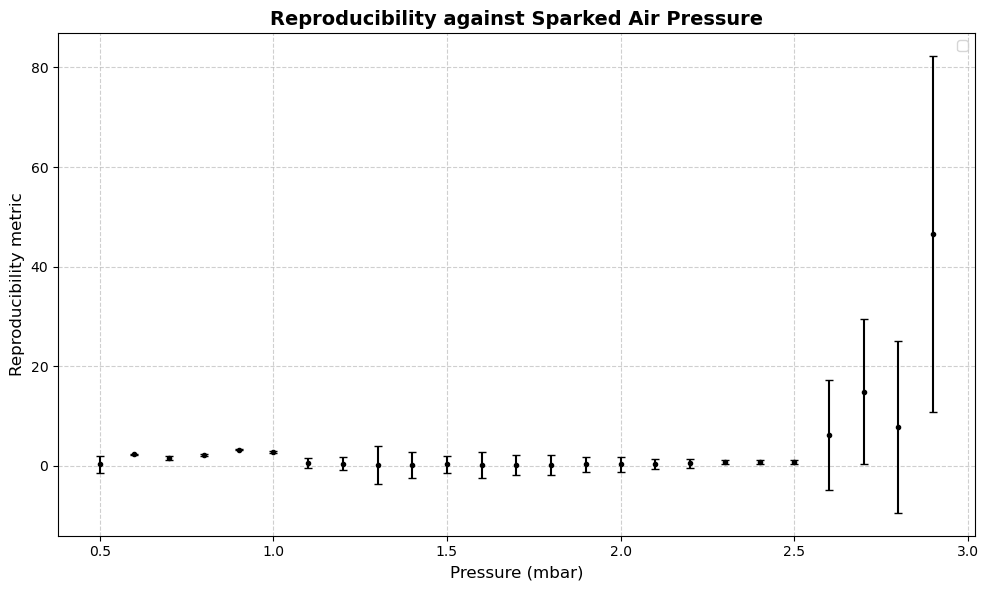

In [11]:
weights = 1 / reprod_err[7:16]
constant_fit = np.sum(reprod[7:16] * weights) / np.sum(weights)
constant_fit_err = np.sqrt(1 / np.sum(weights))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot reproducibility points with error bars
ax.errorbar(p_windows[0:25], reprod, yerr=reprod_err, fmt='k.', capsize=3)

# Plot weighted mean as dashed line
#ax.axhline(y=constant_fit, color='darkred', linestyle='--', linewidth=2,
#           label=f'Weighted Mean Reproducibility Metric: {constant_fit:.2f} ± {constant_fit_err:.2f}')

# Add shaded uncertainty region
#ax.fill_between(
#    [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2],
#    constant_fit - constant_fit_err,
#    constant_fit + constant_fit_err,
#    color='red', alpha=0.2
#)

# Annotate reproducibility
#repro_diff = reprod[6:10][0] - reprod[6:10][2]
#repro_err = reprod_err[6:10][0] + reprod_err[6:10][2]  # Use error values, not reprod itself
#annot_text = f"Reproducible within:\n{repro_diff:.2f} ± {repro_err:.2f} photons"

#ax.text(0.02, 0.95, annot_text, transform=ax.transAxes,
#        fontsize=12, verticalalignment='top',
#        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'))

# Labels and styling
plt.title("Reproducibility against Sparked Air Pressure", fontsize=14, weight='bold')
ax.set_xlabel("Pressure (mbar)", fontsize=12)
ax.set_ylabel("Reproducibility metric", fontsize=12)
ax.grid(True, which='both', linestyle='--', alpha=0.6)
ax.legend(fontsize=10)
#ax.set_ylim(-5, 5)
#ax.set_xlim(1, 2.1)

plt.tight_layout()
plt.show()
